In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi': 150})
# Use valid rcParams keys: set serif family and specify Times New Roman
plt.rcParams.update({'font.family': 'serif', 'font.serif': ['Times New Roman']})
import re
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('/Users/ainsleylewis/Documents/Astronomy/arXiver/2025_Data.csv')
data

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,journals,num_checks,affiliations,total_citations,non_self_citations,journal_flag,journal_flag_with_submitted,smart_keywords,smart_keywords_2,latex_countries
0,Insights on Galaxy Evolution from Interpretabl...,Galaxy appearances reveal the physics of how t...,['John F. Wu'],4.0,10.0,2.0,arxiv.org/pdf/2501.00089,Astrophysics of Galaxies,['Machine Learning'],AAS Journals,...,"ApJ (2025), 980 183",0,"Wu, John F.: Space Telescope Science Institute...",3.0,1.0,1,1,"['Astronomers', 'Astronomical evolution', 'Ast...","['Galaxies (573)', 'Astronomy image processing...",NaN
1,X-ray reverberation black hole mass and distan...,We fit X-ray reverberation models to Rossi X-r...,"[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nat...",16.0,18.0,1.0,arxiv.org/pdf/2501.12788,High Energy Astrophysical Phenomena,NaN,NaN,...,NaN,0,NaN,0.0,0.0,1,1,"['Accretion', 'Angular distance', 'Bayesian st...",['powered by accretion of matter from a compan...,"United Kingdom, United Kingdom, United Kingdom..."
2,The TES-based Cryogenic AntiCoincidence Detect...,The Cryogenic AntiCoincidence Detector (CryoAC...,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...",17.0,8.0,0.0,arxiv.org/pdf/2501.12781,Instrumentation and Methods for Astrophysics,NaN,IEEE Transactions on Applied Superconductivity...,...,NaN,0,"D'Andrea, Matteo: INAF/IAPS, 00133, Rome, Ital...",1.0,0.0,1,1,[],[],NaN
3,Massive star clusters in the gamma-ray sky: th...,Massive Star Clusters (SCs) have been proposed...,"['Giada Peron', 'Giovanni Morlino', 'Stefano G...",3.0,5.0,1.0,arxiv.org/pdf/2501.12767,High Energy Astrophysical Phenomena,NaN,NaN,...,NaN,0,NaN,0.0,0.0,0,0,"['Cosmic ray objects', 'Cosmic ray sources', '...","['Cosmic Rays 1', 'HII regions', 'Gamma rays',...","Italy, France"
4,The Impact of Bar-induced Non-Circular Motions...,We study the impact of bar-induced non-circula...,"['Jie Liu', 'Zhi Li', 'Juntai Shen']",12.0,19.0,1.0,arxiv.org/pdf/2501.12760,Astrophysics of Galaxies,NaN,NaN,...,NaN,0,"Liu, Jie: Shanghai Astronomical Observatory, C...",4.0,3.0,1,1,"['Disk galaxies', 'Galactic bar', 'Galaxies']",['galaxies: rotation curve - galaxies: fundame...,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,Cosmic Himalayas in CROCODILE : Probing the Ex...,The recently reported Cosmic Himalayas (CH) --...,"['Yuto Kuwayama', 'Yongming Liang', 'Kentaro N...",10.0,18.0,5.0,arxiv.org/pdf/2512.24966,Cosmology and Nongalactic Astrophysics,['Astrophysics of Galaxies'],NaN,...,NaN,0,"[None, None, None, None, None, None, None, Non...",0.0,0.0,0,1,"['Apparent anomaly', 'Clustering', 'Cosmologic...",['Hydrodynamicalsimulations(767)'],"Japan, Japan, Japan, Japan, Japan, Japan, Unit..."
18656,Multi-Frequency Study of FRB20201124A with the...,We present results from multi-epoch observatio...,"['C. Dudeja', 'J. Roy', 'U. Panda', 'S. Bhatta...",11.0,17.0,1.0,arxiv.org/pdf/2512.24978,High Energy Astrophysical Phenomena,NaN,NaN,...,NaN,0,"[None, None, None, None]",0.0,0.0,0,0,"['FRB', 'FRBs', 'Fast radio burst']",[],"India, India, India, India"
18657,Distributions of wide binary stars in theory a...,"Using the censored catalog of 103,169 resolved...",['Valeri V. Makarov'],7.0,13.0,1.0,arxiv.org/pdf/2512.25002,Solar and Stellar Astrophysics,NaN,NaN,...,NaN,0,[None],0.0,0.0,1,1,"['A stars', 'A type stars', 'A-type stars']",[],United States
18658,Towards precision cosmology with Voids x CMB c...,We construct and validate a set of multi-purpo...,"['Mar Pérez Sar', 'Carlos Hernández Monteagudo...",8.0,19.0,1.0,arxiv.org/pdf/2512.25040,Cosmology and Nongalactic Astrophysics,NaN,NaN,...,NaN,0,"[None, None, None, None]",0.0,0.0,0,1,"['CMB', 'Catalogs', 'Clustering']",['Cosmology: Large-scale structure - Cosmic mi...,"Spain, Spain, Hungary, Hungary, France, United..."


In [3]:
# Using affiliations column to get countries

# 1. Setup the replacement dictionary
replacement_dict = {
    'USA': 'United States',
    'UK': 'United Kingdom',
    'UAE': 'United Arab Emirates',
    'United States of America': 'United States',
    "People's Republic of China": 'China',
    'The Netherlands': 'Netherlands',
    'Republic of Korea': 'South Korea',
    'The United Kingdom': 'United Kingdom'
}

# 2. Load the reference countries
# Assuming 'world_coords.csv' is in the current directory
try:
    world_coords = pd.read_csv('/Users/ainsleylewis/Documents/Astronomy/arXiver/world_coords.csv')
    # Create a set of valid countries for O(1) lookup speed
    valid_countries = set(world_coords['country'].unique())
except FileNotFoundError:
    print("Error: 'world_coords.csv' not found. Please ensure the file exists.")
    valid_countries = set()

# 3. Define the extraction function
def extract_countries_from_affiliations(affil_text):
    """
    Parses an affiliation string, splits by semicolon, and extracts 
    countries based on the valid_countries list and replacement_dict.
    """
    if not isinstance(affil_text, str) or not affil_text:
        return []

    found_countries = []
    
    # Split the row containing multiple affiliations by ';'
    affiliations = affil_text.split(';')
    
    for affil in affiliations:
        affil = affil.strip()
        if not affil:
            continue
            
        # Strategy: Look at the text after the last comma first (standard address format),
        # then fall back to checking the end of the string.
        
        # Get the last part after the last comma
        if ',' in affil:
            last_part = affil.split(',')[-1].strip()
        else:
            last_part = affil

        # Remove trailing periods (e.g., "USA." -> "USA")
        last_part_clean = last_part.rstrip('.')
        
        country_candidate = None

        # Check 1: Is this exact text in our replacement dict?
        if last_part_clean in replacement_dict:
            country_candidate = replacement_dict[last_part_clean]
        
        # Check 2: Is this exact text a valid country?
        elif last_part_clean in valid_countries:
            country_candidate = last_part_clean
            
        # Check 3 (Fallback): If the address is complex, iterate through keys/countries
        # to see if the string ENDS with them.
        else:
            # Check replacements via regex at end of string
            for key, val in replacement_dict.items():
                # Matches "Key" at end of string, optionally followed by a dot
                if re.search(r'\b' + re.escape(key) + r'\.?$', affil):
                    country_candidate = val
                    break
            
            # If still not found, check valid countries via regex at end of string
            if not country_candidate:
                for country in valid_countries:
                    if re.search(r'\b' + re.escape(country) + r'\.?$', affil):
                        country_candidate = country
                        break

        # If we identified a valid country (and it exists in our reference list)
        if country_candidate:
            # Ensure the replaced name is actually in our valid list 
            # (e.g. if 'United States' is in world_coords)
            if country_candidate in valid_countries:
                found_countries.append(country_candidate)
            else:
                # If the replacement map gives "United States" but world_coords 
                # strictly uses "USA" (unlikely based on your dict, but good safety),
                # we keep the candidate.
                found_countries.append(country_candidate)
                
    return found_countries

# 4. Apply the function to the dataframe
# Assuming your dataframe is named 'data'
if 'data' in locals():
    data['affil_countries'] = data['affiliations'].apply(extract_countries_from_affiliations)

    # Display the result to verify
    print(data[['affiliations', 'affil_countries']].head())
else:
    print("Dataframe 'data' not found. Please load your data first.")

                                        affiliations  \
0  Wu, John F.: Space Telescope Science Institute...   
1                                                NaN   
2  D'Andrea, Matteo: INAF/IAPS, 00133, Rome, Ital...   
3                                                NaN   
4  Liu, Jie: Shanghai Astronomical Observatory, C...   

                                     affil_countries  
0      [United States, United States, United States]  
1                                                 []  
2  [Italy, Italy, Italy, Italy, Italy, Italy, Ita...  
3                                                 []  
4         [China, China, China, China, China, China]  


In [4]:
# For how many columns do we have counties in both affil_countries and latex_countries
count_both = 0
for affil_list, latex_list in zip(data['affil_countries'], data['latex_countries']):
    if affil_list and latex_list:
        count_both += 1
count_both

# Country name mismatches between affil_countries and latex_countries

def check_country_mismatches(df):
    """
    Identifies rows where the extracted 'affil_countries' list does not match 
    the parsed 'latex_countries' string.
    """
    
    # List to store indices of mismatching rows
    mismatch_indices = []

    # Iterate through the dataframe
    for index, row in df.iterrows():
        
        # 1. Get the generated list from the previous step
        derived_list = row['affil_countries']
        
        # 2. Get the manual/latex string
        latex_str = row['latex_countries']
        
        # 3. Filter: Only check rows that have valid entries in BOTH columns
        # Check if derived_list is valid (not None and not empty)
        has_derived = isinstance(derived_list, list) and len(derived_list) > 0
        
        # Check if latex_str is valid (not NaN/None and not empty string)
        has_latex = pd.notna(latex_str) and str(latex_str).strip() != ''
        
        if has_derived and has_latex:
            # 4. Convert latex string to list for comparison
            # Split by comma, strip whitespace around the country name
            latex_list = [c.strip() for c in str(latex_str).split(',') if c.strip()]
            
            # 5. Strict comparison (Order and Count must match exactly)
            if derived_list != latex_list:
                mismatch_indices.append(index)

    # 6. Create a dataframe subset containing only mismatches
    mismatched_rows = df.loc[mismatch_indices].copy()
    
    # Add a column showing the parsed latex list for easier visual comparison
    mismatched_rows['latex_list_parsed'] = mismatched_rows['latex_countries'].apply(
        lambda x: [c.strip() for c in str(x).split(',') if c.strip()]
    )
    
    return mismatched_rows

# --- Execution ---

# Run the check
mismatches = check_country_mismatches(data)

# Output results
if mismatches.empty:
    print("Success! No mismatches found between affiliations and latex_countries.")
else:
    print(f"Found {len(mismatches)} mismatches.")
    print("\nSample of mismatches (showing derived vs latex):")
    
    # specific columns to view
    cols_to_view = ['affil_countries', 'latex_list_parsed', 'affiliations']
    
    # Adjust pandas display options to ensure we see the full columns
    with pd.option_context('display.max_colwidth', None):
        print(mismatches[cols_to_view].head(10))

    # Optional: Save to CSV to inspect manually
    # mismatches.to_csv('country_mismatches.csv')


Found 7495 mismatches.

Sample of mismatches (showing derived vs latex):
                                                                                                                                                    affil_countries  \
4                                                                                                                        [China, China, China, China, China, China]   
5                                                                                     [China, China, China, China, China, China, China, China, China, China, China]   
6                                                                                                                                                   [United States]   
7                                                                                                                        [Spain, Spain, Spain, Spain, Spain, Spain]   
8   [Netherlands, United States, United States, United States, United States, United States,

In [5]:
data

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,num_checks,affiliations,total_citations,non_self_citations,journal_flag,journal_flag_with_submitted,smart_keywords,smart_keywords_2,latex_countries,affil_countries
0,Insights on Galaxy Evolution from Interpretabl...,Galaxy appearances reveal the physics of how t...,['John F. Wu'],4.0,10.0,2.0,arxiv.org/pdf/2501.00089,Astrophysics of Galaxies,['Machine Learning'],AAS Journals,...,0,"Wu, John F.: Space Telescope Science Institute...",3.0,1.0,1,1,"['Astronomers', 'Astronomical evolution', 'Ast...","['Galaxies (573)', 'Astronomy image processing...",NaN,"[United States, United States, United States]"
1,X-ray reverberation black hole mass and distan...,We fit X-ray reverberation models to Rossi X-r...,"[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nat...",16.0,18.0,1.0,arxiv.org/pdf/2501.12788,High Energy Astrophysical Phenomena,NaN,NaN,...,0,NaN,0.0,0.0,1,1,"['Accretion', 'Angular distance', 'Bayesian st...",['powered by accretion of matter from a compan...,"United Kingdom, United Kingdom, United Kingdom...",[]
2,The TES-based Cryogenic AntiCoincidence Detect...,The Cryogenic AntiCoincidence Detector (CryoAC...,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...",17.0,8.0,0.0,arxiv.org/pdf/2501.12781,Instrumentation and Methods for Astrophysics,NaN,IEEE Transactions on Applied Superconductivity...,...,0,"D'Andrea, Matteo: INAF/IAPS, 00133, Rome, Ital...",1.0,0.0,1,1,[],[],NaN,"[Italy, Italy, Italy, Italy, Italy, Italy, Ita..."
3,Massive star clusters in the gamma-ray sky: th...,Massive Star Clusters (SCs) have been proposed...,"['Giada Peron', 'Giovanni Morlino', 'Stefano G...",3.0,5.0,1.0,arxiv.org/pdf/2501.12767,High Energy Astrophysical Phenomena,NaN,NaN,...,0,NaN,0.0,0.0,0,0,"['Cosmic ray objects', 'Cosmic ray sources', '...","['Cosmic Rays 1', 'HII regions', 'Gamma rays',...","Italy, France",[]
4,The Impact of Bar-induced Non-Circular Motions...,We study the impact of bar-induced non-circula...,"['Jie Liu', 'Zhi Li', 'Juntai Shen']",12.0,19.0,1.0,arxiv.org/pdf/2501.12760,Astrophysics of Galaxies,NaN,NaN,...,0,"Liu, Jie: Shanghai Astronomical Observatory, C...",4.0,3.0,1,1,"['Disk galaxies', 'Galactic bar', 'Galaxies']",['galaxies: rotation curve - galaxies: fundame...,Germany,"[China, China, China, China, China, China]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,Cosmic Himalayas in CROCODILE : Probing the Ex...,The recently reported Cosmic Himalayas (CH) --...,"['Yuto Kuwayama', 'Yongming Liang', 'Kentaro N...",10.0,18.0,5.0,arxiv.org/pdf/2512.24966,Cosmology and Nongalactic Astrophysics,['Astrophysics of Galaxies'],NaN,...,0,"[None, None, None, None, None, None, None, Non...",0.0,0.0,0,1,"['Apparent anomaly', 'Clustering', 'Cosmologic...",['Hydrodynamicalsimulations(767)'],"Japan, Japan, Japan, Japan, Japan, Japan, Unit...",[]
18656,Multi-Frequency Study of FRB20201124A with the...,We present results from multi-epoch observatio...,"['C. Dudeja', 'J. Roy', 'U. Panda', 'S. Bhatta...",11.0,17.0,1.0,arxiv.org/pdf/2512.24978,High Energy Astrophysical Phenomena,NaN,NaN,...,0,"[None, None, None, None]",0.0,0.0,0,0,"['FRB', 'FRBs', 'Fast radio burst']",[],"India, India, India, India",[]
18657,Distributions of wide binary stars in theory a...,"Using the censored catalog of 103,169 resolved...",['Valeri V. Makarov'],7.0,13.0,1.0,arxiv.org/pdf/2512.25002,Solar and Stellar Astrophysics,NaN,NaN,...,0,[None],0.0,0.0,1,1,"['A stars', 'A type stars', 'A-type stars']",[],United States,[]
18658,Towards precision cosmology with Voids x CMB c...,We construct and validate a set of multi-purpo...,"['Mar Pérez Sar', 'Carlos Hernández Monteagudo...",8.0,19.0,1.0,arxiv.org/pdf/2512.25040,Cosmology and Nongalactic Astrophysics,NaN,NaN,...,0,"[None, None, None, None]",0.0,0.0,0,1,"['CMB', 'Catalogs', 'Clustering']",['Cosmology: Large-scale structure - Cosmic mi...,"Spain, Spain, Hungary, Hung

In [5]:
# All countires column and first authors column

def process_country_columns(row):
    """
    Helper function to generate the 'all_countries' and 'first_author' data
    based on row values.
    """
    # --- Logic for 'all_countries' ---
    # Default to the extracted countries from affiliations
    final_all_countries = row['affil_countries']
    
    # Check if the list is empty or invalid (NaN/None)
    is_affil_empty = not isinstance(final_all_countries, list) or len(final_all_countries) == 0
    
    # If empty, fill from 'latex_countries'
    if is_affil_empty:
        latex_val = row.get('latex_countries')
        if pd.notna(latex_val) and str(latex_val).strip() != '':
            # Convert comma-separated string to list
            final_all_countries = [x.strip() for x in str(latex_val).split(',') if x.strip()]
        else:
            final_all_countries = []

    # --- Logic for 'first_author' ---
    first_author_countries = []
    affil_text = row.get('affiliations')
    
    # 1. Try to get first author from 'affiliations' column
    # We split by ';' and take the first segment (index 0)
    if pd.notna(affil_text) and str(affil_text).strip() != '':
        first_segment = str(affil_text).split(';')[0]
        # Use the function defined in Step 1 to extract country from just this segment
        first_author_countries = extract_countries_from_affiliations(first_segment)
    
    # 2. If no country found in affiliations, fallback to first entry of 'latex_countries'
    if not first_author_countries:
        latex_val = row.get('latex_countries')
        if pd.notna(latex_val) and str(latex_val).strip() != '':
            # Split by comma and take the first item
            first_latex_country = str(latex_val).split(',')[0].strip()
            if first_latex_country:
                first_author_countries = [first_latex_country]

    return pd.Series([final_all_countries, first_author_countries])

# Apply the logic to the dataframe
if 'data' in locals():
    data[['all_countries', 'first_author']] = data.apply(process_country_columns, axis=1)

    # Display results to verify
    cols_to_show = ['affiliations', 'latex_countries', 'all_countries', 'first_author']
    print(data[cols_to_show].head())
else:
    print("Dataframe 'data' not found.")

                                        affiliations  \
0  Wu, John F.: Space Telescope Science Institute...   
1                                                NaN   
2  D'Andrea, Matteo: INAF/IAPS, 00133, Rome, Ital...   
3                                                NaN   
4  Liu, Jie: Shanghai Astronomical Observatory, C...   

                                     latex_countries  \
0                                                NaN   
1  United Kingdom, United Kingdom, United Kingdom...   
2                                                NaN   
3                                      Italy, France   
4                                            Germany   

                                       all_countries      first_author  
0      [United States, United States, United States]   [United States]  
1  [United Kingdom, United Kingdom, United Kingdo...  [United Kingdom]  
2  [Italy, Italy, Italy, Italy, Italy, Italy, Ita...           [Italy]  
3                                 

In [6]:
# Percentage of rows for which we have countries in 'all_countries' and 'first_author' columns

def calculate_fill_percentage(df, col_name):
    """
    Calculates the percentage of rows where col_name is a non-empty list.
    """
    total_rows = len(df)
    
    if total_rows == 0:
        return 0.0
    
    # Check if the value is a list AND has items in it
    # isinstance(x, list) filters out NaNs (floats) and None types safely
    non_empty_count = df[col_name].apply(
        lambda x: isinstance(x, list) and len(x) > 0
    ).sum()
    
    return (non_empty_count / total_rows) * 100

# --- Execution ---

if 'data' in locals():
    # Calculate percentages
    pct_all_countries = calculate_fill_percentage(data, 'all_countries')
    pct_first_author = calculate_fill_percentage(data, 'first_author')

    print(f"Total Rows: {len(data)}")
    print(f"Fill Rate for 'all_countries': {pct_all_countries:.2f}%")
    print(f"Fill Rate for 'first_author':  {pct_first_author:.2f}%")
else:
    print("Dataframe 'data' not found.")

Total Rows: 18660
Fill Rate for 'all_countries': 96.91%
Fill Rate for 'first_author':  96.77%


In [8]:
data

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,total_citations,non_self_citations,journal_flag,journal_flag_with_submitted,smart_keywords,smart_keywords_2,latex_countries,affil_countries,all_countries,first_author
0,Insights on Galaxy Evolution from Interpretabl...,Galaxy appearances reveal the physics of how t...,['John F. Wu'],4.0,10.0,2.0,arxiv.org/pdf/2501.00089,Astrophysics of Galaxies,['Machine Learning'],AAS Journals,...,3.0,1.0,1,1,"['Astronomers', 'Astronomical evolution', 'Ast...","['Galaxies (573)', 'Astronomy image processing...",NaN,"[United States, United States, United States]","[United States, United States, United States]",[United States]
1,X-ray reverberation black hole mass and distan...,We fit X-ray reverberation models to Rossi X-r...,"[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nat...",16.0,18.0,1.0,arxiv.org/pdf/2501.12788,High Energy Astrophysical Phenomena,NaN,NaN,...,0.0,0.0,1,1,"['Accretion', 'Angular distance', 'Bayesian st...",['powered by accretion of matter from a compan...,"United Kingdom, United Kingdom, United Kingdom...",[],"[United Kingdom, United Kingdom, United Kingdo...",[United Kingdom]
2,The TES-based Cryogenic AntiCoincidence Detect...,The Cryogenic AntiCoincidence Detector (CryoAC...,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...",17.0,8.0,0.0,arxiv.org/pdf/2501.12781,Instrumentation and Methods for Astrophysics,NaN,IEEE Transactions on Applied Superconductivity...,...,1.0,0.0,1,1,[],[],NaN,"[Italy, Italy, Italy, Italy, Italy, Italy, Ita...","[Italy, Italy, Italy, Italy, Italy, Italy, Ita...",[Italy]
3,Massive star clusters in the gamma-ray sky: th...,Massive Star Clusters (SCs) have been proposed...,"['Giada Peron', 'Giovanni Morlino', 'Stefano G...",3.0,5.0,1.0,arxiv.org/pdf/2501.12767,High Energy Astrophysical Phenomena,NaN,NaN,...,0.0,0.0,0,0,"['Cosmic ray objects', 'Cosmic ray sources', '...","['Cosmic Rays 1', 'HII regions', 'Gamma rays',...","Italy, France",[],"[Italy, France]",[Italy]
4,The Impact of Bar-induced Non-Circular Motions...,We study the impact of bar-induced non-circula...,"['Jie Liu', 'Zhi Li', 'Juntai Shen']",12.0,19.0,1.0,arxiv.org/pdf/2501.12760,Astrophysics of Galaxies,NaN,NaN,...,4.0,3.0,1,1,"['Disk galaxies', 'Galactic bar', 'Galaxies']",['galaxies: rotation curve - galaxies: fundame...,Germany,"[China, China, China, China, China, China]","[China, China, China, China, China, China]",[China]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,Cosmic Himalayas in CROCODILE : Probing the Ex...,The recently reported Cosmic Himalayas (CH) --...,"['Yuto Kuwayama', 'Yongming Liang', 'Kentaro N...",10.0,18.0,5.0,arxiv.org/pdf/2512.24966,Cosmology and Nongalactic Astrophysics,['Astrophysics of Galaxies'],NaN,...,0.0,0.0,0,1,"['Apparent anomaly', 'Clustering', 'Cosmologic...",['Hydrodynamicalsimulations(767)'],"Japan, Japan, Japan, Japan, Japan, Japan, Unit...",[],"[Japan, Japan, Japan, Japan, Japan, Japan, Uni...",[Japan]
18656,Multi-Frequency Study of FRB20201124A with the...,We present results from multi-epoch observatio...,"['C. Dudeja', 'J. Roy', 'U. Panda', 'S. Bhatta...",11.0,17.0,1.0,arxiv.org/pdf/2512.24978,High Energy Astrophysical Phenomena,NaN,NaN,...,0.0,0.0,0,0,"['FRB', 'FRBs', 'Fast radio burst']",[],"India, India, India, India",[],"[India, India, India, India]",[India]
18657,Distributions of wide binary stars in theory a...,"Using the censored catalog of 103,169 resolved...",['Valeri V. Makarov'],7.0,13.0,1.0,arxiv.org/pdf/2512.25002,Solar and Stellar Astrophysics,NaN,NaN,...,0.0,0.0,1,1,"['A stars', 'A type stars', 'A-type stars']",[],United States,[],[United States],[United States]
18658,Towards precision cosmology with Voids x CMB c...,We construct and validate a set of multi-purpo...,"['Mar Pérez Sar', 'Carlos Hernández Monteagudo...",8.0,19.0,1.0,arxiv.org/pdf/2512.25040,Cosmology and Nongalactic Astrophysics,NaN,NaN,...,0.0,0.0,0,1,"['

In [7]:
# Count number of rows with [] in 'all_countries' column
brackets_counter = 0
for countries in data['all_countries']:
    if countries == []:
        brackets_counter += 1
print(brackets_counter)

# Count number of rows with 'NaN' or missing values in 'all_countries' column
nan_counter = 0
for countries in data['all_countries']:
    if not isinstance(countries, list) or len(countries) == 0:
        nan_counter += 1
print(nan_counter)

576
576


In [10]:
world_coords

,country_code,latitude,longitude,country,usa_state_code,usa_state_latitude,usa_state_longitude,usa_state
0,AD,42.546245,1.601554,Andorra,AK,63.588753,-154.493062,Alaska
1,AE,23.424076,53.847818,United Arab Emirates,AL,32.318231,-86.902298,Alabama
2,AF,33.939110,67.709953,Afghanistan,AR,35.201050,-91.831833,Arkansas
3,AG,17.060816,-61.796428,Antigua and Barbuda,AZ,34.048928,-111.093731,Arizona
4,AI,18.220554,-63.068615,Anguilla,CA,36.778261,-119.417932,California
...,...,...,...,...,...,...,...,...
240,YE,15.552727,48.516388,Yemen,NaN,NaN,NaN,NaN
241,YT,-12.827500,45.166244,Mayotte,NaN,NaN,NaN,NaN
242,ZA,-30.559482,22.937506,South Africa,NaN,NaN,NaN,NaN
243,ZM,-13.133897,27.849332,Zambia,NaN,NaN,NaN,NaN


In [8]:
# Number of Unique Countires in 'all_countries' column
unique_countries = set()
for countries in data['all_countries']:
    for country in countries:
        unique_countries.add(country)
print(len(unique_countries))

127


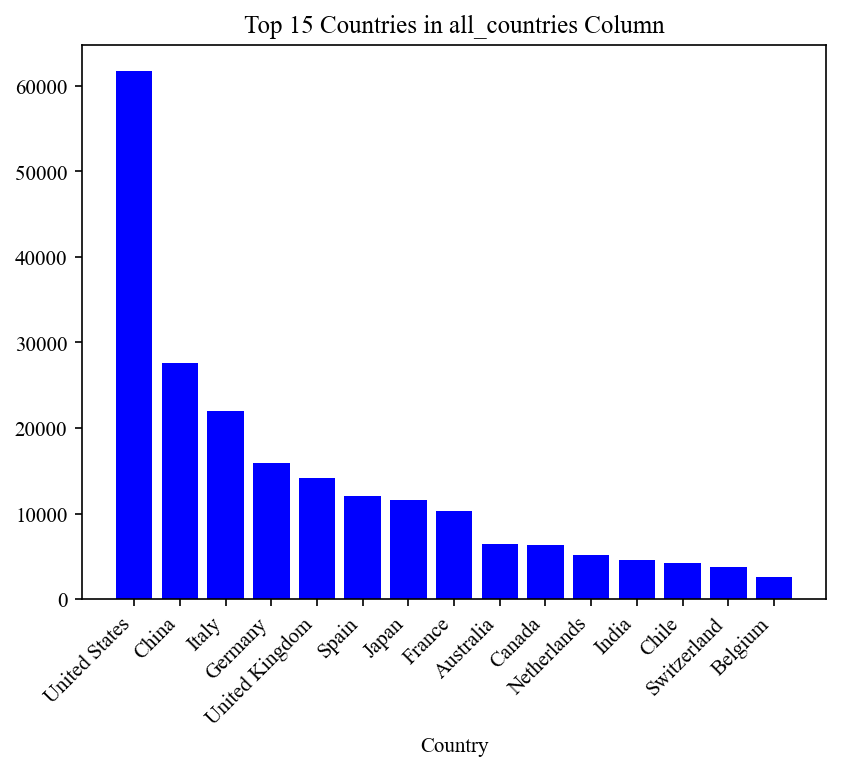

In [12]:
# Histogram of Top 15 Countries in 'all_countries' column
from collections import Counter
country_counter = Counter()
for countries in data['all_countries']:
    for country in countries:
        country_counter[country] += 1
top_15 = country_counter.most_common(15)
countries, counts = zip(*top_15)
plt.bar(countries, counts, color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Countries in all_countries Column')
plt.xlabel('Country')
plt.show()

In [9]:
# Percentage that the 'US' and 'China' represent in 'all_countries' column
total_count = 0
us_count = 0
china_count = 0
for countries in data['all_countries']:
    for country in countries:
        total_count += 1
        if country == 'United States':
            us_count += 1
        elif country == 'China':
            china_count += 1
us_percentage = (us_count / total_count) * 100 if total_count > 0 else 0
china_percentage = (china_count / total_count) * 100 if total_count > 0 else 0
print(f"US Percentage: {us_percentage:.2f}%")
print(f"China Percentage: {china_percentage:.2f}%")

US Percentage: 25.61%
China Percentage: 11.43%


Text(0.5, 0, 'Country')

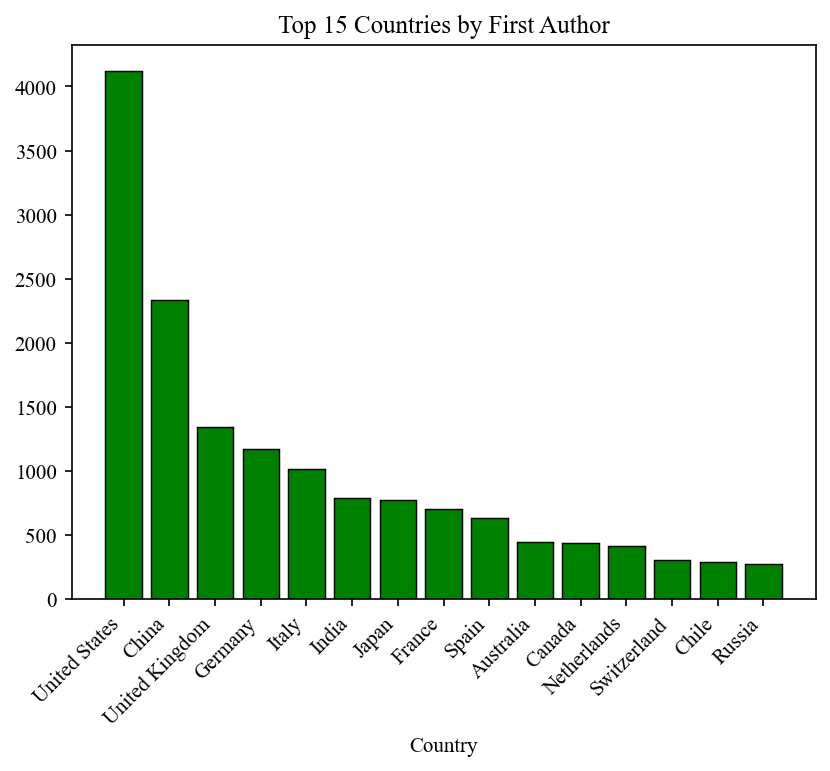

In [10]:
# Histogram ofr top 15 countriesin 'first_author' column
country_counts = []
for countries in data['first_author']:
    for country in countries:
        country_counts.append(country)
from collections import Counter
country_counter = Counter(country_counts)
top_15 = country_counter.most_common(15)
countries, counts = zip(*top_15)
plt.bar(countries, counts, color='green', edgecolor='black', linewidth=0.7)
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Countries by First Author')
plt.xlabel('Country')

In [11]:
# Percentage that the 'US' and 'China' represent in 'first_author' column
total_count = 0
us_count = 0
china_count = 0
for countries in data['first_author']:
    for country in countries:
        total_count += 1
        if country == 'United States':
            us_count += 1
        elif country == 'China':
            china_count += 1
us_percentage = (us_count / total_count) * 100 if total_count > 0 else 0
china_percentage = (china_count / total_count) * 100 if total_count > 0 else 0
print(f"US Percentage (First Author): {us_percentage:.2f}%")
print(f"China Percentage (First Author): {china_percentage:.2f}%")

US Percentage (First Author): 22.82%
China Percentage (First Author): 12.91%


In [12]:
# Number of Unique Countires in 'first_author' column
unique_countries = set()
for countries in data['first_author']:
    for country in countries:
        unique_countries.add(country)
print(len(unique_countries))

105


In [13]:
# Collaboration between countries in 'all_countries' column
collaboration_counts = {}
for countries in data['all_countries']:
    unique_countries = set(countries)
    country_list = list(unique_countries)
    n = len(country_list)
    for i in range(n):
        for j in range(i + 1, n):
            pair = tuple(sorted([country_list[i], country_list[j]]))
            if pair in collaboration_counts:
                collaboration_counts[pair] += 1
            else:
                collaboration_counts[pair] = 1
# Display top 10 collaborations
top_collaborations = sorted(collaboration_counts.items(), key=lambda x: x[1], reverse=True)[:10]
for pair, count in top_collaborations:
    print(f"{pair[0]} - {pair[1]}: {count}")

United Kingdom - United States: 2524
Germany - United States: 2308
Italy - United States: 1820
France - United States: 1623
Germany - United Kingdom: 1514
Spain - United States: 1492
Germany - Italy: 1402
Italy - United Kingdom: 1363
Canada - United States: 1314
China - United States: 1234


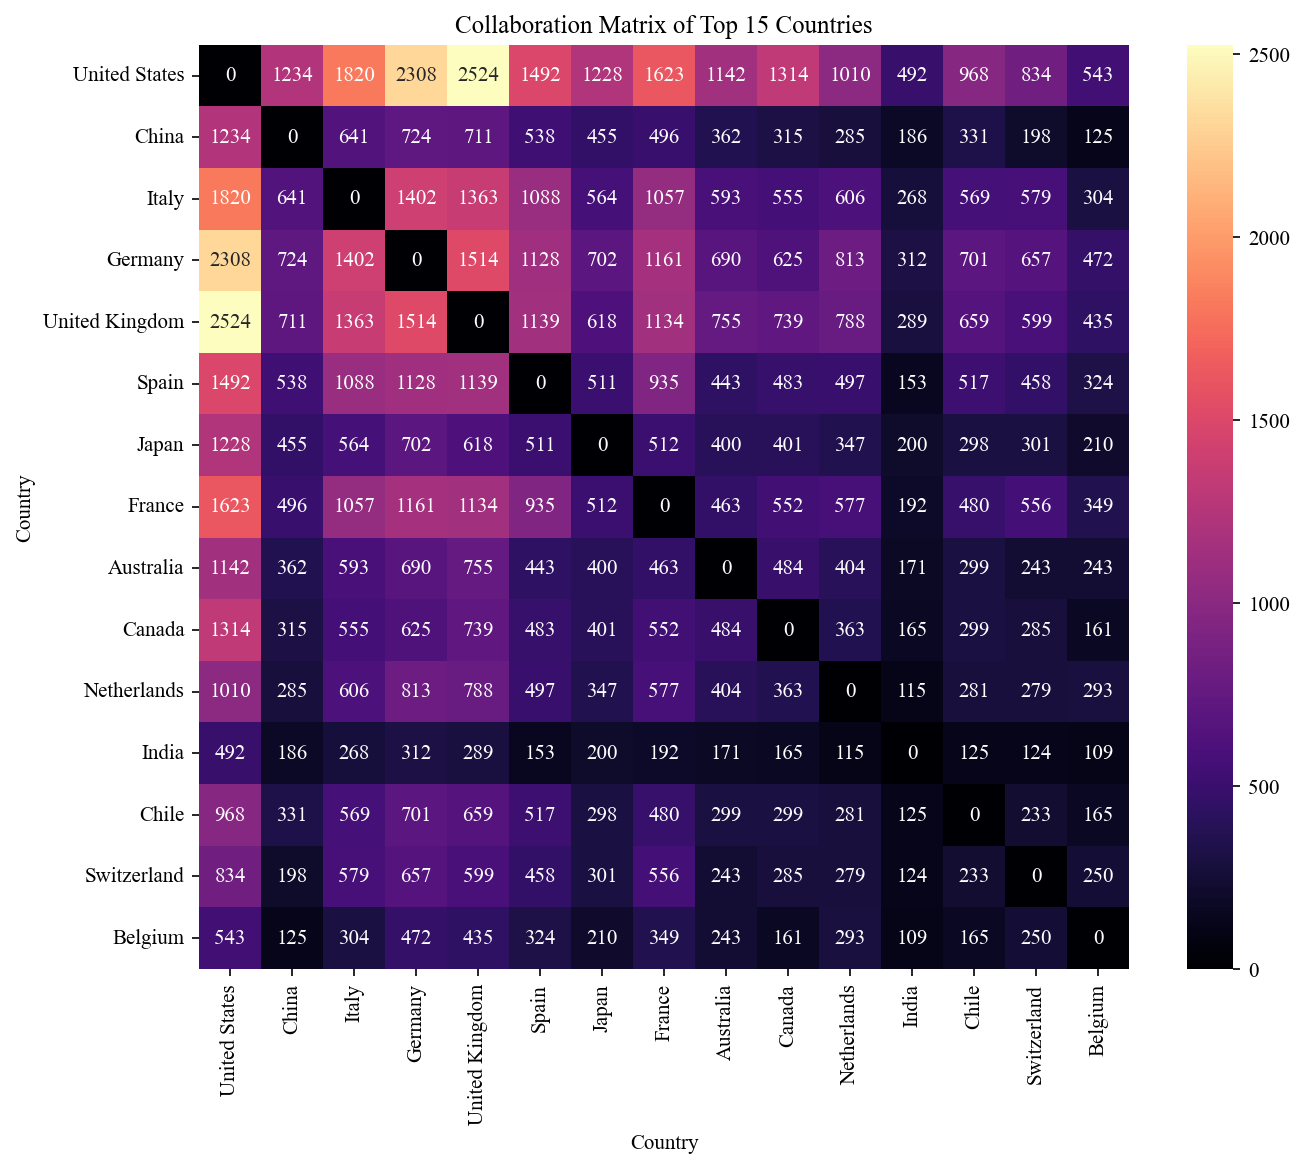

In [14]:
# Confusion Matrix like plot of the top 15 versus top 15 countries in 'all_countries' column with each cell having the number of collaborations between the two countries
import seaborn as sns
from collections import Counter
# Get top 15 countries
country_counter = Counter()
for countries in data['all_countries']:
    for country in countries:
        country_counter[country] += 1
top_15 = [country for country, count in country_counter.most_common(15)]
# Initialize collaboration matrix
collab_matrix = pd.DataFrame(0, index=top_15, columns=top_15)
# Populate the matrix
for countries in data['all_countries']:
    unique_countries = set(countries)
    filtered_countries = [c for c in unique_countries if c in top_15]
    n = len(filtered_countries)
    for i in range(n):
        for j in range(i + 1, n):
            c1 = filtered_countries[i]
            c2 = filtered_countries[j]
            collab_matrix.at[c1, c2] += 1
            collab_matrix.at[c2, c1] += 1
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(collab_matrix, annot=True, fmt='d', cmap='magma')
plt.title('Collaboration Matrix of Top 15 Countries')
plt.xlabel('Country')
plt.ylabel('Country')
plt.show()

In [15]:
# Number of papers with a single author in the authors column
single_author_count = 0
for authors in data['authors']:
    if isinstance(authors, str):
        author_list = [a.strip() for a in authors.split(',') if a.strip()]
        if len(author_list) == 1:
            single_author_count += 1
print(single_author_count)


# Percentage of papers with a single author in the authors column
total_papers = len(data)
percentage_single_author = (single_author_count / total_papers) * 100 if total_papers > 0 else 0
print(f"Percentage of Single Author Papers: {percentage_single_author:.2f}%")

1330
Percentage of Single Author Papers: 7.13%


In [16]:
# Percentage of papers with no repeated countries in 'all_countries' column
# Filter to only consider papers with more than 1 country listed
relevant_countries_lists = [c for c in data['all_countries'] if len(c) > 1]
total_papers = len(relevant_countries_lists)

no_repeat_count = 0
for countries in relevant_countries_lists:
    if len(countries) == len(set(countries)):
        no_repeat_count += 1

no_repeat_percentage = (no_repeat_count / total_papers) * 100 if total_papers > 0 else 0
print(f"Analyzing {total_papers} papers with >1 country listed.")
print(f"Number of papers with no repeated countries: {no_repeat_count}")
print(f"Percentage of papers with no repeated countries: {no_repeat_percentage:.2f}%")

Analyzing 16485 papers with >1 country listed.
Number of papers with no repeated countries: 730
Percentage of papers with no repeated countries: 4.43%


In [17]:
# Average number of authors on a paper from the 'authors' column
total_authors = 0
for authors in data['authors']:
    if isinstance(authors, str):
        author_list = [a.strip() for a in authors.split(',') if a.strip()]
        total_authors += len(author_list)
average_authors = total_authors / len(data) if len(data) > 0 else 0
print(f"Average number of authors per paper: {average_authors:.2f}")

Average number of authors per paper: 10.19


In [18]:
# Average number of authors from the same contry in 'all_countries' column
total_same_country_authors = 0
for index, row in data.iterrows():
    authors = row['authors']
    countries = row['all_countries']
    if isinstance(authors, str) and isinstance(countries, list) and len(countries) > 0:
        author_list = [a.strip() for a in authors.split(',') if a.strip()]
        num_authors = len(author_list)
        num_countries = len(countries)
        if num_countries > 0:
            avg_authors_per_country = num_authors / num_countries
            total_same_country_authors += avg_authors_per_country
average_same_country_authors = total_same_country_authors / len(data) if len(data) > 0 else 0
print(f"Average number of authors from the same country per paper: {average_same_country_authors:.2f}")

# Average number of authors from the same county in 'all_countires' column as the first author in 'first_author' column
total_first_author_country_authors = 0
for index, row in data.iterrows():
    authors = row['authors']
    countries = row['all_countries']
    first_author_countries = row['first_author']
    if (isinstance(authors, str) and isinstance(countries, list) and 
        len(countries) > 0 and isinstance(first_author_countries, list) and 
        len(first_author_countries) > 0):
        
        first_country = first_author_countries[0]
        # Count how many times the first author's country appears in the list
        if first_country in countries:
            count_from_first_country = countries.count(first_country)
            total_first_author_country_authors += count_from_first_country
            
average_first_author_country_authors = (total_first_author_country_authors / len(data)) if len(data) > 0 else 0
print(f"Average number of authors from the same country as the first author per paper: {average_first_author_country_authors:.2f}")

Average number of authors from the same country per paper: 1.67
Average number of authors from the same country as the first author per paper: 6.27


In [19]:
# Initialize metrics columns
data['LCI'] = np.nan
data['LCR'] = np.nan
data['GCI'] = np.nan
data['NGCI'] = np.nan

# Calculate indices in a single loop for efficiency
for index, row in data.iterrows():
    authors = row['authors']
    countries = row['all_countries']
    first_author_countries = row['first_author']
    
    # Basic validation that data exists
    has_authors = isinstance(authors, str)
    has_countries = isinstance(countries, list) and len(countries) > 0
    has_first = isinstance(first_author_countries, list) and len(first_author_countries) > 0
    
    if has_authors and has_countries and has_first:
        author_list = [a.strip() for a in authors.split(',') if a.strip()]
        num_authors = len(author_list)
        first_country = first_author_countries[0]
        
        # 1. Local Collaboration Index (LCI)
        # Number of affiliations from the same country as the first author
        lci_val = countries.count(first_country)
        data.at[index, 'LCI'] = lci_val
        
        # 2. Local Collaborative Ratio (LCR)
        # Ratio of LCI to the total number of authors
        if num_authors > 0:
            data.at[index, 'LCR'] = lci_val / num_authors
            
        # 3. Global Collaboration Index (GCI)
        # Number of affiliations from countries different from the first author
        # (Total affiliations - Local affiliations)
        gci_val = len(countries) - lci_val
        data.at[index, 'GCI'] = gci_val
        
        # 4. Non-repeated Global Collaboration Index (NGCI)
        # Number of unique countries excluding the first author's country
        unique_other_countries = set(countries) - {first_country}
        data.at[index, 'NGCI'] = len(unique_other_countries)


In [57]:
data

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,smart_keywords,smart_keywords_2,latex_countries,affil_countries,all_countries,first_author,LCI,LCR,GCI,NGCI
0,Insights on Galaxy Evolution from Interpretabl...,Galaxy appearances reveal the physics of how t...,['John F. Wu'],4.0,10.0,2.0,arxiv.org/pdf/2501.00089,Astrophysics of Galaxies,['Machine Learning'],AAS Journals,...,"['Astronomers', 'Astronomical evolution', 'Ast...","['Galaxies (573)', 'Astronomy image processing...",NaN,"[United States, United States, United States]","[United States, United States, United States]",[United States],3.0,3.000000,0.0,0.0
1,X-ray reverberation black hole mass and distan...,We fit X-ray reverberation models to Rossi X-r...,"[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nat...",16.0,18.0,1.0,arxiv.org/pdf/2501.12788,High Energy Astrophysical Phenomena,NaN,NaN,...,"['Accretion', 'Angular distance', 'Bayesian st...",['powered by accretion of matter from a compan...,"United Kingdom, United Kingdom, United Kingdom...",[],"[United Kingdom, United Kingdom, United Kingdo...",[United Kingdom],3.0,0.428571,4.0,4.0
2,The TES-based Cryogenic AntiCoincidence Detect...,The Cryogenic AntiCoincidence Detector (CryoAC...,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...",17.0,8.0,0.0,arxiv.org/pdf/2501.12781,Instrumentation and Methods for Astrophysics,NaN,IEEE Transactions on Applied Superconductivity...,...,[],[],NaN,"[Italy, Italy, Italy, Italy, Italy, Italy, Ita...","[Italy, Italy, Italy, Italy, Italy, Italy, Ita...",[Italy],21.0,1.312500,0.0,0.0
3,Massive star clusters in the gamma-ray sky: th...,Massive Star Clusters (SCs) have been proposed...,"['Giada Peron', 'Giovanni Morlino', 'Stefano G...",3.0,5.0,1.0,arxiv.org/pdf/2501.12767,High Energy Astrophysical Phenomena,NaN,NaN,...,"['Cosmic ray objects', 'Cosmic ray sources', '...","['Cosmic Rays 1', 'HII regions', 'Gamma rays',...","Italy, France",[],"[Italy, France]",[Italy],1.0,0.250000,1.0,1.0
4,The Impact of Bar-induced Non-Circular Motions...,We study the impact of bar-induced non-circula...,"['Jie Liu', 'Zhi Li', 'Juntai Shen']",12.0,19.0,1.0,arxiv.org/pdf/2501.12760,Astrophysics of Galaxies,NaN,NaN,...,"['Disk galaxies', 'Galactic bar', 'Galaxies']",['galaxies: rotation curve - galaxies: fundame...,Germany,"[China, China, China, China, China, China]","[China, China, China, China, China, China]",[China],6.0,2.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,Cosmic Himalayas in CROCODILE : Probing the Ex...,The recently reported Cosmic Himalayas (CH) --...,"['Yuto Kuwayama', 'Yongming Liang', 'Kentaro N...",10.0,18.0,5.0,arxiv.org/pdf/2512.24966,Cosmology and Nongalactic Astrophysics,['Astrophysics of Galaxies'],NaN,...,"['Apparent anomaly', 'Clustering', 'Cosmologic...",['Hydrodynamicalsimulations(767)'],"Japan, Japan, Japan, Japan, Japan, Japan, Unit...",[],"[Japan, Japan, Japan, Japan, Japan, Japan, Uni...",[Japan],15.0,1.500000,3.0,2.0
18656,Multi-Frequency Study of FRB20201124A with the...,We present results from multi-epoch observatio...,"['C. Dudeja', 'J. Roy', 'U. Panda', 'S. Bhatta...",11.0,17.0,1.0,arxiv.org/pdf/2512.24978,High Energy Astrophysical Phenomena,NaN,NaN,...,"['FRB', 'FRBs', 'Fast radio burst']",[],"India, India, India, India",[],"[India, India, India, India]",[India],4.0,1.000000,0.0,0.0
18657,Distributions of wide binary stars in theory a...,"Using the censored catalog of 103,169 resolved...",['Valeri V. Makarov'],7.0,13.0,1.0,arxiv.org/pdf/2512.25002,Solar and Stellar Astrophysics,NaN,NaN,...,"['A stars', 'A type stars', 'A-type stars']",[],United States,[],[United States],[United States],1.0,1.000000,0.0,0.0
18658,Towards precision cosmology with Voids x CMB c...,We construct and validate a set of multi-purpo...,"['Mar Pérez Sar', 'Carlos Hernández Monteagudo...",8.0,19.0,1.0,arxiv.org/pdf/2512.25040,Cosmology and Nongalactic Astrophysics,NaN,NaN,...,

In [20]:
# Average LCI
median_lci = data['LCI'].median()
print(f"Median LCI: {median_lci:.2f}")
average_lci = data['LCI'].mean()
print(f"Average LCI: {average_lci:.2f}")
# Average LCR
median_lcr = data['LCR'].median()
print(f"Median LCR: {median_lcr:.2f}")
average_lcr = data['LCR'].mean()
print(f"Average LCR: {average_lcr:.2f}")
# Average GCI
median_gci = data['GCI'].median()
print(f"Median GCI: {median_gci:.2f}")
average_gci = data['GCI'].mean()
print(f"Average GCI: {average_gci:.2f}")
# Average NGCI
median_ngci = data['NGCI'].median()
print(f"Median NGCI: {median_ngci:.2f}")
average_ngci = data['NGCI'].mean()
print(f"Average NGCI: {average_ngci:.2f}")

Median LCI: 4.00
Average LCI: 6.48
Median LCR: 0.86
Average LCR: 1.03
Median GCI: 1.00
Average GCI: 6.86
Median NGCI: 1.00
Average NGCI: 1.98


In [21]:
# What percentage of papers come from the mega collaborations like CERN, LIGO, etc. defined as having more than 100 authors in the 'authors' column
mega_collab_count = 0
for authors in data['authors']:
    if isinstance(authors, str):
        author_list = [a.strip() for a in authors.split(',') if a.strip()]
        if len(author_list) > 20:
            mega_collab_count += 1
total_papers = len(data)
mega_collab_percentage = (mega_collab_count / total_papers) * 100 if total_papers > 0 else 0
print(f"Percentage of Mega Collaboration Papers (>20 authors): {mega_collab_percentage:.2f}%")
print("Number of Mega Collaboration Papers:", mega_collab_count)

Percentage of Mega Collaboration Papers (>20 authors): 10.61%
Number of Mega Collaboration Papers: 1979


In [22]:
# Percentage of papers from small teams defined as having 3 or fewer authors in the 'authors' column
small_team_count = 0
for authors in data['authors']:
    if isinstance(authors, str):
        author_list = [a.strip() for a in authors.split(',') if a.strip()]
        if len(author_list) <= 5:
            small_team_count += 1
total_papers = len(data)
small_team_percentage = (small_team_count / total_papers) * 100 if total_papers > 0 else 0
print(f"Percentage of Small Team Papers (<=3 authors): {small_team_percentage:.2f}%")
print("Number of Small Team Papers:", small_team_count)

Percentage of Small Team Papers (<=3 authors): 53.60%
Number of Small Team Papers: 10001


In [23]:
# Highest LCI value and corresponding paper details
max_lci = data['LCI'].max()
max_lci_papers = data[data['LCI'] == max_lci]
print(f"Highest LCI Value: {max_lci}")
print("Papers with Highest LCI:")
print(max_lci_papers[['title', 'authors','LCI']])

# Highest LCR value and corresponding paper details
unique_lcr_values = sorted(data['LCR'].unique(), reverse=True)
if len(unique_lcr_values) > 1:
    second_max_lcr = unique_lcr_values[3]
    second_lcr_papers = data[data['LCR'] == second_max_lcr]
    print(f"Second Highest LCR Value: {second_max_lcr}")
    print("Papers with Second Highest LCR:")
    print(second_lcr_papers[['title', 'authors', 'LCR']])
else:
    print("Not enough unique LCR values to determining the second highest.")

# Highest GCI value and corresponding paper details
max_gci = data['GCI'].max()
max_gci_papers = data[data['GCI'] == max_gci]
print(f"Highest GCI Value: {max_gci}")
print("Papers with Highest GCI:")
print(max_gci_papers[['title', 'authors', 'GCI']])

# Highest NGCI value and corresponding paper details
max_ngci = data['NGCI'].max()
max_ngci_papers = data[data['NGCI'] == max_ngci]
print(f"Highest NGCI Value: {max_ngci}")
print("Papers with Highest NGCI:")
print(max_ngci_papers[['title', 'authors', 'NGCI']])

Highest LCI Value: 468.0
Papers with Highest LCI:
                                                   title  \
16086  Precise Measurement of Cosmic Ray Light and He...   

                        authors    LCI  
16086  ['LHAASO collaboration']  468.0  
Second Highest LCR Value: 149.0
Papers with Second Highest LCR:
                                                  title  \
2587  On the potential cosmogenic origin of the ultr...   

                       authors    LCR  
2587  ['KM3NeT collaboration']  149.0  
Highest GCI Value: 2133.0
Papers with Highest GCI:
                                                   title  \
10820  GWTC-4.0: Population Properties of Merging Com...   

                                                 authors     GCI  
10820  ['LIGO Scientific Collaboration', 'Virgo Colla...  2133.0  
Highest NGCI Value: 57.0
Papers with Highest NGCI:
                                                  title  \
5242  The CosmoVerse White Paper: Addressing observa...   

        

In [87]:
data['title'][5242]

'The CosmoVerse White Paper: Addressing observational tensions in cosmology with systematics and fundamental physics'

In [24]:
# List of top 10 Most internationally collaborative countries on average
from collections import defaultdict
country_gci_totals = defaultdict(int)
country_paper_counts = defaultdict(int)
for index, row in data.iterrows():
    countries = row['all_countries']
    gci = row['GCI']
    
    if isinstance(countries, list) and len(countries) > 0 and pd.notna(gci):
        for country in countries:
            country_gci_totals[country] += gci
            country_paper_counts[country] += 1
# Calculate average GCI per country
country_avg_gci = {}
for country in country_gci_totals:
    total_gci = country_gci_totals[country]
    paper_count = country_paper_counts[country]
    if paper_count > 0:
        country_avg_gci[country] = total_gci / paper_count
# Get top 10 countries by average GCI
top_10_international = sorted(country_avg_gci.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Most Internationally Collaborative Countries on Average:")
for country, avg_gci in top_10_international:
    print(f"{country}: {avg_gci:.2f}")

Top 10 Most Internationally Collaborative Countries on Average:
Burkina Faso: 730.57
Mali: 534.50
Bosnia and Herzegovina: 477.00
Albania: 477.00
Italy: 281.79
Taiwan: 271.91
Belgium: 262.37
Netherlands: 247.68
France: 206.34
India: 194.14


In [25]:
# List of Top 10 Most locally collaborative countries by Average LCI
country_lci_totals = defaultdict(int)
country_paper_counts = defaultdict(int)
for index, row in data.iterrows():
    countries = row['all_countries']
    lci = row['LCI']
    
    if isinstance(countries, list) and len(countries) > 0 and pd.notna(lci):
        for country in countries:
            country_lci_totals[country] += lci
            country_paper_counts[country] += 1
# Calculate average LCI per country
country_avg_lci = {}
for country in country_lci_totals:
    total_lci = country_lci_totals[country]
    paper_count = country_paper_counts[country]
    if paper_count > 0:
        country_avg_lci[country] = total_lci / paper_count
# Get top 10 countries by average LCI
top_10_local = sorted(country_avg_lci.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Most Locally Collaborative Countries on Average:")
for country, avg_lci in top_10_local:
    print(f"{country}: {avg_lci:.2f}")

Top 10 Most Locally Collaborative Countries on Average:
Mayotte: 80.36
China: 55.60
Morocco: 55.00
Burkina Faso: 53.64
Thailand: 46.50
Algeria: 45.69
Georgia: 37.69
Belgium: 37.36
Mali: 37.25
Bosnia and Herzegovina: 36.00


In [26]:
# List of Top 10 Most locally collaborative countries by Average LCR
country_lcr_totals = defaultdict(float)
country_paper_counts = defaultdict(int)
for index, row in data.iterrows():
    countries = row['all_countries']
    lcr = row['LCR']
    
    if isinstance(countries, list) and len(countries) > 0 and pd.notna(lcr):
        for country in countries:
            country_lcr_totals[country] += lcr
            country_paper_counts[country] += 1
# Calculate average LCR per country
country_avg_lcr = {}
for country in country_lcr_totals:
    total_lcr = country_lcr_totals[country]
    paper_count = country_paper_counts[country]
    if paper_count > 0:
        country_avg_lcr[country] = total_lcr / paper_count
# Get top 10 countries by average LCR
top_10_local_ratio = sorted(country_avg_lcr.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Most Locally Collaborative Countries by Average LCR:")
for country, avg_lcr in top_10_local_ratio:
    print(f"{country}: {avg_lcr:.2f}")

Top 10 Most Locally Collaborative Countries by Average LCR:
Mayotte: 24.65
China: 23.61
Thailand: 17.39
Morocco: 14.50
Algeria: 13.89
Mali: 12.58
Hong Kong: 10.37
Russia: 9.80
Armenia: 9.28
Burkina Faso: 7.23


In [31]:
# List of top 10 Most internationally collaborative countries by Average NGCI
country_ngci_totals = defaultdict(int)
country_paper_counts = defaultdict(int)
for index, row in data.iterrows():
    countries = row['all_countries']
    ngci = row['NGCI']
    
    if isinstance(countries, list) and len(countries) > 0 and pd.notna(ngci):
        for country in countries:
            country_ngci_totals[country] += ngci
            country_paper_counts[country] += 1
# Calculate average NGCI per country
country_avg_ngci = {}
for country in country_ngci_totals:
    total_ngci = country_ngci_totals[country]
    paper_count = country_paper_counts[country]
    if paper_count > 0:
        country_avg_ngci[country] = total_ngci / paper_count
# Get top 10 countries by average NGCI
top_10_international_ngci = sorted(country_avg_ngci.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Most Internationally Collaborative Countries by Average NGCI:")
for country, avg_ngci in top_10_international_ngci:
    print(f"{country}: {avg_ngci:.2f}")

Top 10 Most Internationally Collaborative Countries by Average NGCI:
Bosnia and Herzegovina: 57.00
Albania: 57.00
Philippines: 15.29
Romania: 13.69
Lebanon: 13.68
Malta: 13.45
Burkina Faso: 13.43
Slovenia: 12.11
Morocco: 11.68
Montserrat: 11.50


In [27]:
# Folium maps of the LCI
import folium
from folium.plugins import HeatMap
# Load world coordinates
world_coords = pd.read_csv('/Users/ainsleylewis/Documents/Astronomy/arXiver/world_coords.csv')

In [ ]:
import time
import os
from selenium import webdriver

# LCI Map
lci_df = pd.DataFrame(list(country_avg_lci.items()), columns=['country', 'avg_lci'])

# Use the specific GeoJSON URL provided
political_countries_url = (
    "http://geojson.xyz/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson"
)

# Initialize the map
m = folium.Map(location=(35, 0), zoom_start=2, tiles="cartodb positron")

# Add Choropleth layer
# Note: We set legend_name but we can also hide the default one if we want full Custom control. 
# However, folium's built-in legend is hard to style directly via Python args. 
# A common workaround is to use the 'branca' colormap or keep the default and add global CSS to scale it.
# Here we will add a global style injection to scale the legend svg and text.

folium.Choropleth(
    geo_data=political_countries_url,
    data=lci_df,
    columns=("country", "avg_lci"),
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.8,
    line_opacity=0.3,
    nan_fill_color="white",
    legend_name="Average Local Collaboration Index (LCI)",
).add_to(m)

# Inject CSS to make the legend larger
# standard folium legend class is .legend or .info.legend.leaflet-control
css_style = """
<style>
    /* Target the legend SVG and text */
    .legend {
        transform: scale(1.5); /* Scale up by 125% */
        transform-origin: top right; /* Origin for scaling */
        font-size: 14px; /* Base font size */
    }
    .legend text {
        font-weight: bold;
        font-size: 13px;
    }
</style>
"""
m.get_root().html.add_child(folium.Element(css_style))

# Add title
title_html = '''
     <h3 align="center" style="font-size:24px"><b>World Map of Average Local Collaboration Index (LCI)</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))

# Show map
m

# Save map to HTML file
m.save("average_lci_world_map.html")

# Define file paths
html_file = os.path.abspath("average_lci_world_map.html")
png_file = "average_lci_world_map.png"

# Setup WebDriver options (headless mode for running without UI)
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--window-size=1200,800')

# Initialize driver
driver = webdriver.Chrome(options=options)

try:
    # Load the local HTML file
    driver.get(f"file://{html_file}")
    
    # Give the map tiles time to load completely
    time.sleep(5)
    
    # Save screenshot
    driver.save_screenshot(png_file)
    print(f"Map successfully saved to {png_file}")
finally:
    driver.quit()

Map successfully saved to average_lci_world_map.png


In [120]:
# LCR Map
lcr_df = pd.DataFrame(list(country_avg_lcr.items()), columns=['country', 'avg_lcr'])

# Use the specific GeoJSON URL provided
political_countries_url = (
    "http://geojson.xyz/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson"
)
# Initialize the map
m = folium.Map(location=(35, 0), zoom_start=2, tiles="cartodb positron")
# Add Choropleth layer
folium.Choropleth(
    geo_data=political_countries_url,
    data=lcr_df,
    columns=("country", "avg_lcr"),
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.8,
    line_opacity=0.3,
    nan_fill_color="white",
    legend_name="Average Local Collaborative Ratio (LCR)",
).add_to(m)

# Inject CSS to make the legend larger
css_style = """
<style>
    /* Target the legend SVG and text */
    .legend {
        transform: scale(1.5); /* Scale up by 125% */
        transform-origin: top right; /* Origin for scaling */
        font-size: 14px; /* Base font size */
    }
    .legend text {
        font-weight: bold;
        font-size: 13px;
    }
</style>
"""
m.get_root().html.add_child(folium.Element(css_style))
# Add title
title_html = '''
     <h3 align="center" style="font-size:24px"><b>World Map of Average Local Collaborative Ratio (LCR)</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))
# Show map
m
# Save map to HTML file
m.save("average_lcr_world_map.html")
# Define file paths
html_file = os.path.abspath("average_lcr_world_map.html")
png_file = "average_lcr_world_map.png"
# Setup WebDriver options (headless mode for running without UI)
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--window-size=1200,800')
# Initialize driver
driver = webdriver.Chrome(options=options)
try:
    # Load the local HTML file
    driver.get(f"file://{html_file}")
    
    # Give the map tiles time to load completely
    time.sleep(5)
    
    # Save screenshot
    driver.save_screenshot(png_file)
    print(f"Map successfully saved to {png_file}")
finally:
    driver.quit()

Map successfully saved to average_lcr_world_map.png


In [121]:
# GCI Map
gci_df = pd.DataFrame(list(country_avg_gci.items()), columns=['country', 'avg_gci'])
# Use the specific GeoJSON URL provided
political_countries_url = (
    "http://geojson.xyz/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson"
)
# Initialize the map
m = folium.Map(location=(35, 0), zoom_start=2, tiles="cartodb positron")
# Add Choropleth layer
folium.Choropleth(
    geo_data=political_countries_url,
    data=gci_df,
    columns=("country", "avg_gci"),
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.8,
    line_opacity=0.3,
    nan_fill_color="white",
    legend_name="Average Global Collaboration Index (GCI)",
).add_to(m)
# Inject CSS to make the legend larger
css_style = """
<style>
    /* Target the legend SVG and text */
    .legend {
        transform: scale(1.5); /* Scale up by 125% */
        transform-origin: top right; /* Origin for scaling */
        font-size: 14px; /* Base font size */
    }
    .legend text {
        font-weight: bold;
        font-size: 13px;
    }
</style>
"""
m.get_root().html.add_child(folium.Element(css_style))
# Add title
title_html = '''
     <h3 align="center" style="font-size:24px"><b>World Map of Average Global Collaboration Index (GCI)</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))
# Show map
m
# Save map to HTML file
m.save("average_gci_world_map.html")
# Define file paths
html_file = os.path.abspath("average_gci_world_map.html")
png_file = "average_gci_world_map.png"
# Setup WebDriver options (headless mode for running without UI)
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--window-size=1200,800')
# Initialize driver
driver = webdriver.Chrome(options=options)
try:
    # Load the local HTML file
    driver.get(f"file://{html_file}")
    
    # Give the map tiles time to load completely
    time.sleep(5)
    
    # Save screenshot
    driver.save_screenshot(png_file)
    print(f"Map successfully saved to {png_file}")
finally:
    driver.quit()

Map successfully saved to average_gci_world_map.png


In [122]:
# NGCI Map
ngci_df = pd.DataFrame(list(country_avg_ngci.items()), columns=['country', 'avg_ngci'])
# Use the specific GeoJSON URL provided
political_countries_url = (
    "http://geojson.xyz/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson"
)
# Initialize the map
m = folium.Map(location=(35, 0), zoom_start=2, tiles="cartodb positron")
# Add Choropleth layer
folium.Choropleth(
    geo_data=political_countries_url,
    data=ngci_df,
    columns=("country", "avg_ngci"),
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.8,
    line_opacity=0.3,
    nan_fill_color="white",
    legend_name="Average Normalized Global Collaboration Index (NGCI)",
).add_to(m)
# Inject CSS to make the legend larger
css_style = """
<style>
    /* Target the legend SVG and text */
    .legend {
        transform: scale(1.5); /* Scale up by 125% */
        transform-origin: top right; /* Origin for scaling */
        font-size: 14px; /* Base font size */
    }
    .legend text {
        font-weight: bold;
        font-size: 13px;
    }
</style>
"""
m.get_root().html.add_child(folium.Element(css_style))
# Add title
title_html = '''
     <h3 align="center" style="font-size:24px"><b>World Map of Average Normalized Global Collaboration Index (NGCI)</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))
# Show map
m
# Save map to HTML file
m.save("average_ngci_world_map.html")
# Define file paths
html_file = os.path.abspath("average_ngci_world_map.html")
png_file = "average_ngci_world_map.png"
# Setup WebDriver options (headless mode for running without UI)
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--window-size=1200,800')
# Initialize driver
driver = webdriver.Chrome(options=options)
try:
    # Load the local HTML file
    driver.get(f"file://{html_file}")
    
    # Give the map tiles time to load completely
    time.sleep(5)
    
    # Save screenshot
    driver.save_screenshot(png_file)
    print(f"Map successfully saved to {png_file}")
finally:
    driver.quit()

Map successfully saved to average_ngci_world_map.png


In [28]:
# Average LCI per Primary Subject in 'primary_subject' column
subject_lci_totals = defaultdict(int)
subject_paper_counts = defaultdict(int)
for index, row in data.iterrows():
    subject = row['primary_subject']
    lci = row['LCI']
    
    if pd.notna(subject) and pd.notna(lci):
        subject_lci_totals[subject] += lci
        subject_paper_counts[subject] += 1
# Calculate average LCI per subject
subject_avg_lci = {}
for subject in subject_lci_totals:
    total_lci = subject_lci_totals[subject]
    paper_count = subject_paper_counts[subject]
    if paper_count > 0:
        subject_avg_lci[subject] = total_lci / paper_count
# Display average LCI per primary subject
print("Average LCI per Primary Subject:")
for subject, avg_lci in subject_avg_lci.items():
    print(f"{subject}: {avg_lci:.2f}")

Average LCI per Primary Subject:
Astrophysics of Galaxies: 6.60
High Energy Astrophysical Phenomena: 7.84
Instrumentation and Methods for Astrophysics: 7.52
Solar and Stellar Astrophysics: 5.56
Cosmology and Nongalactic Astrophysics: 4.61
Earth and Planetary Astrophysics: 6.59
Astrophysics: 7.04


In [29]:
# Average LCR per Primary Subject in 'primary_subject' column
subject_lcr_totals = defaultdict(float)
subject_paper_counts = defaultdict(int)
for index, row in data.iterrows():
    subject = row['primary_subject']
    lcr = row['LCR']
    
    if pd.notna(subject) and pd.notna(lcr):
        subject_lcr_totals[subject] += lcr
        subject_paper_counts[subject] += 1
# Calculate average LCR per subject
subject_avg_lcr = {}
for subject in subject_lcr_totals:
    total_lcr = subject_lcr_totals[subject]
    paper_count = subject_paper_counts[subject]
    if paper_count > 0:
        subject_avg_lcr[subject] = total_lcr / paper_count
# Display average LCR per primary subject
print("Average LCR per Primary Subject:")
for subject, avg_lcr in subject_avg_lcr.items():
    print(f"{subject}: {avg_lcr:.2f}")

Average LCR per Primary Subject:
Astrophysics of Galaxies: 0.82
High Energy Astrophysical Phenomena: 1.51
Instrumentation and Methods for Astrophysics: 1.14
Solar and Stellar Astrophysics: 0.90
Cosmology and Nongalactic Astrophysics: 0.90
Earth and Planetary Astrophysics: 0.85
Astrophysics: 1.20


In [30]:
# Average GCI per Primary Subject in 'primary_subject' column
subject_gci_totals = defaultdict(int)
subject_paper_counts = defaultdict(int)
for index, row in data.iterrows():
    subject = row['primary_subject']
    gci = row['GCI']
    
    if pd.notna(subject) and pd.notna(gci):
        subject_gci_totals[subject] += gci
        subject_paper_counts[subject] += 1
# Calculate average GCI per subject
subject_avg_gci = {}
for subject in subject_gci_totals:
    total_gci = subject_gci_totals[subject]
    paper_count = subject_paper_counts[subject]
    if paper_count > 0:
        subject_avg_gci[subject] = total_gci / paper_count
# Display average GCI per primary subject
print("Average GCI per Primary Subject:")
for subject, avg_gci in subject_avg_gci.items():
    print(f"{subject}: {avg_gci:.2f}")

Average GCI per Primary Subject:
Astrophysics of Galaxies: 6.50
High Energy Astrophysical Phenomena: 10.93
Instrumentation and Methods for Astrophysics: 5.64
Solar and Stellar Astrophysics: 3.69
Cosmology and Nongalactic Astrophysics: 5.02
Earth and Planetary Astrophysics: 6.55
Astrophysics: 17.86


In [31]:
# Average NGCI per Primary Subject in 'primary_subject' column
subject_ngci_totals = defaultdict(int)
subject_paper_counts = defaultdict(int)
for index, row in data.iterrows():
    subject = row['primary_subject']
    ngci = row['NGCI']
    
    if pd.notna(subject) and pd.notna(ngci):
        subject_ngci_totals[subject] += ngci
        subject_paper_counts[subject] += 1
# Calculate average NGCI per subject
subject_avg_ngci = {}
for subject in subject_ngci_totals:
    total_ngci = subject_ngci_totals[subject]
    paper_count = subject_paper_counts[subject]
    if paper_count > 0:
        subject_avg_ngci[subject] = total_ngci / paper_count
# Display average NGCI per primary subject
print("Average NGCI per Primary Subject:")
for subject, avg_ngci in subject_avg_ngci.items():
    print(f"{subject}: {avg_ngci:.2f}")

Average NGCI per Primary Subject:
Astrophysics of Galaxies: 2.43
High Energy Astrophysical Phenomena: 2.06
Instrumentation and Methods for Astrophysics: 1.47
Solar and Stellar Astrophysics: 1.67
Cosmology and Nongalactic Astrophysics: 1.51
Earth and Planetary Astrophysics: 2.06
Astrophysics: 3.35


In [32]:
# Average Number of authors per Primary Subject in 'primary_subject' column
subject_author_totals = defaultdict(int)
subject_paper_counts = defaultdict(int)
for index, row in data.iterrows():
    subject = row['primary_subject']
    authors = row['authors']
    
    if pd.notna(subject) and isinstance(authors, str):
        author_list = [a.strip() for a in authors.split(',') if a.strip()]
        num_authors = len(author_list)
        subject_author_totals[subject] += num_authors
        subject_paper_counts[subject] += 1
# Calculate average number of authors per subject
subject_avg_authors = {}
for subject in subject_author_totals:
    total_authors = subject_author_totals[subject]
    paper_count = subject_paper_counts[subject]
    if paper_count > 0:
        subject_avg_authors[subject] = total_authors / paper_count
# Display average number of authors per primary subject
print("Average Number of Authors per Primary Subject:")
for subject, avg_authors in subject_avg_authors.items():
    print(f"{subject}: {avg_authors:.2f}")

Average Number of Authors per Primary Subject:
Astrophysics of Galaxies: 11.33
High Energy Astrophysical Phenomena: 10.05
Instrumentation and Methods for Astrophysics: 10.99
Solar and Stellar Astrophysics: 7.55
Cosmology and Nongalactic Astrophysics: 9.36
Earth and Planetary Astrophysics: 10.65
Astrophysics: 20.91


In [135]:
data

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,smart_keywords,smart_keywords_2,latex_countries,affil_countries,all_countries,first_author,LCI,LCR,GCI,NGCI
0,Insights on Galaxy Evolution from Interpretabl...,Galaxy appearances reveal the physics of how t...,['John F. Wu'],4.0,10.0,2.0,arxiv.org/pdf/2501.00089,Astrophysics of Galaxies,['Machine Learning'],AAS Journals,...,"['Astronomers', 'Astronomical evolution', 'Ast...","['Galaxies (573)', 'Astronomy image processing...",NaN,"[United States, United States, United States]","[United States, United States, United States]",[United States],3.0,3.000000,0.0,0.0
1,X-ray reverberation black hole mass and distan...,We fit X-ray reverberation models to Rossi X-r...,"[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nat...",16.0,18.0,1.0,arxiv.org/pdf/2501.12788,High Energy Astrophysical Phenomena,NaN,NaN,...,"['Accretion', 'Angular distance', 'Bayesian st...",['powered by accretion of matter from a compan...,"United Kingdom, United Kingdom, United Kingdom...",[],"[United Kingdom, United Kingdom, United Kingdo...",[United Kingdom],3.0,0.428571,4.0,4.0
2,The TES-based Cryogenic AntiCoincidence Detect...,The Cryogenic AntiCoincidence Detector (CryoAC...,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...",17.0,8.0,0.0,arxiv.org/pdf/2501.12781,Instrumentation and Methods for Astrophysics,NaN,IEEE Transactions on Applied Superconductivity...,...,[],[],NaN,"[Italy, Italy, Italy, Italy, Italy, Italy, Ita...","[Italy, Italy, Italy, Italy, Italy, Italy, Ita...",[Italy],21.0,1.312500,0.0,0.0
3,Massive star clusters in the gamma-ray sky: th...,Massive Star Clusters (SCs) have been proposed...,"['Giada Peron', 'Giovanni Morlino', 'Stefano G...",3.0,5.0,1.0,arxiv.org/pdf/2501.12767,High Energy Astrophysical Phenomena,NaN,NaN,...,"['Cosmic ray objects', 'Cosmic ray sources', '...","['Cosmic Rays 1', 'HII regions', 'Gamma rays',...","Italy, France",[],"[Italy, France]",[Italy],1.0,0.250000,1.0,1.0
4,The Impact of Bar-induced Non-Circular Motions...,We study the impact of bar-induced non-circula...,"['Jie Liu', 'Zhi Li', 'Juntai Shen']",12.0,19.0,1.0,arxiv.org/pdf/2501.12760,Astrophysics of Galaxies,NaN,NaN,...,"['Disk galaxies', 'Galactic bar', 'Galaxies']",['galaxies: rotation curve - galaxies: fundame...,Germany,"[China, China, China, China, China, China]","[China, China, China, China, China, China]",[China],6.0,2.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18655,Cosmic Himalayas in CROCODILE : Probing the Ex...,The recently reported Cosmic Himalayas (CH) --...,"['Yuto Kuwayama', 'Yongming Liang', 'Kentaro N...",10.0,18.0,5.0,arxiv.org/pdf/2512.24966,Cosmology and Nongalactic Astrophysics,['Astrophysics of Galaxies'],NaN,...,"['Apparent anomaly', 'Clustering', 'Cosmologic...",['Hydrodynamicalsimulations(767)'],"Japan, Japan, Japan, Japan, Japan, Japan, Unit...",[],"[Japan, Japan, Japan, Japan, Japan, Japan, Uni...",[Japan],15.0,1.500000,3.0,2.0
18656,Multi-Frequency Study of FRB20201124A with the...,We present results from multi-epoch observatio...,"['C. Dudeja', 'J. Roy', 'U. Panda', 'S. Bhatta...",11.0,17.0,1.0,arxiv.org/pdf/2512.24978,High Energy Astrophysical Phenomena,NaN,NaN,...,"['FRB', 'FRBs', 'Fast radio burst']",[],"India, India, India, India",[],"[India, India, India, India]",[India],4.0,1.000000,0.0,0.0
18657,Distributions of wide binary stars in theory a...,"Using the censored catalog of 103,169 resolved...",['Valeri V. Makarov'],7.0,13.0,1.0,arxiv.org/pdf/2512.25002,Solar and Stellar Astrophysics,NaN,NaN,...,"['A stars', 'A type stars', 'A-type stars']",[],United States,[],[United States],[United States],1.0,1.000000,0.0,0.0
18658,Towards precision cosmology with Voids x CMB c...,We construct and validate a set of multi-purpo...,"['Mar Pérez Sar', 'Carlos Hernández Monteagudo...",8.0,19.0,1.0,arxiv.org/pdf/2512.25040,Cosmology and Nongalactic Astrophysics,NaN,NaN,...,

In [33]:
# Mean and Standard Deviation of LCI, LCR, GCI, and NGCI across all papers
lci_mean = data['LCI'].mean()
lci_std = data['LCI'].std()
print(f"LCI - Mean: {lci_mean:.2f}, Standard Deviation: {lci_std:.2f}")
lcr_mean = data['LCR'].mean()
lcr_std = data['LCR'].std()
print(f"LCR - Mean: {lcr_mean:.2f}, Standard Deviation: {lcr_std:.2f}")
gci_mean = data['GCI'].mean()
gci_std = data['GCI'].std()
print(f"GCI - Mean: {gci_mean:.2f}, Standard Deviation: {gci_std:.2f}")
ngci_mean = data['NGCI'].mean()
ngci_std = data['NGCI'].std()
print(f"NGCI - Mean: {ngci_mean:.2f}, Standard Deviation: {ngci_std:.2f}")

LCI - Mean: 6.48, Standard Deviation: 12.20
LCR - Mean: 1.03, Standard Deviation: 6.14
GCI - Mean: 6.86, Standard Deviation: 39.92
NGCI - Mean: 1.98, Standard Deviation: 2.90


In [34]:
# LCI, LCR, GCI and NGCI for papers with journal_flag column as 1
journal_papers = data[data['journal_flag'] == 1]
avg_lci_journal = journal_papers['LCI'].mean()
avg_lcr_journal = journal_papers['LCR'].mean()
avg_gci_journal = journal_papers['GCI'].mean()
avg_ngci_journal = journal_papers['NGCI'].mean()
med_lci_journal = journal_papers['LCI'].median()
med_lcr_journal = journal_papers['LCR'].median()
med_gci_journal = journal_papers['GCI'].median()
med_ngci_journal = journal_papers['NGCI'].median()
print(f"Average LCI for Journal Papers: {avg_lci_journal:.2f}")
print(f"Median LCI for Journal Papers: {med_lci_journal:.2f}")
print(f"Average LCR for Journal Papers: {avg_lcr_journal:.2f}")
print(f"Median LCR for Journal Papers: {med_lcr_journal:.2f}")
print(f"Average GCI for Journal Papers: {avg_gci_journal:.2f}")
print(f"Median GCI for Journal Papers: {med_gci_journal:.2f}")
print(f"Average NGCI for Journal Papers: {avg_ngci_journal:.2f}")
print(f"Median NGCI for Journal Papers: {med_ngci_journal:.2f}")


Average LCI for Journal Papers: 6.94
Median LCI for Journal Papers: 4.00
Average LCR for Journal Papers: 1.00
Median LCR for Journal Papers: 1.00
Average GCI for Journal Papers: 7.27
Median GCI for Journal Papers: 2.00
Average NGCI for Journal Papers: 2.04
Median NGCI for Journal Papers: 1.00


In [35]:
# LCI, LCR, GCI, NGCI for non-journal papers
non_journal_papers = data[data['journal_flag'] == 0]
avg_lci_non_journal = non_journal_papers['LCI'].mean()
avg_lcr_non_journal = non_journal_papers['LCR'].mean()
avg_gci_non_journal = non_journal_papers['GCI'].mean()
avg_ngci_non_journal = non_journal_papers['NGCI'].mean()
med_lci_non_journal = non_journal_papers['LCI'].median()
med_lcr_non_journal = non_journal_papers['LCR'].median()
med_gci_non_journal = non_journal_papers['GCI'].median()
med_ngci_non_journal = non_journal_papers['NGCI'].median()
print(f"Average LCI for Non-Journal Papers: {avg_lci_non_journal:.2f}")
print(f"Median LCI for Non-Journal Papers: {med_lci_non_journal:.2f}")
print(f"Average LCR for Non-Journal Papers: {avg_lcr_non_journal:.2f}")
print(f"Median LCR for Non-Journal Papers: {med_lcr_non_journal:.2f}")
print(f"Average GCI for Non-Journal Papers: {avg_gci_non_journal:.2f}")
print(f"Median GCI for Non-Journal Papers: {med_gci_non_journal:.2f}")
print(f"Average NGCI for Non-Journal Papers: {avg_ngci_non_journal:.2f}")
print(f"Median NGCI for Non-Journal Papers: {med_ngci_non_journal:.2f}")

Average LCI for Non-Journal Papers: 5.92
Median LCI for Non-Journal Papers: 3.00
Average LCR for Non-Journal Papers: 1.06
Median LCR for Non-Journal Papers: 0.75
Average GCI for Non-Journal Papers: 6.35
Median GCI for Non-Journal Papers: 1.00
Average NGCI for Non-Journal Papers: 1.91
Median NGCI for Non-Journal Papers: 1.00


In [36]:
# Check if the inference changes when also including papers that have been submitted to journals (journal_flag_with_submitted)
# LCI, LCR, GCI and NGCI for papers with journal_flag_with_submitted column as 1
journal_submitted_papers = data[data['journal_flag_with_submitted'] == 1]
avg_lci_journal_submitted = journal_submitted_papers['LCI'].mean()
avg_lcr_journal_submitted = journal_submitted_papers['LCR'].mean()
avg_gci_journal_submitted = journal_submitted_papers['GCI'].mean()
avg_ngci_journal_submitted = journal_submitted_papers['NGCI'].mean()
med_lci_journal_submitted = journal_submitted_papers['LCI'].median()
med_lcr_journal_submitted = journal_submitted_papers['LCR'].median()
med_gci_journal_submitted = journal_submitted_papers['GCI'].median()
med_ngci_journal_submitted = journal_submitted_papers['NGCI'].median()
print(f"Average LCI for Journal/Submitted Papers: {avg_lci_journal_submitted:.2f}")
print(f"Median LCI for Journal/Submitted Papers: {med_lci_journal_submitted:.2f}")
print(f"Average LCR for Journal/Submitted Papers: {avg_lcr_journal_submitted:.2f}")
print(f"Median LCR for Journal/Submitted Papers: {med_lcr_journal_submitted:.2f}")
print(f"Average GCI for Journal/Submitted Papers: {avg_gci_journal_submitted:.2f}")
print(f"Median GCI for Journal/Submitted Papers: {med_gci_journal_submitted:.2f}")
print(f"Average NGCI for Journal/Submitted Papers: {avg_ngci_journal_submitted:.2f}")
print(f"Median NGCI for Journal/Submitted Papers: {med_ngci_journal_submitted:.2f}")

Average LCI for Journal/Submitted Papers: 6.66
Median LCI for Journal/Submitted Papers: 4.00
Average LCR for Journal/Submitted Papers: 0.95
Median LCR for Journal/Submitted Papers: 0.86
Average GCI for Journal/Submitted Papers: 7.09
Median GCI for Journal/Submitted Papers: 2.00
Average NGCI for Journal/Submitted Papers: 2.08
Median NGCI for Journal/Submitted Papers: 1.00


In [37]:
# LCI, LCR, GCI, NGCI for different jounrals based on journals column
# Treating Journals
# Standardizing journal names
# Accounting for shortened or alternative journal names

# shortened_journal_names = {
#     'ApJ': 'The Astrophysical Journal',
#     'ApJL': 'The Astrophysical Journal Letters',
#     'ApJS': 'The Astrophysical Journal Supplement Series',
#     'MNRAS': 'Monthly Notices of the Royal Astronomical Society',
#     'A&A': 'Astronomy & Astrophysics',
#     'AAS': 'American Astronomical Society',
#     'AJ': 'The Astronomical Journal',
#     'PASP': 'Publications of the Astronomical Society of the Pacific',
#     'Nature Astronomy': 'Nature Astronomy',
#     'Science': 'Science',
#     'PRD': 'Physical Review D',
#     'PRL': 'Physical Review Letters',
#     'JOSS': 'The Journal of Open Source Software',
#     'PASA': 'Publications of the Astronomical Society of Australia',
#     'IEEE': 'Institute of Electrical and Electronics Engineers',
#     'JHEP': 'Journal of High Energy Physics',
#     'JAA': 'Journal of Astrophysics and Astronomy',
#     'RAA': 'Research in Astronomy and Astrophysics',
#     'Phys Rev D': 'Physical Review D',
#     'PASJ': 'Publications of the Astronomical Society of Japan',
#     'RMxAA': 'Revista Mexicana de Astronomía y Astrofísica',
#     'OJA': 'The Open Journal of Astrophysics',
#     'Astrophysical Bulletin': 'Astrophysical Bulletin',
#     'AJP': 'American Journal of Physics',
#     'A&A': 'Astronomy and Astrophysics',
#     'New Astronmy': 'New Astronomy',
#     'JCAP': 'Journal of Cosmology and Astroparticle Physics',
#     'MNRAS Letters': 'Monthly Notices of the Royal Astronomical Society Letters',
#     'GAFD': 'Geophysical and Astrophysical Fluid Dynamics',
#     'Solar Physics': 'Solar Physics',
#     'Symmetry': 'Symmetry',
#     'RNAAS': 'Research Notes of the American Astronomical Society'
# }

journal_map = {
    # Astronomy & Astrophysics
    "Astronomy & Astrophysics": "A&A",
    "Astronomy and Astrophysics": "A&A",
    "Astronomy and Astrophysis": "A&A", # Handling typo found in text
    "A&A": "A&A",
    "Astron. Astrophys.": "A&A",
    "Astronomy & Astrophysics Letters": "A&A", # Often cited as just A&A or A&AL
    "A&A Letters": "A&A",
    "A&A Letter": "A&A",

    # American Astronomical Society Journals
    "American Astronomical Society": "AAS",
    "AAS": "AAS",
    "AAS Journals": "AAS",
    "AAS Journal": "AAS",
    "AAS Main Journal": "AAS",
    "AAS Letters": "AASL",
    "AASL": "AASL",
    
    # The Astrophysical Journal (Main)
    "The Astrophysical Journal": "ApJ",
    "Astrophysical Journal": "ApJ",
    "ApJ": "ApJ",
    "Ap.J.": "ApJ",
    
    # The Astrophysical Journal Letters
    "The Astrophysical Journal Letters": "ApJL",
    "Astrophysical Journal Letters": "ApJL",
    "ApJ Letters": "ApJL",
    "ApJ Lett": "ApJL",
    "ApJL": "ApJL",
    
    # The Astrophysical Journal Supplement Series
    "The Astrophysical Journal Supplement Series": "ApJS",
    "The Astrophysical Journal Supplement": "ApJS",
    "Astrophysical Journal Supplement": "ApJS",
    "ApJ Supplement": "ApJS",
    "ApJS": "ApJS",
    
    # The Astronomical Journal
    "The Astronomical Journal": "AJ",
    "Astronomical Journal": "AJ",
    "AJ": "AJ",
    
    # Monthly Notices of the Royal Astronomical Society
    "Monthly Notices of the Royal Astronomical Society": "MNRAS",
    "Monthly Notices of Royal Astronomical Society": "MNRAS",
    "MNRAS": "MNRAS",
    "MNRAS Main Journal": "MNRAS",
    "Monthly Notices of the Royal Astronomical Society Letters": "MNRASL",
    "MNRAS Letters": "MNRASL",
    
    # Physical Review
    "Physical Review D": "PRD",
    "Phys. Rev. D": "PRD",
    "PRD": "PRD",
    "Physical Review Letters": "PRL",
    "Phys. Rev. Lett.": "PRL",
    "PRL": "PRL",
    "Physical Review C": "PRC",
    "PRC": "PRC",
    "Physical Review E": "PRE",
    "Phys. Rev. E": "PRE",
    
    # Cosmology & Astroparticle
    "Journal of Cosmology and Astroparticle Physics": "JCAP",
    "JCAP": "JCAP",
    "Astroparticle Physics": "APh",
    
    # Pacific / Japan / Australia / China
    "Publications of the Astronomical Society of the Pacific": "PASP",
    "PASP": "PASP",
    "Publications of the Astronomical Society of Japan": "PASJ",
    "PASJ": "PASJ",
    "Publications of the Astronomical Society of Australia": "PASA",
    "PASA": "PASA",
    "Research in Astronomy and Astrophysics": "RAA",
    "RAA": "RAA",
    "Science China Physics, Mechanics & Astronomy": "SCPMA",
    "SCPMA": "SCPMA",
    "Chinese Physics C": "ChPhC",
    
    # New / Open Journals
    "The Open Journal of Astrophysics": "OJAp",
    "Open Journal of Astrophysics": "OJAp",
    "OJAp": "OJAp",
    "OJA": "OJAp",
    "The Planetary Science Journal": "PSJ",
    "Planetary Science Journal": "PSJ",
    "PSJ": "PSJ",
    "Research Notes of the AAS": "RNAAS",
    "Research Notes of the American Astronomical Society": "RNAAS",
    "RNAAS": "RNAAS",
    
    # High Energy / Instrumentation
    "Journal of High Energy Astrophysics": "JHEAP",
    "JHEAp": "JHEAP",
    "JHEAP": "JHEAP",
    "Journal of Astronomical Telescopes, Instruments, and Systems": "JATIS",
    "JATIS": "JATIS",
    "RAS Techniques and Instruments": "RASTI",
    "RASTI": "RASTI",
    "Journal of Instrumentation": "JINST",
    "JINST": "JINST",
    "Nuclear Instruments and Methods in Physics Research A": "NIMPA",
    "NIMA": "NIMPA",
    
    # Other Major Journals
    "Nature": "Nature",
    "Nature Astronomy": "NatAs",
    "Nature Communications": "NatCo",
    "Science": "Science",
    "Science Advances": "SciAv",
    "Solar Physics": "SoPh",
    "Icarus": "Icarus",
    "New Astronomy": "NewA",
    "New Astronomy Reviews": "NewAR",
    "Astronomische Nachrichten": "AN",
    "Astronomical Notes": "AN",
    "Astrophysics and Space Science": "Ap&SS",
    "Ap&SS": "Ap&SS",
    "Universe": "Univ",
    "Galaxies": "Galax",
    "Symmetry": "Symm",
    "Physics of the Dark Universe": "PDU",
    "Journal of Astrophysics and Astronomy": "JApA",
    "JoAA": "JApA",
    "Revista Mexicana de Astronomía y Astrofísica": "RMxAA",
    "RevMexAA": "RMxAA",
    "Experimental Astronomy": "ExpA",
    "Astronomy and Computing": "A&C",
    "Astronomy & Computing": "A&C",
    "Advances in Space Research": "AdSpR",
    "Journal of Open Source Software": "JOSS",
    "JOSS": "JOSS",
    "Physics of the Dark Universe": "PDU",

    # Missed Journals
    "IEEE": "Institute of Electrical and Electronics Engineers",
    "Proceedings": "Proceedings",
    "Philosophical Transactions of the Royal Society of London": "Philosophical Transactions of the Royal Society of London",
    "Journal of Plasma Physics": "Journal of Plasma Physics",
    "Journal of Astronomical History and Heritage": "Journal of Astronomical History and Heritage",
    "Journal of The Korean Astronomical Society": "Journal of The Korean Astronomical Society",
    "JKAS": "Journal of The Korean Astronomical Society",
    "Astronomy Education Journal": "Astronomy Education Journal",


}

# Strip Journals of any info following the first comma
data['published_journal'] = data['published_journal'].apply(lambda x: x.split(',')[0] if isinstance(x, str) else x)

# Strip any numbers from the published_journals column
data['published_journal'] = data['published_journal'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]) if isinstance(x, str) else x)


for i in range(len(data)):
    # Standardize existing journal names if they are in the map
    if data.at[i, 'published_journal'] in journal_map:
        data.at[i, 'published_journal'] = journal_map[data.at[i, 'published_journal']]

    # Check comments for journal names to fill or update
    if data['journal_flag'][i] == 1 and (data['published_journal'][i] is None or not isinstance(data['published_journal'][i], str)):
        if isinstance(data.at[i, 'comments'], str):
            comment_lower = data.at[i, 'comments'].lower()
            for key, short_name in journal_map.items():
                if key.lower() in comment_lower:
                    data.at[i, 'published_journal'] = short_name
    
    # Check journals column for journal names to fill or update
    if isinstance(data.at[i, 'journals'], str):
        journal_lower = data.at[i, 'journals'].lower()
        for key, short_name in journal_map.items():
            if key.lower() in journal_lower:
                data.at[i, 'published_journal'] = short_name

# Now calculate average LCI, LCR, GCI, NGCI per journal
journal_lci_totals = defaultdict(int)
journal_lcr_totals = defaultdict(float)
journal_gci_totals = defaultdict(int)
journal_ngci_totals = defaultdict(int)
journal_paper_counts = defaultdict(int)

for index, row in data.iterrows():
    journal = row['published_journal']
    lci = row['LCI']
    lcr = row['LCR']
    gci = row['GCI']
    ngci = row['NGCI']
    
    if pd.notna(journal):
        if pd.notna(lci):
            journal_lci_totals[journal] += lci
        if pd.notna(lcr):
            journal_lcr_totals[journal] += lcr
        if pd.notna(gci):
            journal_gci_totals[journal] += gci
        if pd.notna(ngci):
            journal_ngci_totals[journal] += ngci
        journal_paper_counts[journal] += 1
# Calculate average metrics per journal
journal_avg_lci = {}
journal_avg_lcr = {}
journal_avg_gci = {}
journal_avg_ngci = {}
for journal in journal_paper_counts:
    paper_count = journal_paper_counts[journal]
    if paper_count > 0:
        if journal in journal_lci_totals:
            journal_avg_lci[journal] = journal_lci_totals[journal] / paper_count
        if journal in journal_lcr_totals:
            journal_avg_lcr[journal] = journal_lcr_totals[journal] / paper_count
        if journal in journal_gci_totals:
            journal_avg_gci[journal] = journal_gci_totals[journal] / paper_count
        if journal in journal_ngci_totals:
            journal_avg_ngci[journal] = journal_ngci_totals[journal] / paper_count
# Display average metrics per journal
# Calculate top 10 most published journals
top_10_journals = sorted(journal_paper_counts.items(), key=lambda item: item[1], reverse=True)[:10]
top_10_journal_names = [journal for journal, count in top_10_journals]

print("Average Metrics for Top 10 Most Published Journals:")
print(f"{'Journal':<10} | {'LCI':<5} | {'LCR':<5} | {'GCI':<5} | {'NGCI':<5}")
print("-" * 40)

for journal in top_10_journal_names:
    lci = journal_avg_lci.get(journal, 0)
    lcr = journal_avg_lcr.get(journal, 0)
    gci = journal_avg_gci.get(journal, 0)
    ngci = journal_avg_ngci.get(journal, 0)
    print(f"{journal:<10} | {lci:.2f} | {lcr:.2f} | {gci:.2f} | {ngci:.2f}")


Average Metrics for Top 10 Most Published Journals:
Journal    | LCI   | LCR   | GCI   | NGCI 
----------------------------------------
A&A        | 6.39 | 0.79 | 9.93 | 2.90
ApJ        | 8.52 | 1.30 | 5.59 | 1.79
MNRAS      | 5.69 | 0.86 | 6.39 | 2.15
ApJL       | 10.13 | 1.05 | 12.26 | 2.29
AJ         | 9.56 | 0.97 | 4.96 | 1.77
PRD        | 6.60 | 1.12 | 10.73 | 1.43
ApJS       | 11.95 | 1.18 | 6.09 | 1.83
Science    | 9.01 | 0.83 | 4.87 | 1.65
JCAP       | 3.32 | 0.85 | 9.57 | 1.49
APh        | 4.91 | 0.85 | 6.47 | 1.62


In [38]:
# Mean and Standard Deviation of LCI, LCR, GCI, and NGCI across all papers
lci_mean = data['LCI'].mean()
lci_std = data['LCI'].std()
print(f"LCI - Mean: {lci_mean:.2f}, Standard Deviation: {lci_std:.2f}")
lcr_mean = data['LCR'].mean()
lcr_std = data['LCR'].std()
print(f"LCR - Mean: {lcr_mean:.2f}, Standard Deviation: {lcr_std:.2f}")
gci_mean = data['GCI'].mean()
gci_std = data['GCI'].std()
print(f"GCI - Mean: {gci_mean:.2f}, Standard Deviation: {gci_std:.2f}")
ngci_mean = data['NGCI'].mean()
ngci_std = data['NGCI'].std()
print(f"NGCI - Mean: {ngci_mean:.2f}, Standard Deviation: {ngci_std:.2f}")

LCI - Mean: 6.48, Standard Deviation: 12.20
LCR - Mean: 1.03, Standard Deviation: 6.14
GCI - Mean: 6.86, Standard Deviation: 39.92
NGCI - Mean: 1.98, Standard Deviation: 2.90


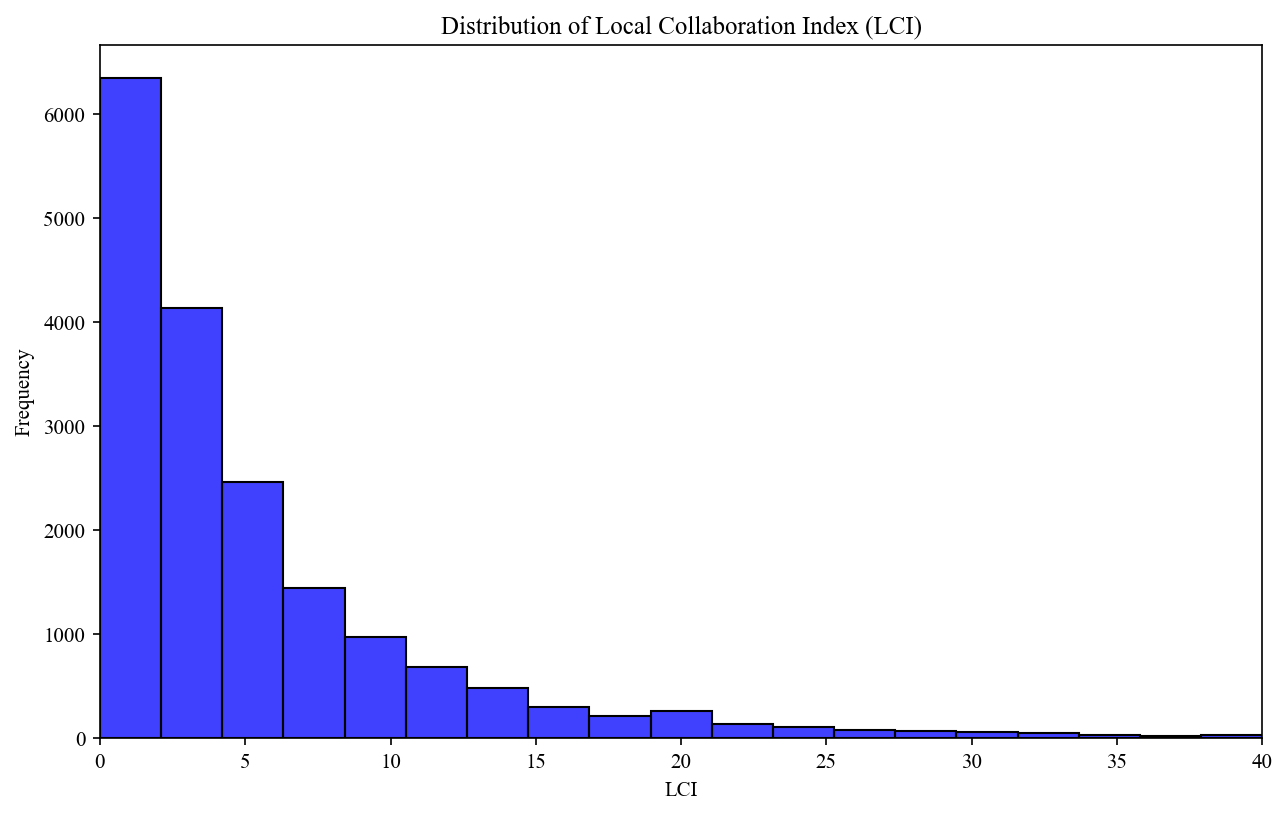

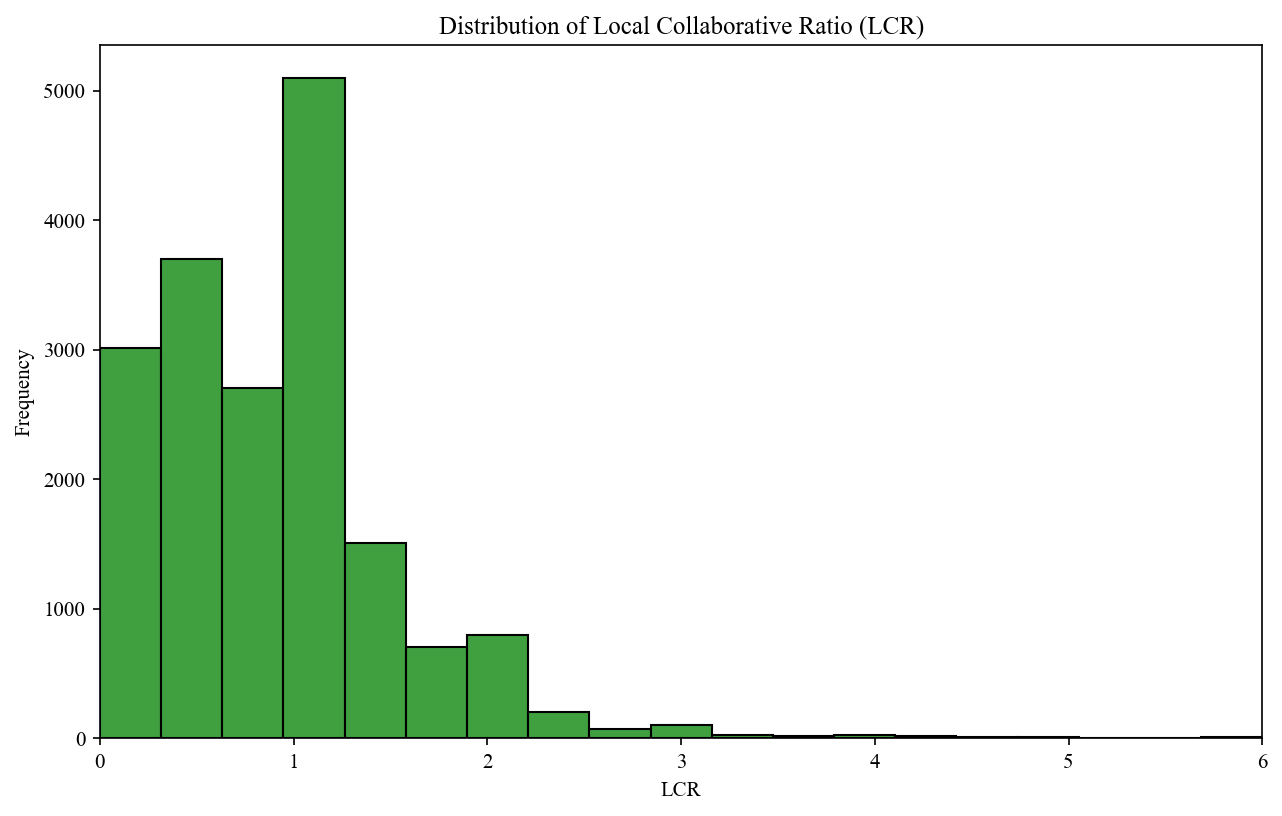

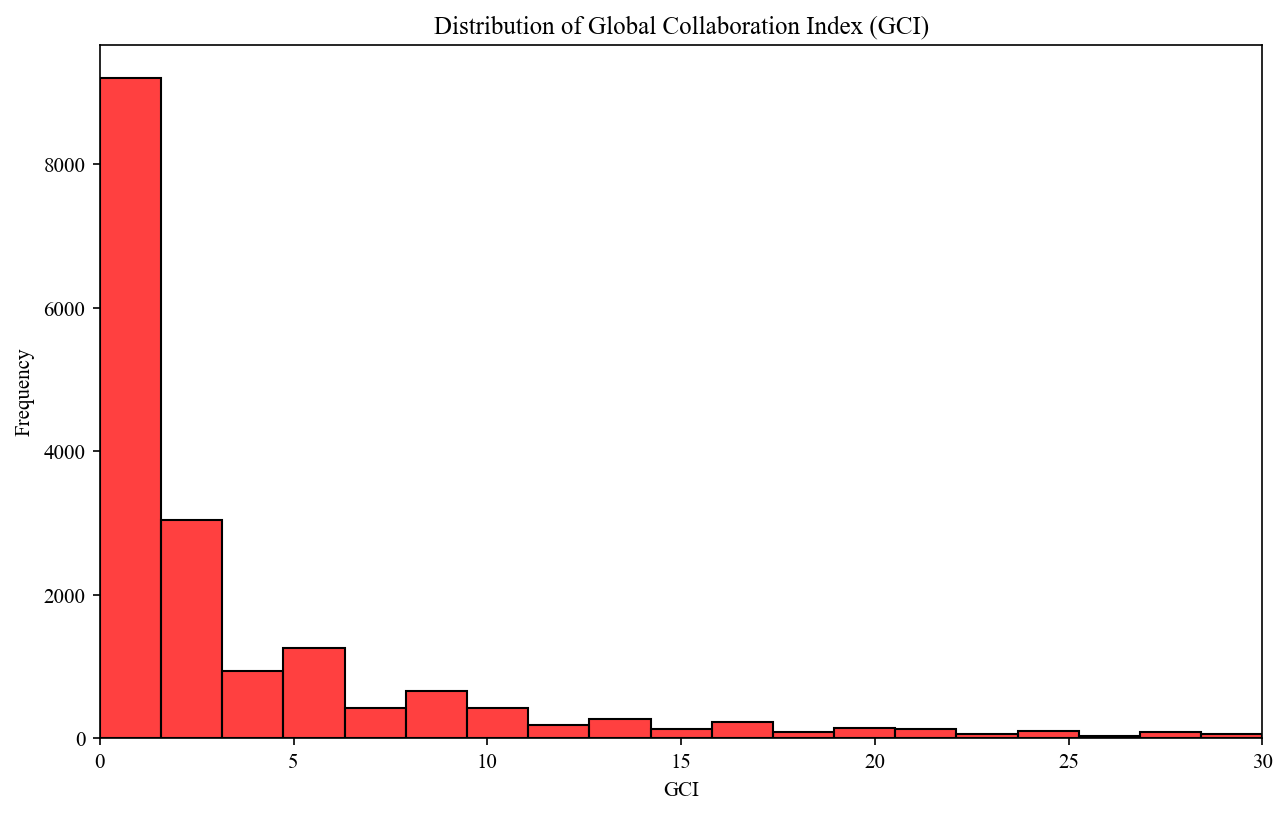

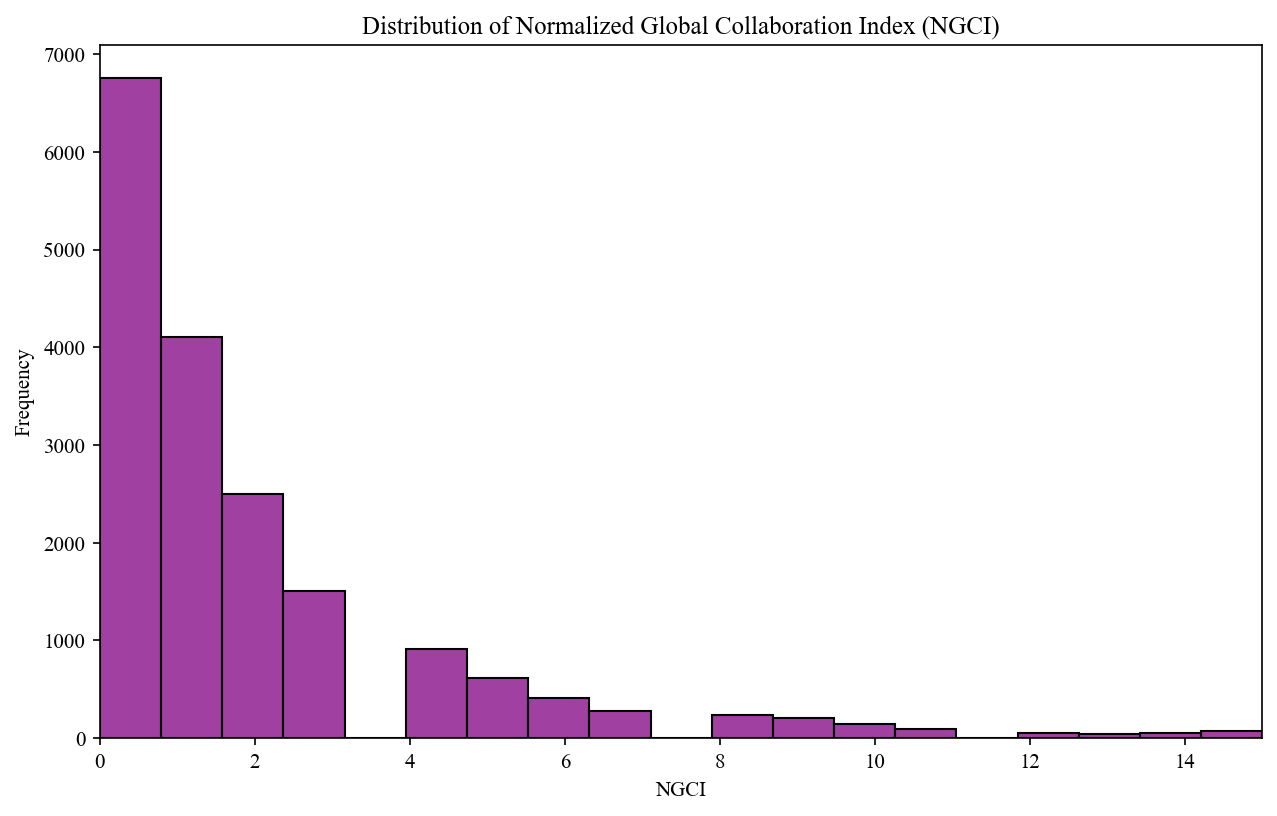

In [163]:
# LCI, LCR, GCI, NGCI versus total citations
import matplotlib.pyplot as plt
import seaborn as sns

# LCI Histogram
bins = np.linspace(0, 40, 20)
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='LCI', bins=bins, color='blue')
plt.title('Distribution of Local Collaboration Index (LCI)')
plt.xlabel('LCI')
plt.ylabel('Frequency')
plt.xlim(0, 40) # Limiting x-axis for better visibility as many values are low
plt.show()

# LCR Histogram
bins = np.linspace(0, 6, 20)
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='LCR', bins=bins, color='green')
plt.title('Distribution of Local Collaborative Ratio (LCR)')
plt.xlabel('LCR')
plt.ylabel('Frequency')
plt.xlim(0, 6) # LCR is a ratio, usually small
plt.show()

# GCI Histogram
bins = np.linspace(0, 30, 20)
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='GCI', bins=bins, color='red')
plt.title('Distribution of Global Collaboration Index (GCI)')
plt.xlabel('GCI')
plt.ylabel('Frequency')
plt.xlim(0, 30)
plt.show()

# NGCI Histogram
bins = np.linspace(0, 15, 20)
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='NGCI', bins=bins, color='purple')
plt.title('Distribution of Normalized Global Collaboration Index (NGCI)')
plt.xlabel('NGCI')
plt.ylabel('Frequency')
plt.xlim(0, 15)
plt.show()

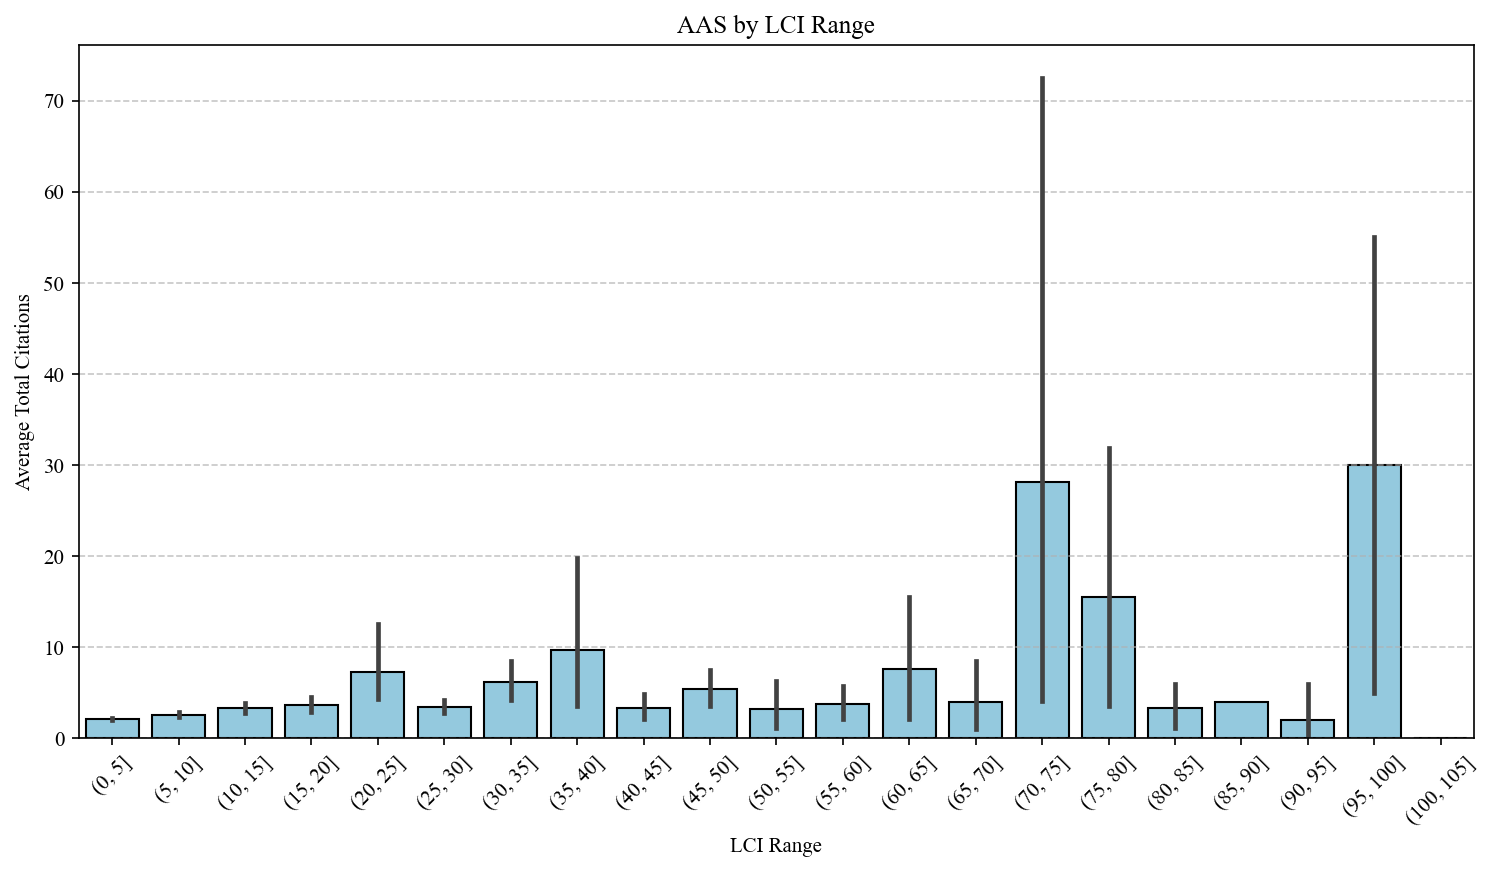

Correlation between LCI and Total Citations: 0.09


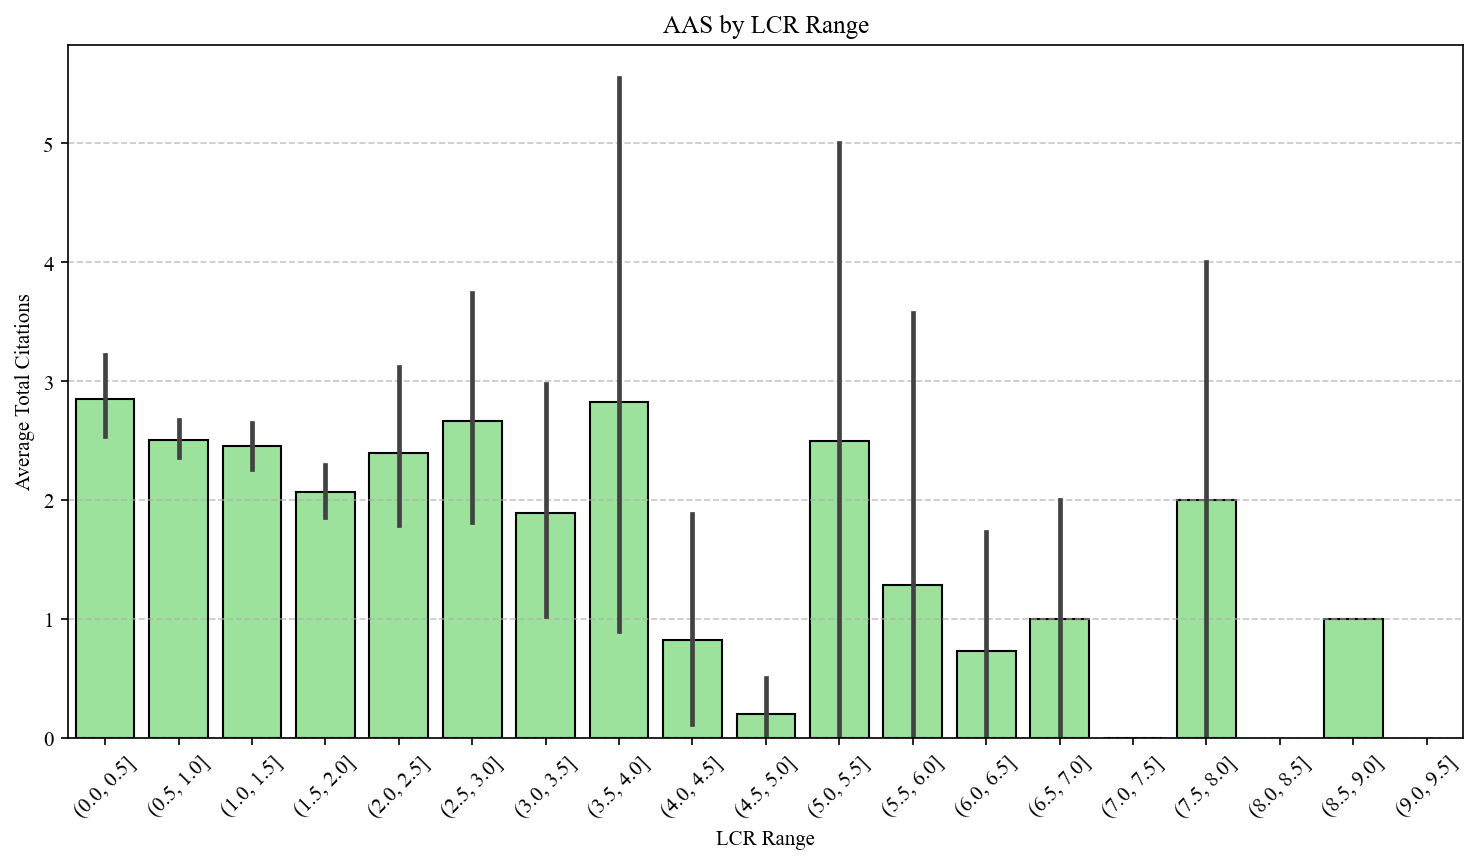

Correlation between LCR and Total Citations: 0.00


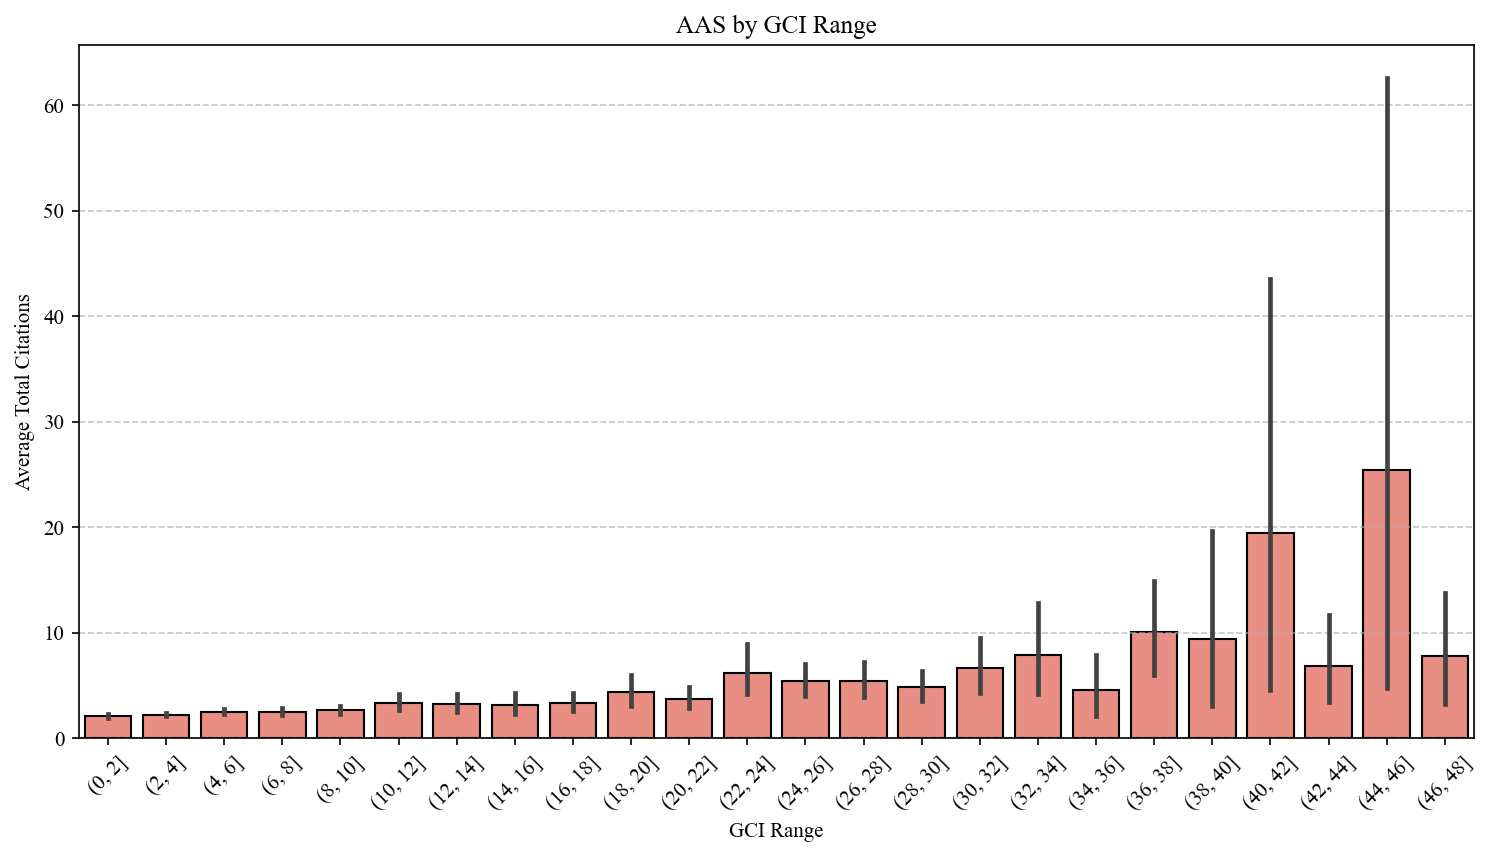

Correlation between GCI and Total Citations: 0.18


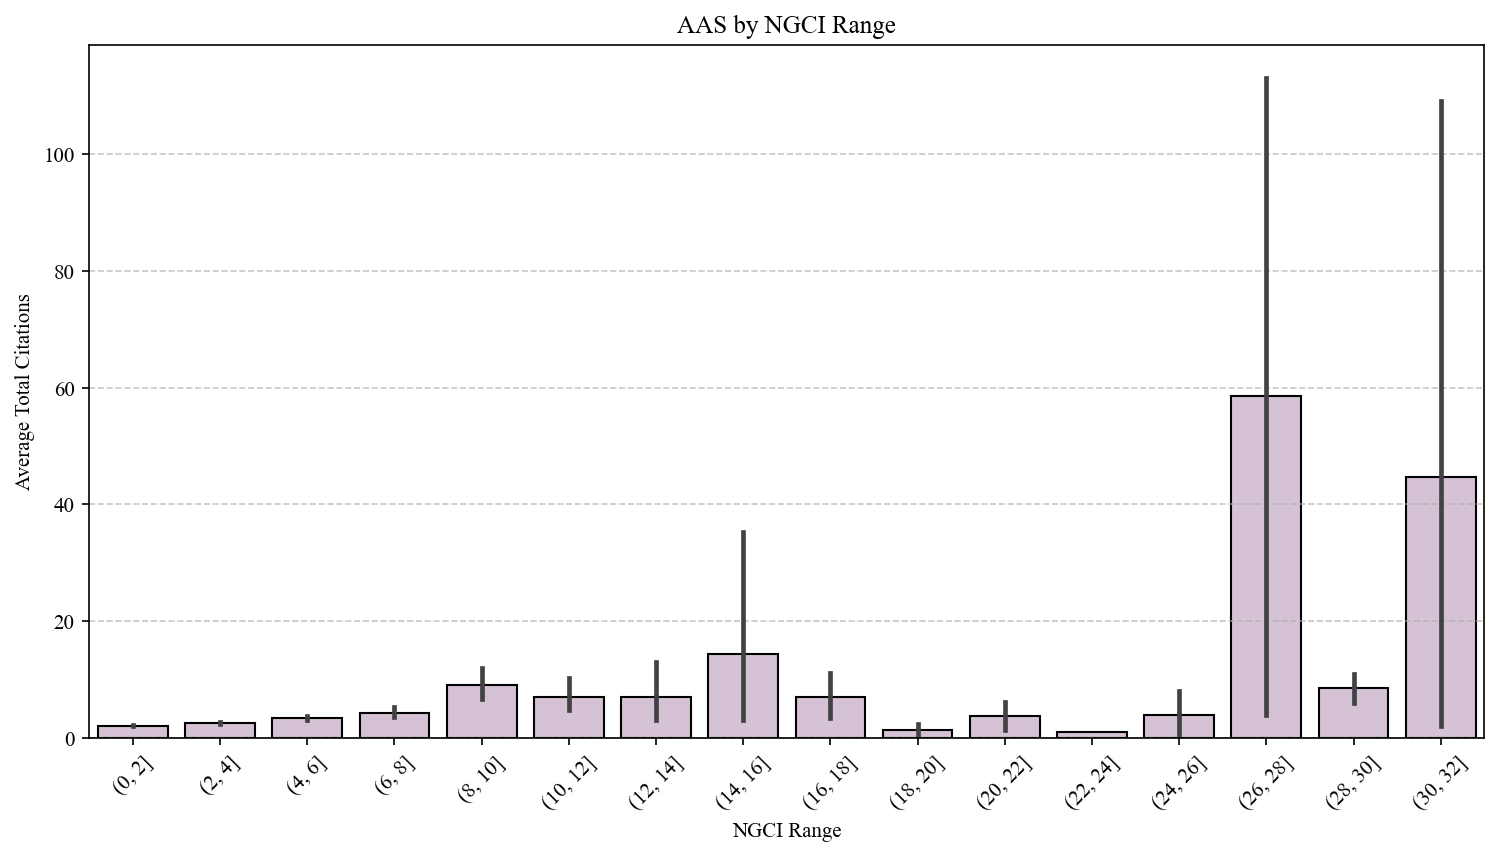

Correlation between NGCI and Total Citations: 0.18


In [43]:
# AAS
# Function to bin data and plot bar charts showing average citations
def plot_citations_bar(df, col, bins, title, color):
    # Create a copy to avoid SettingWithCopy warnings on the main dataframe
    temp_df = df.copy()
    
    # Create bin column
    bin_col = f'{col}_bins'
    temp_df[bin_col] = pd.cut(temp_df[col], bins=bins)
    
    plt.figure(figsize=(12, 6))
    
    # Plot bar chart: By default sns.barplot calculates the mean
    # We include error bars (default) to show the variability in citations
    sns.barplot(data=temp_df, x=bin_col, y='total_citations', color=color, edgecolor='black', errorbar=('ci', 95))
    
    plt.title(title)
    plt.xlabel(f'{col} Range')
    plt.ylabel('Average Total Citations')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# 1. LCI vs Average Total Citations
# Bins: 0 to 40 with step 2
plot_citations_bar(data, 'LCI', range(0, 110, 5), 
                   'AAS by LCI Range', 'skyblue')

correlation_lci = data['LCI'].corr(data['total_citations'])
print(f"Correlation between LCI and Total Citations: {correlation_lci:.2f}")

# 2. LCR vs Average Total Citations
# Bins: 0 to 6 with step 0.5
plot_citations_bar(data, 'LCR', np.arange(0, 10, 0.5), 
                   'AAS by LCR Range', 'lightgreen')

correlation_lcr = data['LCR'].corr(data['total_citations'])
print(f"Correlation between LCR and Total Citations: {correlation_lcr:.2f}")

# 3. GCI vs Average Total Citations
# Bins: 0 to 30 with step 2
plot_citations_bar(data, 'GCI', range(0, 50, 2), 
                   'AAS by GCI Range', 'salmon')

correlation_gci = data['GCI'].corr(data['total_citations'])
print(f"Correlation between GCI and Total Citations: {correlation_gci:.2f}")

# 4. NGCI vs Average Total Citations
# Bins: 0 to 15 with step 1
plot_citations_bar(data, 'NGCI', range(0, 34, 2), 
                   'AAS by NGCI Range', 'thistle')

correlation_ngci = data['NGCI'].corr(data['total_citations'])
print(f"Correlation between NGCI and Total Citations: {correlation_ngci:.2f}")


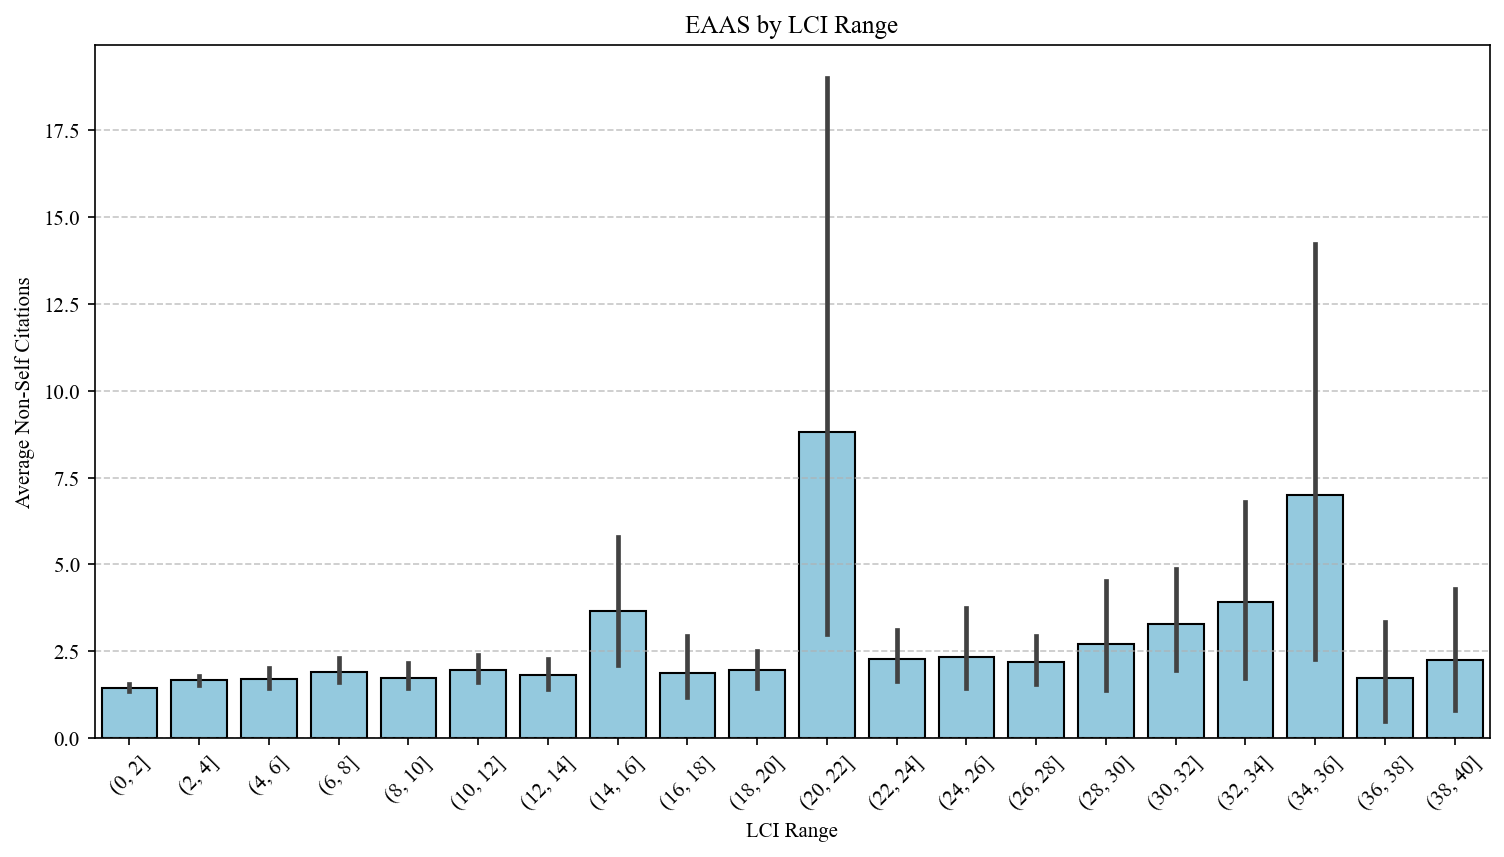

Correlation between LCI and Non-Self Citations: 0.07


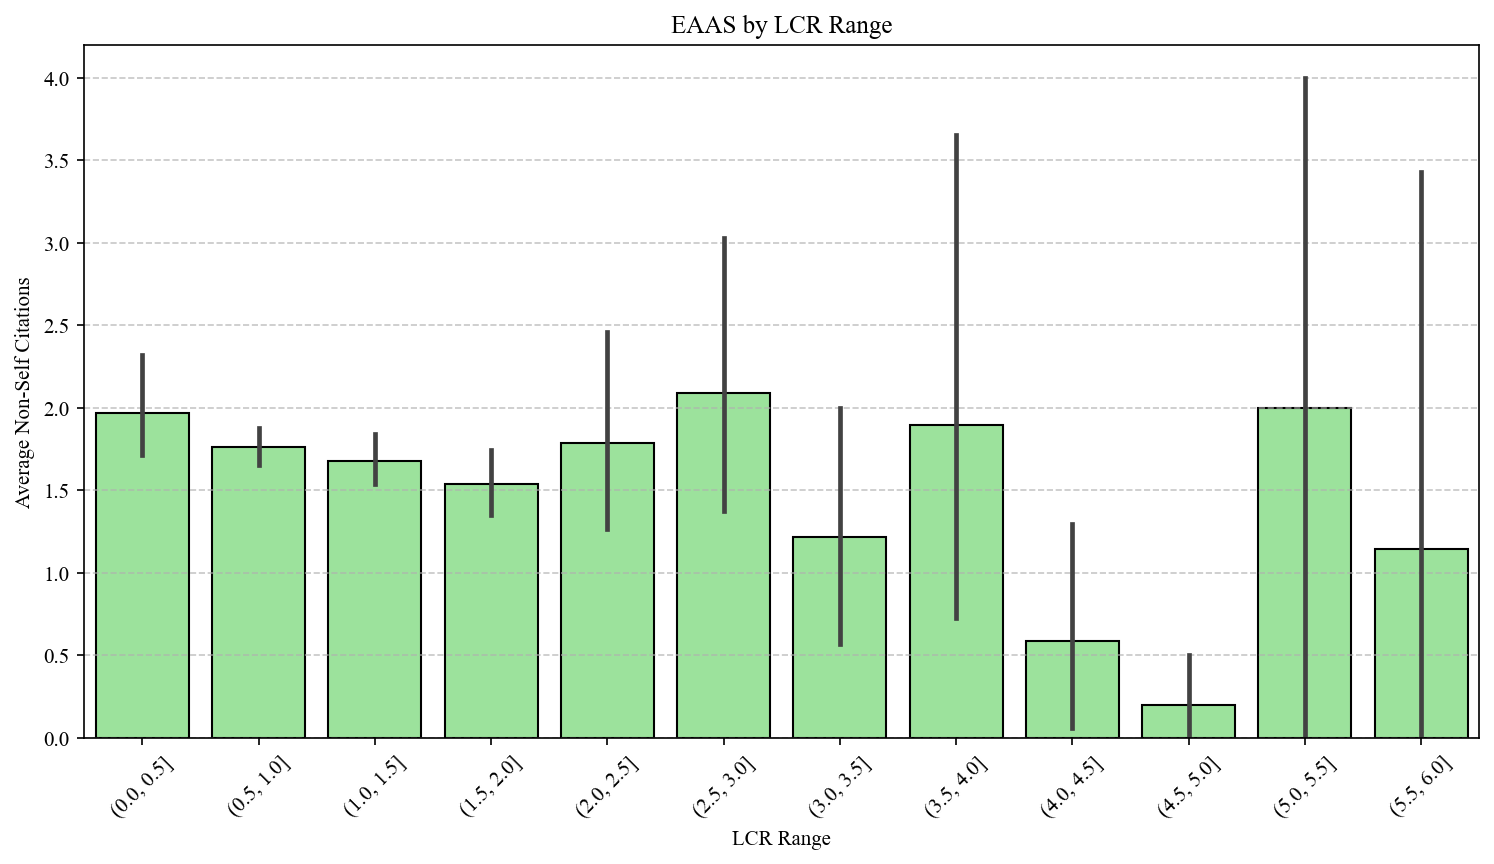

Correlation between LCR and Non-Self Citations: 0.01


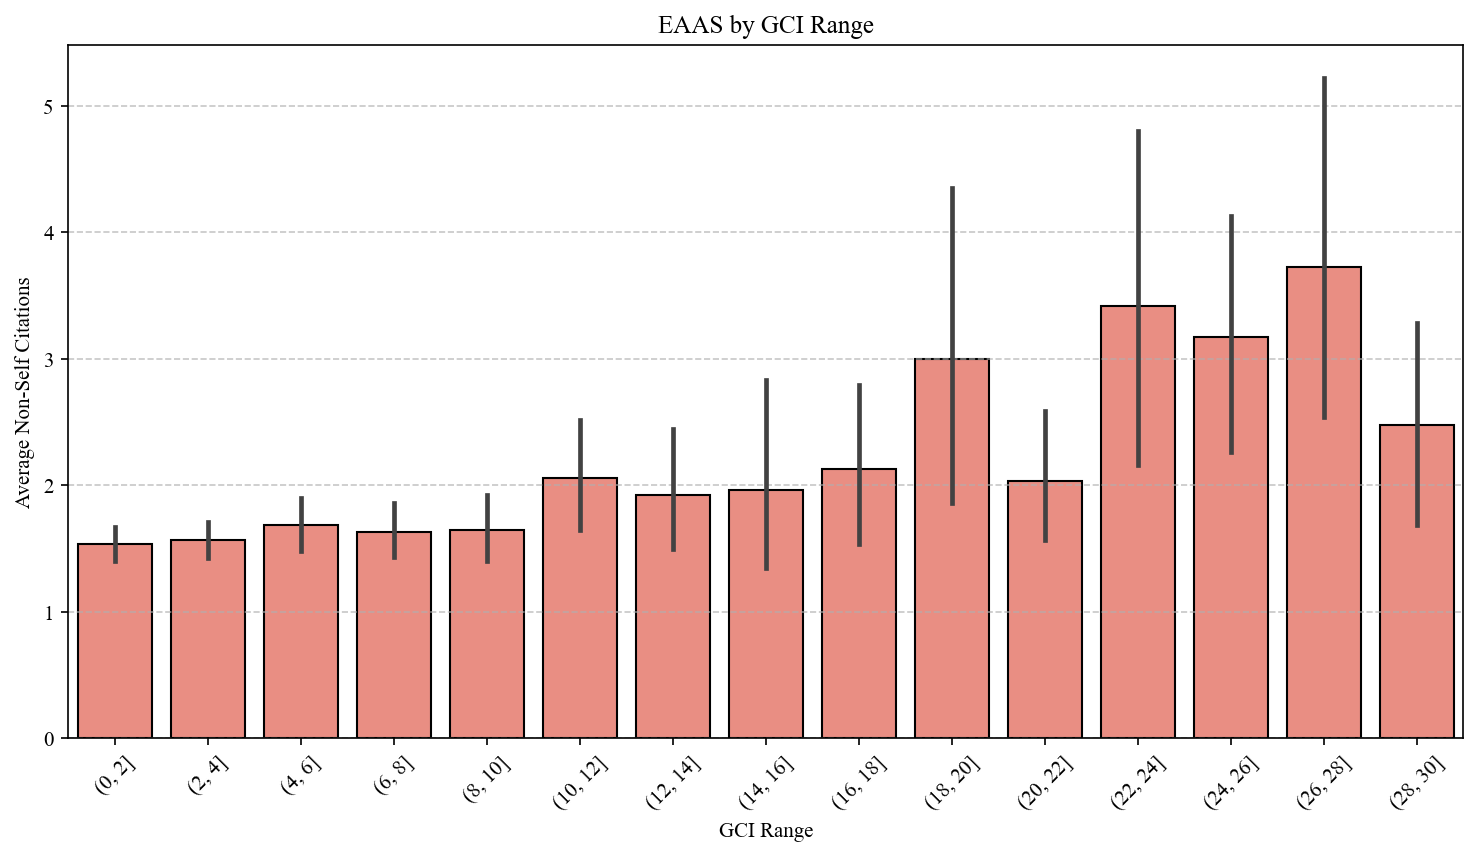

Correlation between GCI and Non-Self Citations: 0.16


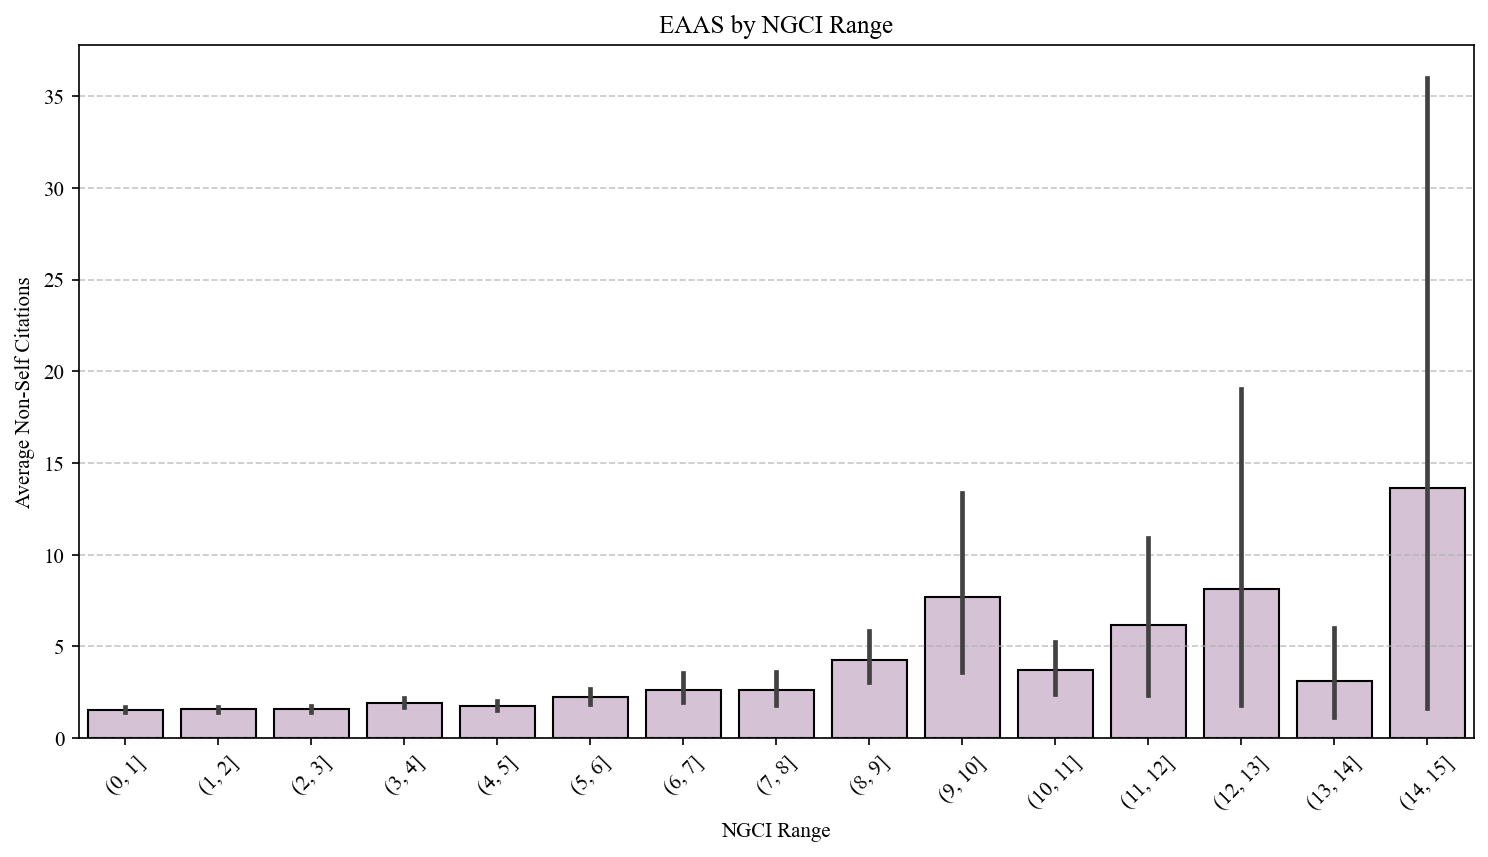

Correlation between NGCI and Non-Self Citations: 0.13


In [187]:
# EAAS
# Function to bin data and plot bar charts showing average citations
def plot_citations_bar(df, col, bins, title, color):
    # Create a copy to avoid SettingWithCopy warnings on the main dataframe
    temp_df = df.copy()
    
    # Create bin column
    bin_col = f'{col}_bins'
    temp_df[bin_col] = pd.cut(temp_df[col], bins=bins)
    
    plt.figure(figsize=(12, 6))
    
    # Plot bar chart: By default sns.barplot calculates the mean
    # We include error bars (default) to show the variability in citations
    sns.barplot(data=temp_df, x=bin_col, y='non_self_citations', color=color, edgecolor='black', errorbar=('ci', 95))
    
    plt.title(title)
    plt.xlabel(f'{col} Range')
    plt.ylabel('Average Non-Self Citations')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# 1. LCI vs Average Non-Self Citations
# Bins: 0 to 40 with step 2
plot_citations_bar(data, 'LCI', range(0, 42, 2), 
                   'EAAS by LCI Range', 'skyblue')

correlation_lci = data['LCI'].corr(data['non_self_citations'])
print(f"Correlation between LCI and Non-Self Citations: {correlation_lci:.2f}")

# 2. LCR vs Average Total Citations
# Bins: 0 to 6 with step 0.5
plot_citations_bar(data, 'LCR', np.arange(0, 6.5, 0.5), 
                   'EAAS by LCR Range', 'lightgreen')

correlation_lcr = data['LCR'].corr(data['non_self_citations'])
print(f"Correlation between LCR and Non-Self Citations: {correlation_lcr:.2f}")

# 3. GCI vs Average Total Citations
# Bins: 0 to 30 with step 2
plot_citations_bar(data, 'GCI', range(0, 32, 2), 
                   'EAAS by GCI Range', 'salmon')

correlation_gci = data['GCI'].corr(data['non_self_citations'])
print(f"Correlation between GCI and Non-Self Citations: {correlation_gci:.2f}")

# 4. NGCI vs Average Total Citations
# Bins: 0 to 15 with step 1
plot_citations_bar(data, 'NGCI', range(0, 16, 1), 
                   'EAAS by NGCI Range', 'thistle')

correlation_ngci = data['NGCI'].corr(data['non_self_citations'])
print(f"Correlation between NGCI and Non-Self Citations: {correlation_ngci:.2f}")

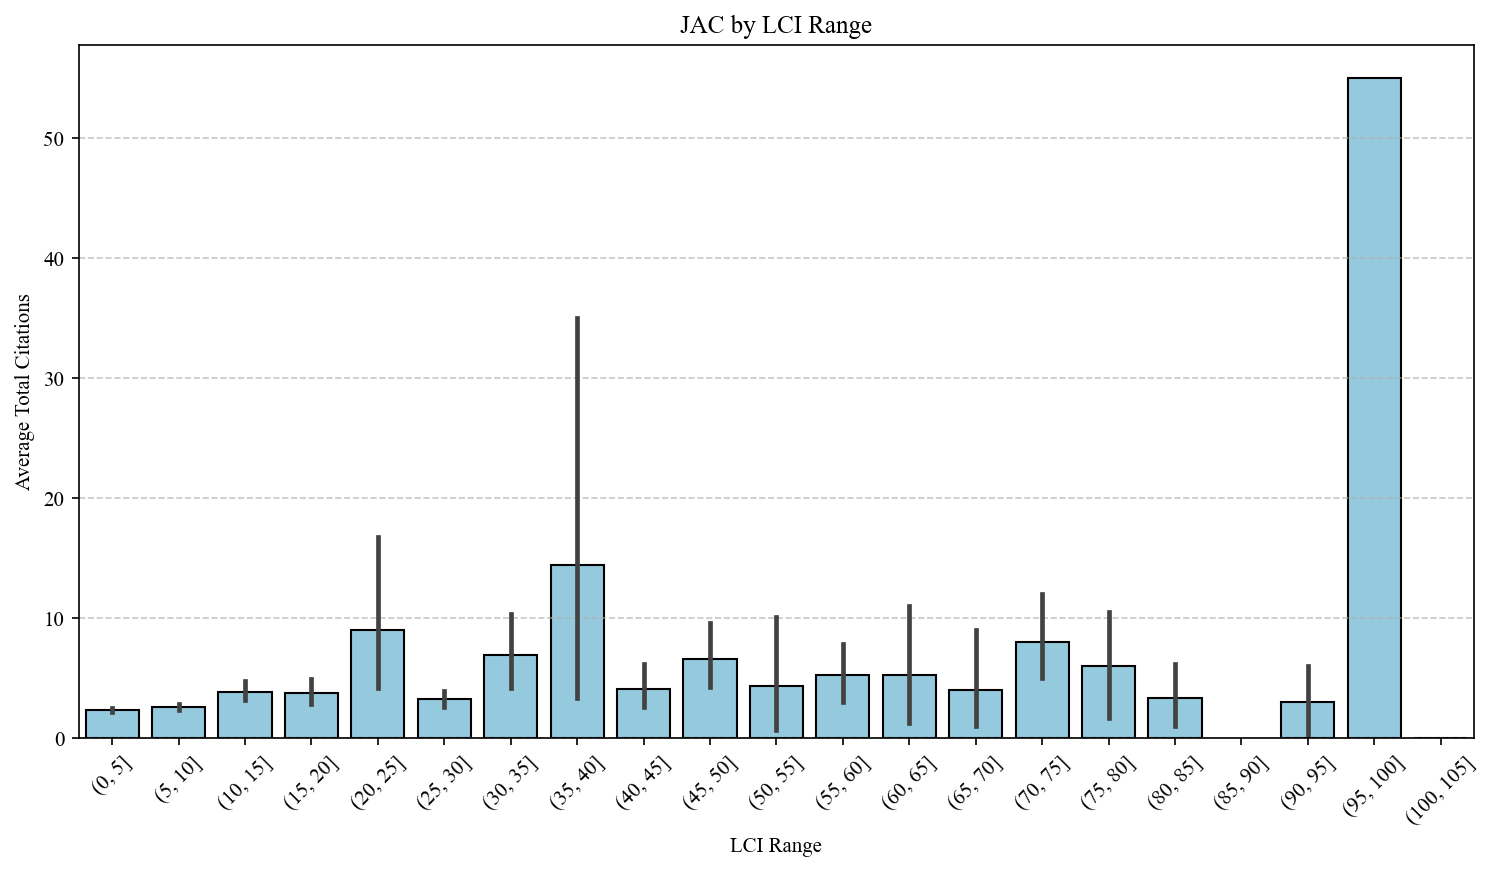

Correlation between LCI and Total Citations: 0.09


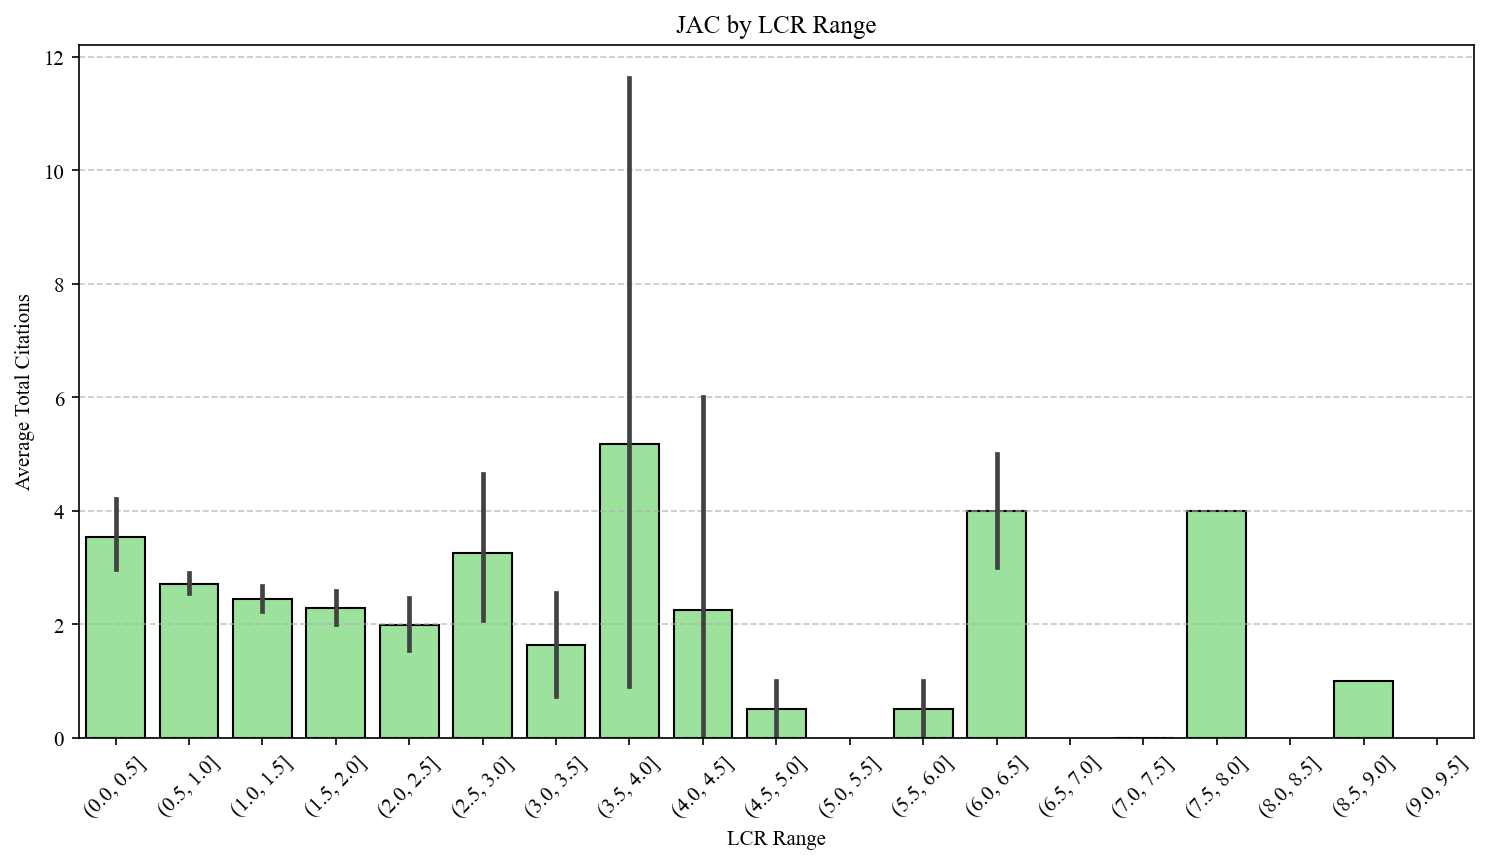

Correlation between LCR and Total Citations: -0.01


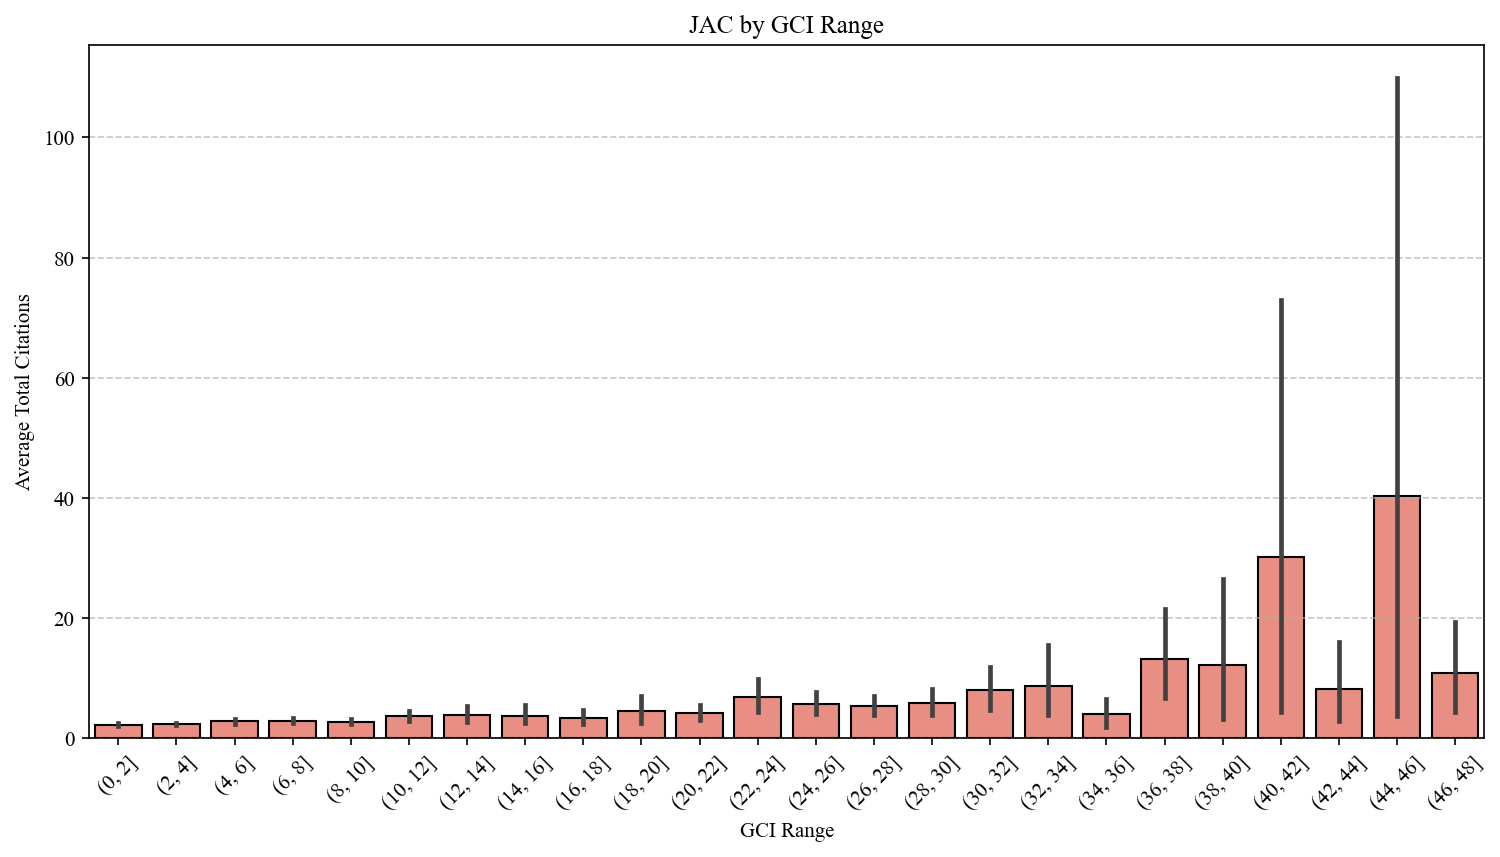

Correlation between GCI and Total Citations: 0.16


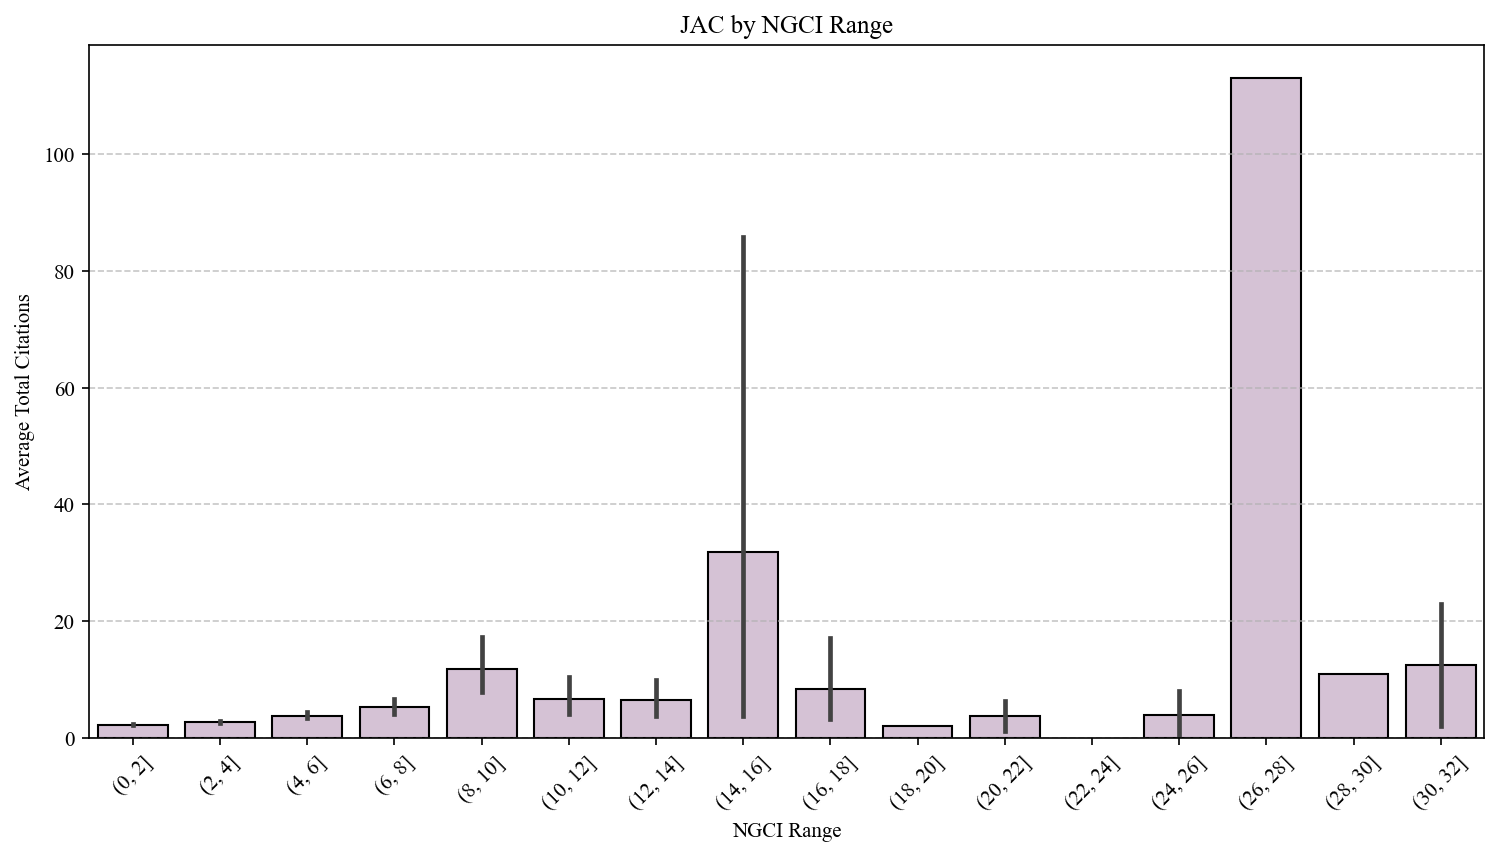

Correlation between NGCI and Total Citations: 0.20


In [188]:
# JAAS
# Function to bin data and plot bar charts showing average citations
def plot_citations_bar(df, col, bins, title, color):
    # Create a copy to avoid SettingWithCopy warnings on the main dataframe
    temp_df = df.copy()
    
    # Create bin column
    bin_col = f'{col}_bins'
    temp_df[bin_col] = pd.cut(temp_df[col], bins=bins)
    
    plt.figure(figsize=(12, 6))
    
    # Plot bar chart: By default sns.barplot calculates the mean
    # We include error bars (default) to show the variability in citations
    sns.barplot(data=temp_df, x=bin_col, y='total_citations', color=color, edgecolor='black', errorbar=('ci', 95))
    
    plt.title(title)
    plt.xlabel(f'{col} Range')
    plt.ylabel('Average Total Citations')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

masked_data = data[data['journal_flag'] == 1]

# 1. LCI vs Average Total Citations
# Bins: 0 to 40 with step 2
plot_citations_bar(masked_data, 'LCI', range(0, 110, 5), 
                   'JAC by LCI Range', 'skyblue')

correlation_lci = masked_data['LCI'].corr(masked_data['total_citations'])
print(f"Correlation between LCI and Total Citations: {correlation_lci:.2f}")

# 2. LCR vs Average Total Citations
# Bins: 0 to 6 with step 0.5
plot_citations_bar(masked_data, 'LCR', np.arange(0, 10, 0.5), 
                   'JAC by LCR Range', 'lightgreen')

correlation_lcr = masked_data['LCR'].corr(masked_data['total_citations'])
print(f"Correlation between LCR and Total Citations: {correlation_lcr:.2f}")

# 3. GCI vs Average Total Citations
# Bins: 0 to 30 with step 2
plot_citations_bar(masked_data, 'GCI', range(0, 50, 2), 
                   'JAC by GCI Range', 'salmon')

correlation_gci = masked_data['GCI'].corr(masked_data['total_citations'])
print(f"Correlation between GCI and Total Citations: {correlation_gci:.2f}")

# 4. NGCI vs Average Total Citations
# Bins: 0 to 15 with step 1
plot_citations_bar(masked_data, 'NGCI', range(0, 34, 2), 
                   'JAC by NGCI Range', 'thistle')

correlation_ngci = masked_data['NGCI'].corr(masked_data['total_citations'])
print(f"Correlation between NGCI and Total Citations: {correlation_ngci:.2f}")


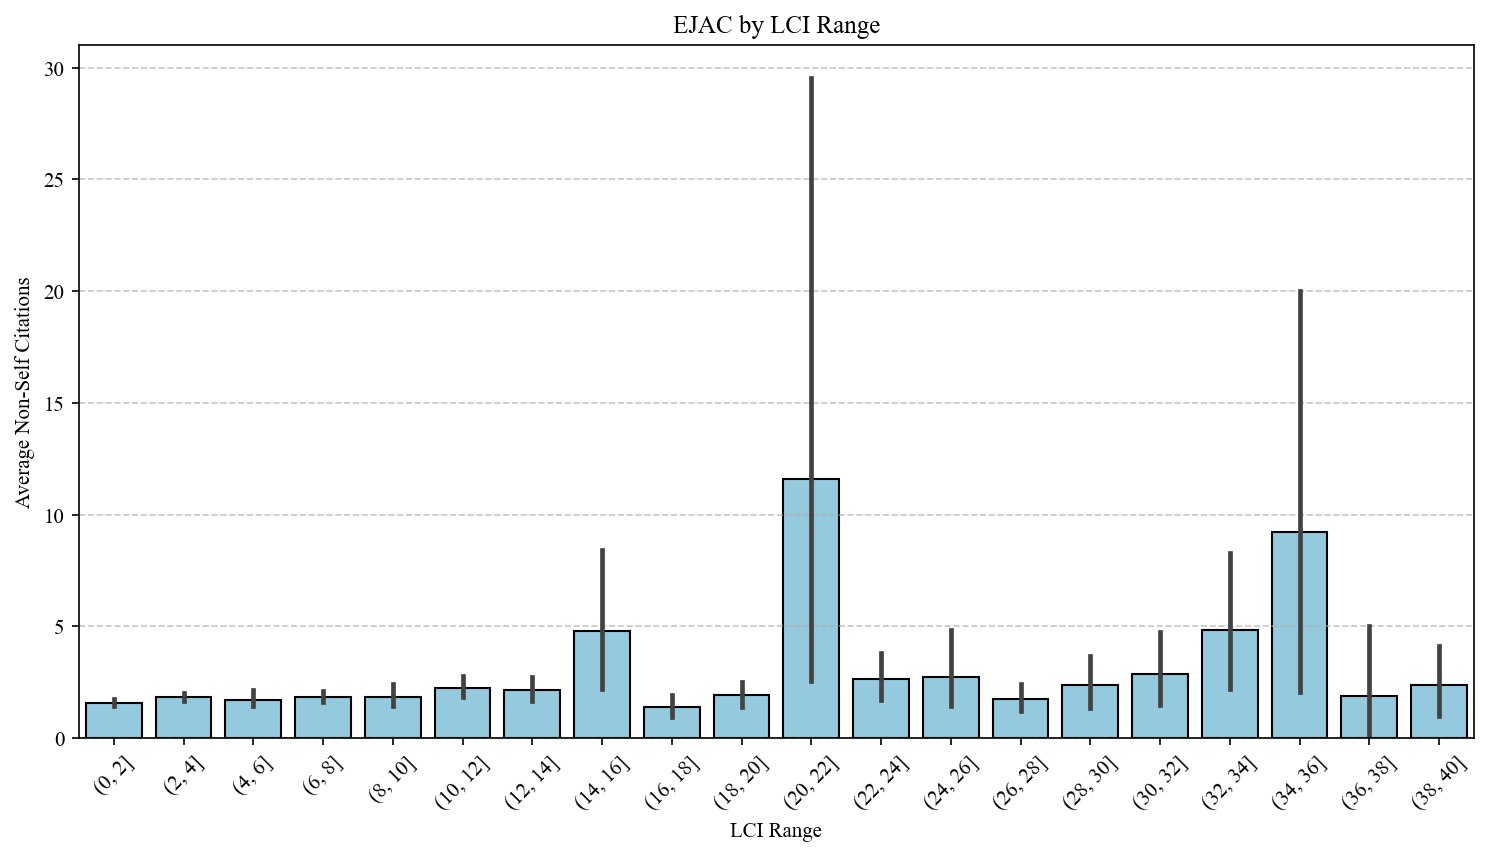

Correlation between LCI and Non-Self Citations: 0.06


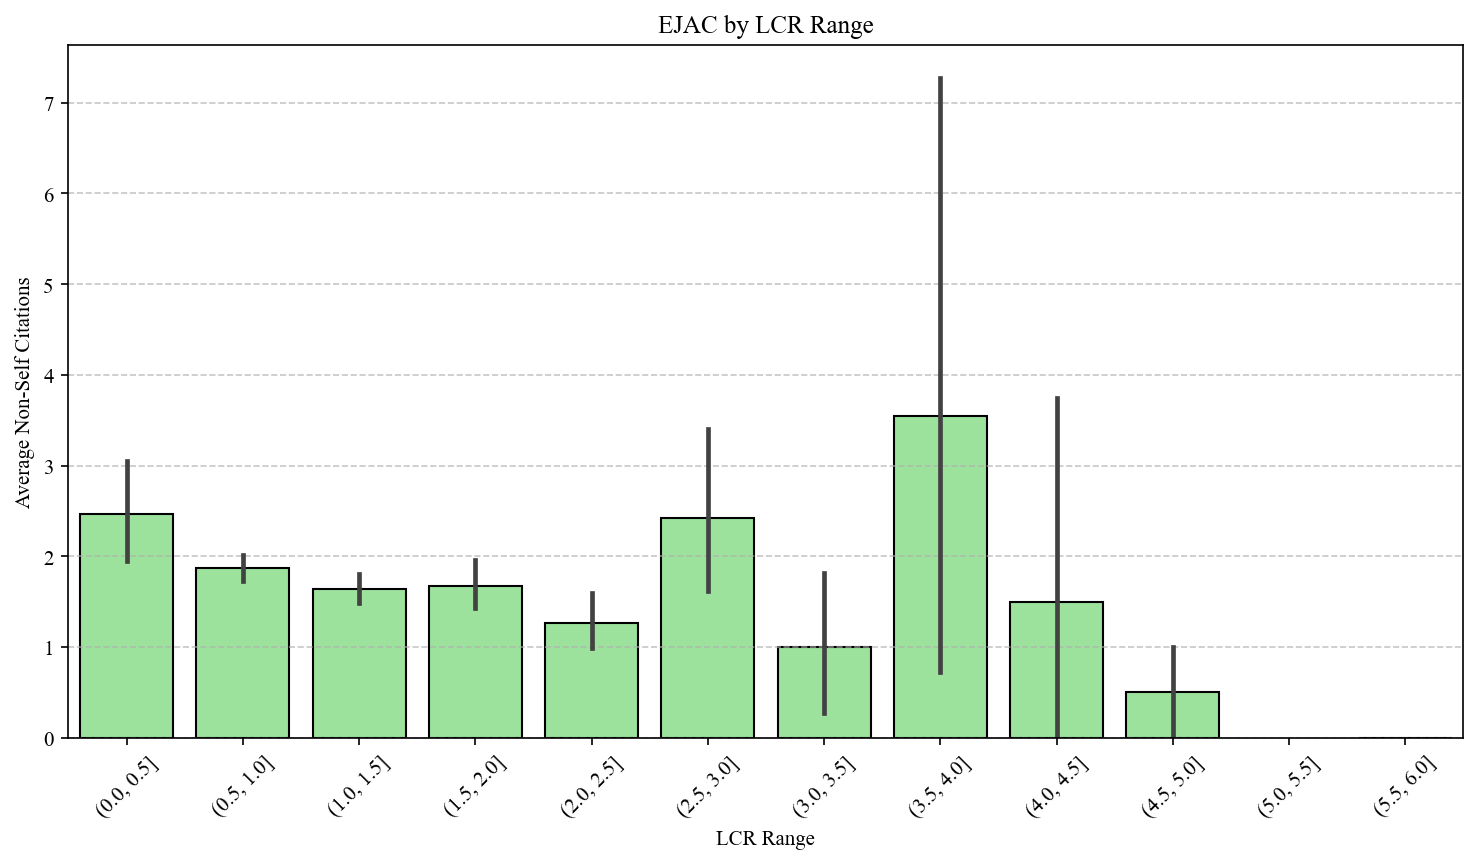

Correlation between LCR and Non-Self Citations: -0.01


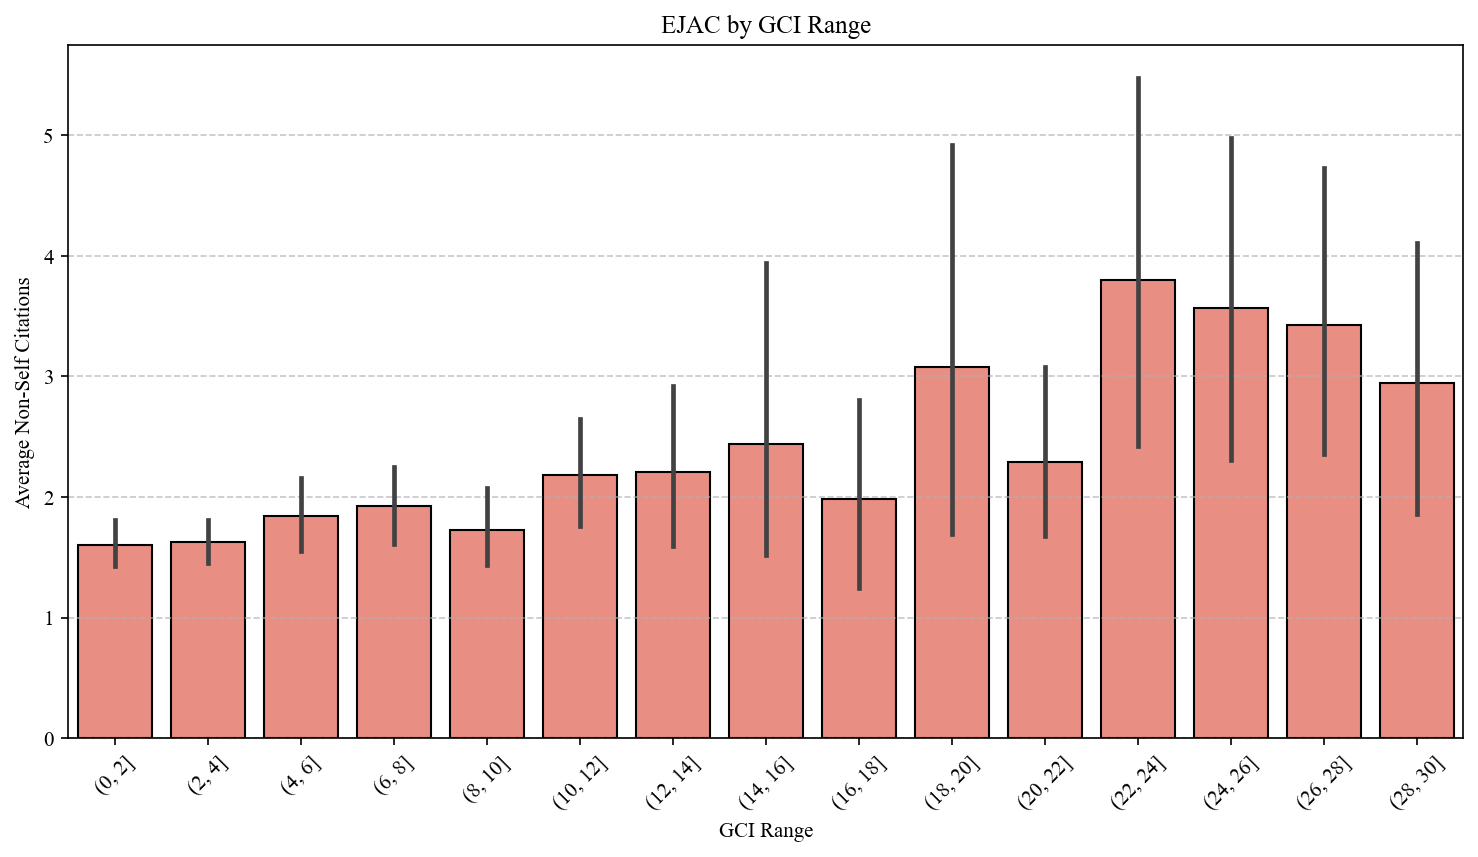

Correlation between GCI and Non-Self Citations: 0.14


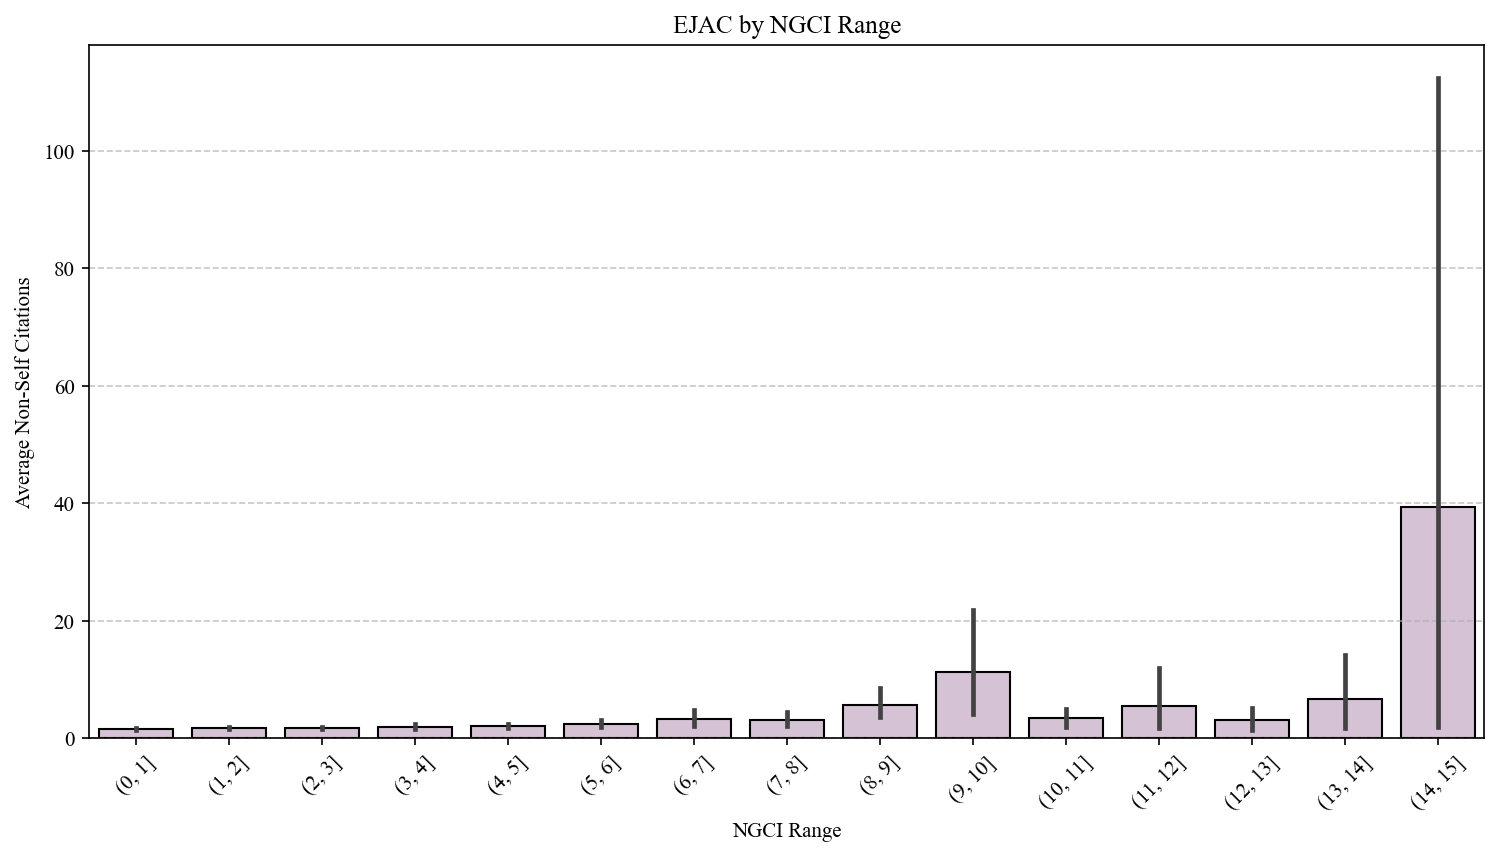

Correlation between NGCI and Non-Self Citations: 0.14


In [189]:
# EJAC
# Function to bin data and plot bar charts showing average citations
def plot_citations_bar(df, col, bins, title, color):
    # Create a copy to avoid SettingWithCopy warnings on the main dataframe
    temp_df = df.copy()
    
    # Create bin column
    bin_col = f'{col}_bins'
    temp_df[bin_col] = pd.cut(temp_df[col], bins=bins)
    
    plt.figure(figsize=(12, 6))
    
    # Plot bar chart: By default sns.barplot calculates the mean
    # We include error bars (default) to show the variability in citations
    sns.barplot(data=temp_df, x=bin_col, y='non_self_citations', color=color, edgecolor='black', errorbar=('ci', 95))
    
    plt.title(title)
    plt.xlabel(f'{col} Range')
    plt.ylabel('Average Non-Self Citations')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

masked_data = data[data['journal_flag'] == 1]

# 1. LCI vs Average Total Citations
# Bins: 0 to 40 with step 2
plot_citations_bar(masked_data, 'LCI', range(0, 42, 2), 
                   'EJAC by LCI Range', 'skyblue')

correlation_lci = masked_data['LCI'].corr(masked_data['non_self_citations'])
print(f"Correlation between LCI and Non-Self Citations: {correlation_lci:.2f}")

# 2. LCR vs Average Total Citations
# Bins: 0 to 6 with step 0.5
plot_citations_bar(masked_data, 'LCR', np.arange(0, 6.5, 0.5), 
                   'EJAC by LCR Range', 'lightgreen')

correlation_lcr = masked_data['LCR'].corr(masked_data['non_self_citations'])
print(f"Correlation between LCR and Non-Self Citations: {correlation_lcr:.2f}")

# 3. GCI vs Average Total Citations
# Bins: 0 to 30 with step 2
plot_citations_bar(masked_data, 'GCI', range(0, 32, 2), 
                   'EJAC by GCI Range', 'salmon')

correlation_gci = masked_data['GCI'].corr(masked_data['non_self_citations'])
print(f"Correlation between GCI and Non-Self Citations: {correlation_gci:.2f}")

# 4. NGCI vs Average Total Citations
# Bins: 0 to 15 with step 1
plot_citations_bar(masked_data, 'NGCI', range(0, 16, 1), 
                   'EJAC by NGCI Range', 'thistle')

correlation_ngci = masked_data['NGCI'].corr(masked_data['non_self_citations'])
print(f"Correlation between NGCI and Non-Self Citations: {correlation_ngci:.2f}")

In [39]:
# Telescopes
list_of_telescopes = [
    'HST',
    'CSST',
    'Chandra',
    'Spitzer',
    'JWST',
    'VLT',
    'ALMA',
    'Keck',
    'Subaru',
    'Euclid',
    'Vera C. Rubin Observatory',
    'SDSS',
    'GAIA',
    'ZWICKY',
    'LIGO',
    'LISA',
    'Fermi',
    'Swift',
    'TESS',
    'NICER',
    'NuSTAR',
    'XMM-Newton',
    'INTEGRAL',
    'SPHEREx',
    'SVOM',
    'AstroSat',
    'HXMT',
    'XRISM',
    'Einstein Probe',
    'IXPE',
    'XPoSat',
    'IRIS',
    'CUTE',
    'GLIDE',
    'NEOSSat',
    'CHEOPS',
    'DAMPE',
    'CALCET',
    'LSST',
    'RST',
    'FAST'
]

# Map canonical names (keys) to a list of aliases/long names/instruments to search for.
# The search will check for the key AND any values in the list.
telescope_aliases = {
    'HST': ['Hubble Space Telescope', 'WFC3', 'Wide Field Camera 3', 'ACS', 'Advanced Camera for Surveys', 'Cosmic Origins Spectrograph', 'STIS', 'Space Telescope Imaging Spectrograph'],
    'CSST': ['China Space Station Telescope'],
    'JWST': ['James Webb Space Telescope', 'NIRCam', 'Near Infrared Camera', 'MIRI', 'Mid-Infrared Instrument'],
    'VLT': ['Very Large Telescope'],
    'ALMA': ['Atacama Large Millimeter/submillimeter Array'],
    'SDSS': ['Sloan Digital Sky Survey'],
    'LIGO': ['Laser Interferometer Gravitational-Wave Observatory'],
    'LISA': ['Laser Interferometer Space Antenna'],
    'ZWICKY': ['Zwicky Transient Facility'],
    'Chandra': ['Chandra X-ray Observatory'],
    'Spitzer': ['Spitzer Space Telescope'],
    'Fermi': ['Fermi Gamma-ray Space Telescope'],
    'Swift': ['Neil Gehrels Swift Observatory'],
    'TESS': ['Transiting Exoplanet Survey Satellite'],
    'NICER': ['Neutron star Interior Composition Explorer'],
    'GAIA': ['Global Astrometric Interferometer for Astrophysics'],
    'NuSTAR': ['Nuclear Spectroscopic Telescope Array'],
    'XMM-Newton': ['X-ray Multi-Mirror Mission - Newton'],
    'INTEGRAL': ['INTErnational Gamma-Ray Astrophysics Laboratory'],
    'SPHEREx': ['Spectro-Photometer for the History of the Universe, Epoch of Reionization, and Ices Explorer'],
    'SVOM': ['Space-based multi-band astronomical Variable Objects Monitor'],
    'AstroSat': ['AstroSat Space Observatory'],
    'HXMT': ['Hard X-ray Modulation Telescope'],
    'XRISM': ['X-ray Imaging and Spectroscopy Mission'],
    'Einstein Probe': ['Einstein Probe X-ray Observatory'],
    'IXPE': ['Imaging X-ray Polarimetry Explorer'],
    'XPoSat': ['X-ray Polarimeter Satellite'],
    'IRIS': ['Interface Region Imaging Spectrograph'],
    'CUTE': ['Colorado Ultraviolet Transit Experiment'],
    'GLIDE': ['Carruthers Geocorona Observatory'],
    'NEOSSat': ['Near-Earth Object Surveillance Satellite'],
    'CHEOPS': ['Characterising Exoplanet Satellite'],
    'DAMPE': ['DArk Matter Particle Explorer'],
    'CALCET': ['CALorimetric Electron Telescope'],
    'RST': ['Roman Space Telescope', 'Nancy Grace Roman Space Telescope'],
    'Vera C. Rubin Observatory': ['Vera Rubin', 'Rubin Observatory'],
    'LSST': ['Legacy Survey of Space and Time'],
    'FAST': ['Five-hundred-meter Aperture Spherical Telescope', 'Five hunder meter Aperture Spherical Telescope', 'Five-hunder-meter Aperture Spherical Telescope', 'Five hundred meter Aperture Spherical Telescope']
}

# Create a flattened search list of tuples: (search_term, canonical_name)
search_patterns = []
for canonical in list_of_telescopes:
    # Add the canonical name itself
    search_patterns.append((canonical, canonical))
    # Add aliases if they exist
    if canonical in telescope_aliases:
        for alias in telescope_aliases[canonical]:
            search_patterns.append((alias, canonical))

data['telescope'] = np.nan

for i in range(len(data)):
    # Combine title and abstract for text search
    text_to_search = ""
    if isinstance(data.at[i, 'title'], str):
        text_to_search += data.at[i, 'title'] + " "
    if isinstance(data.at[i, 'abstract'], str):
        text_to_search += data.at[i, 'abstract']
    
    text_to_search = text_to_search.lower()
    
    # Check against all patterns
    for search_term, canonical_name in search_patterns:
        if search_term.lower() in text_to_search:
            data.at[i, 'telescope'] = canonical_name
            break # Stop after finding the first match


In [40]:
mask = data['telescope'].notna()
masked_data = data[mask]
masked_data

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,smart_keywords_2,latex_countries,affil_countries,all_countries,first_author,LCI,LCR,GCI,NGCI,telescope
0,Insights on Galaxy Evolution from Interpretabl...,Galaxy appearances reveal the physics of how t...,['John F. Wu'],4.0,10.0,2.0,arxiv.org/pdf/2501.00089,Astrophysics of Galaxies,['Machine Learning'],AAS Journals,...,"['Galaxies (573)', 'Astronomy image processing...",NaN,"[United States, United States, United States]","[United States, United States, United States]",[United States],3.0,3.000000,0.0,0.0,RST
1,X-ray reverberation black hole mass and distan...,We fit X-ray reverberation models to Rossi X-r...,"[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nat...",16.0,18.0,1.0,arxiv.org/pdf/2501.12788,High Energy Astrophysical Phenomena,NaN,NaN,...,['powered by accretion of matter from a compan...,"United Kingdom, United Kingdom, United Kingdom...",[],"[United Kingdom, United Kingdom, United Kingdo...",[United Kingdom],3.0,0.428571,4.0,4.0,RST
2,The TES-based Cryogenic AntiCoincidence Detect...,The Cryogenic AntiCoincidence Detector (CryoAC...,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...",17.0,8.0,0.0,arxiv.org/pdf/2501.12781,Instrumentation and Methods for Astrophysics,NaN,IEEE Transactions on Applied Superconductivity...,...,[],NaN,"[Italy, Italy, Italy, Italy, Italy, Italy, Ita...","[Italy, Italy, Italy, Italy, Italy, Italy, Ita...",[Italy],21.0,1.312500,0.0,0.0,INTEGRAL
3,Massive star clusters in the gamma-ray sky: th...,Massive Star Clusters (SCs) have been proposed...,"['Giada Peron', 'Giovanni Morlino', 'Stefano G...",3.0,5.0,1.0,arxiv.org/pdf/2501.12767,High Energy Astrophysical Phenomena,NaN,NaN,...,"['Cosmic Rays 1', 'HII regions', 'Gamma rays',...","Italy, France",[],"[Italy, France]",[Italy],1.0,0.250000,1.0,1.0,Fermi
4,The Impact of Bar-induced Non-Circular Motions...,We study the impact of bar-induced non-circula...,"['Jie Liu', 'Zhi Li', 'Juntai Shen']",12.0,19.0,1.0,arxiv.org/pdf/2501.12760,Astrophysics of Galaxies,NaN,NaN,...,['galaxies: rotation curve - galaxies: fundame...,Germany,"[China, China, China, China, China, China]","[China, China, China, China, China, China]",[China],6.0,2.000000,0.0,0.0,ALMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18654,Searching for Periodicity in FRB 20240114A,"FRB 20240114A is extraordinarily active, and t...",['J. I. Katz'],2.0,5.0,0.0,arxiv.org/pdf/2512.24936,High Energy Astrophysical Phenomena,NaN,NaN,...,['radio transient sources 1'],Israel,[],[Israel],[Israel],1.0,1.000000,0.0,0.0,RST
18656,Multi-Frequency Study of FRB20201124A with the...,We present results from multi-epoch observatio...,"['C. Dudeja', 'J. Roy', 'U. Panda', 'S. Bhatta...",11.0,17.0,1.0,arxiv.org/pdf/2512.24978,High Energy Astrophysical Phenomena,NaN,NaN,...,[],"India, India, India, India",[],"[India, India, India, India]",[India],4.0,1.000000,0.0,0.0,RST
18657,Distributions of wide binary stars in theory a...,"Using the censored catalog of 103,169 resolved...",['Valeri V. Makarov'],7.0,13.0,1.0,arxiv.org/pdf/2512.25002,Solar and Stellar Astrophysics,NaN,NaN,...,[],United States,[],[United States],[United States],1.0,1.000000,0.0,0.0,GAIA
18658,Towards precision cosmology with Voids x CMB c...,We construct and validate a set of multi-purpo...,"['Mar Pérez Sar', 'Carlos Hernández Monteagudo...",8.0,19.0,1.0,arxiv.org/pdf/2512.25040,Cosmology and Nongalactic Astrophysics,NaN,NaN,...,['Cosmology: Large-scale structure - Cosmic mi...,"Spain, Spain, Hungary, Hungary, France, United...",[],"[Spain, Spain, Hungary, Hungary, France, Unite...",[Spain],2.0,0.500000,4.0,3.0,RST


In [41]:
# Top 10 telescope counts
telescope_counts = masked_data['telescope'].value_counts().head(10)
print(telescope_counts)

telescope
RST        4655
JWST       1301
GAIA        747
HST         715
FAST        518
ALMA        432
TESS        427
Fermi       392
SDSS        381
Chandra     301
Name: count, dtype: int64


In [42]:
# LCI, LCR, GCI, NGCI calculations for the unique telescopes
telescope_lci_totals = defaultdict(int)
telescope_lcr_totals = defaultdict(float)
telescope_gci_totals = defaultdict(int)
telescope_ngci_totals = defaultdict(int)
telescope_paper_counts = defaultdict(int)

for index, row in masked_data.iterrows():
    telescope = row['telescope']
    lci = row['LCI']
    lcr = row['LCR']
    gci = row['GCI']
    ngci = row['NGCI']
    
    if pd.notna(telescope):
        if pd.notna(lci):
            telescope_lci_totals[telescope] += lci
        if pd.notna(lcr):
            telescope_lcr_totals[telescope] += lcr
        if pd.notna(gci):
            telescope_gci_totals[telescope] += gci
        if pd.notna(ngci):
            telescope_ngci_totals[telescope] += ngci
        telescope_paper_counts[telescope] += 1
# Calculate average metrics per telescope
telescope_avg_lci = {}
telescope_avg_lcr = {}
telescope_avg_gci = {}
telescope_avg_ngci = {}
for telescope in telescope_paper_counts:
    paper_count = telescope_paper_counts[telescope]
    if paper_count > 0:
        if telescope in telescope_lci_totals:
            telescope_avg_lci[telescope] = telescope_lci_totals[telescope] / paper_count
        if telescope in telescope_lcr_totals:
            telescope_avg_lcr[telescope] = telescope_lcr_totals[telescope] / paper_count
        if telescope in telescope_gci_totals:
            telescope_avg_gci[telescope] = telescope_gci_totals[telescope] / paper_count
        if telescope in telescope_ngci_totals:
            telescope_avg_ngci[telescope] = telescope_ngci_totals[telescope] / paper_count
# Display average metrics per telescope
print("Average Metrics for Telescopes (sorted by paper count):")
print(f"{'Telescope':<30} | {'LCI':<6} | {'LCR':<6} | {'GCI':<6} | {'NGCI':<6}")
print("-" * 65)

# Sort by paper count descending
sorted_telescopes = sorted(telescope_paper_counts.items(), key=lambda item: item[1], reverse=True)

for telescope, count in sorted_telescopes:
    lci = telescope_avg_lci.get(telescope, 0)
    lcr = telescope_avg_lcr.get(telescope, 0)
    gci = telescope_avg_gci.get(telescope, 0)
    ngci = telescope_avg_ngci.get(telescope, 0)
    print(f"{telescope:<30} | {lci:<6.2f} | {lcr:<6.2f} | {gci:<6.2f} | {ngci:<6.2f}")

Average Metrics for Telescopes (sorted by paper count):
Telescope                      | LCI    | LCR    | GCI    | NGCI  
-----------------------------------------------------------------
RST                            | 6.39   | 1.04   | 5.27   | 1.77  
JWST                           | 7.78   | 0.74   | 8.48   | 3.12  
GAIA                           | 5.64   | 0.85   | 3.99   | 1.70  
HST                            | 8.01   | 0.79   | 8.53   | 2.66  
FAST                           | 5.94   | 1.42   | 4.62   | 1.43  
ALMA                           | 6.88   | 0.64   | 11.68  | 4.03  
TESS                           | 6.93   | 0.83   | 8.67   | 2.31  
Fermi                          | 7.43   | 1.18   | 8.57   | 1.66  
SDSS                           | 5.92   | 0.92   | 4.59   | 1.66  
Chandra                        | 6.32   | 0.86   | 5.00   | 1.95  
VLT                            | 7.36   | 0.64   | 11.11  | 3.97  
Euclid                         | 5.27   | 0.51   | 18.35  | 2.85  
LISA   

In [43]:
# Mean and Standard Deviation of LCI, LCR, GCI, and NGCI across all papers
lci_mean = data['LCI'].mean()
lci_std = data['LCI'].std()
print(f"LCI - Mean: {lci_mean:.2f}, Standard Deviation: {lci_std:.2f}")
lcr_mean = data['LCR'].mean()
lcr_std = data['LCR'].std()
print(f"LCR - Mean: {lcr_mean:.2f}, Standard Deviation: {lcr_std:.2f}")
gci_mean = data['GCI'].mean()
gci_std = data['GCI'].std()
print(f"GCI - Mean: {gci_mean:.2f}, Standard Deviation: {gci_std:.2f}")
ngci_mean = data['NGCI'].mean()
ngci_std = data['NGCI'].std()
print(f"NGCI - Mean: {ngci_mean:.2f}, Standard Deviation: {ngci_std:.2f}")

LCI - Mean: 6.48, Standard Deviation: 12.20
LCR - Mean: 1.03, Standard Deviation: 6.14
GCI - Mean: 6.86, Standard Deviation: 39.92
NGCI - Mean: 1.98, Standard Deviation: 2.90


In [44]:
# Check if any telescope LCI, LCR, GCI or NGCI exceeds overall mean + 1 std
for telescope in sorted_telescopes:
    name = telescope[0]
    lci = telescope_avg_lci.get(name, 0)
    lcr = telescope_avg_lcr.get(name, 0)
    gci = telescope_avg_gci.get(name, 0)
    ngci = telescope_avg_ngci.get(name, 0)
    
    if lci > lci_mean + lci_std:
        print(f"{name} has LCI {lci:.2f} exceeding mean + 1 std ({lci_mean + lci_std:.2f})")
    if lcr > lcr_mean + lcr_std:
        print(f"{name} has LCR {lcr:.2f} exceeding mean + 1 std ({lcr_mean + lcr_std:.2f})")
    if gci > gci_mean + gci_std:
        print(f"{name} has GCI {gci:.2f} exceeding mean + 1 std ({gci_mean + gci_std:.2f})")
    if ngci > ngci_mean + ngci_std:
        print(f"{name} has NGCI {ngci:.2f} exceeding mean + 1 std ({ngci_mean + ngci_std:.2f})")

Einstein Probe has LCI 19.67 exceeding mean + 1 std (18.68)
SVOM has LCI 19.50 exceeding mean + 1 std (18.68)
CHEOPS has NGCI 5.00 exceeding mean + 1 std (4.88)
CALCET has LCI 20.00 exceeding mean + 1 std (18.68)


In [45]:
# Removing numbers in parentheses (e.g. (573)) and brackets
data['keywords'] = data['keywords'].str.replace(r'\(\d+\)', '', regex=True)
data['keywords'] = data['keywords'].str.replace(r'\[\d+\]', '', regex=True)

# Removing list formatting characters like brackets and quotes
data['keywords'] = data['keywords'].str.replace(r"[\[\]']", "", regex=True)

# Cleaning up extra whitespace
data['keywords'] = data['keywords'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Remove the number 1 from q\uantity keywords
data['keywords'] = data['keywords'].str.replace(r'\b1\b', '', regex=True)

# Remove : from keywords
data['keywords'] = data['keywords'].str.replace(':', '', regex=False)

# Separate keywords by sploitting according to ' – ' delimiter
data['keywords'] = data['keywords'].str.replace(' — ', ', ')

# Set empty keywords to NaN
data['keywords'] = data['keywords'].replace('', np.nan)

# Print number of papers with keywords
print(f"Number of papers with keywords: {data['keywords'].notna().sum()}")

# Percentage of sample with keywords
percentage_with_keywords = (data['keywords'].notna().sum() / len(data)) * 100
print(f"Percentage of sample with keywords: {percentage_with_keywords:.2f}%")

# Replace same term short forms
data['keywords'] = data['keywords'].str.replace('agn', 'active galactic nuclei', regex=False)
data['keywords'] = data['keywords'].str.replace('binaries', 'binary', regex=False)
data['keywords'] = data['keywords'].str.replace('black hole physics', 'black holes', regex=False)
data['keywords'] = data['keywords'].str.replace('stars binary', 'binary', regex=False) 
data['keywords'] = data['keywords'].str.replace('binaries', 'binary', regex=False)
data['keywords'] = data['keywords'].str.replace('galaxies evolution', 'galaxy evolution', regex=False)

Number of papers with keywords: 12753
Percentage of sample with keywords: 68.34%


In [46]:
# Removing numbers in parentheses (e.g. (573)) and brackets
data['smart_keywords_2'] = data['smart_keywords_2'].str.replace(r'\(\d+\)', '', regex=True)
data['smart_keywords_2'] = data['smart_keywords_2'].str.replace(r'\[\d+\]', '', regex=True)

# Removing list formatting characters like brackets and quotes
data['smart_keywords_2'] = data['smart_keywords_2'].str.replace(r"[\[\]']", "", regex=True)

# Cleaning up extra whitespace
data['smart_keywords_2'] = data['smart_keywords_2'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Remove the number 1 from q\uantity keywords
data['smart_keywords_2'] = data['smart_keywords_2'].str.replace(r'\b1\b', '', regex=True)

# Remove : from keywords
data['smart_keywords_2'] = data['smart_keywords_2'].str.replace(':', '', regex=False)

# Replacement dictionary
replacement_dict = {
    'agn': 'active galactic nuclei',
    'black hole physics': 'black holes',
    'black hole': 'black holes',
    'exoplanet' : 'exoplanets',

}

for short_form, full_form in replacement_dict.items():
    data['smart_keywords_2'] = data['smart_keywords_2'].str.replace(rf'\b{short_form}\b', full_form, regex=True)

In [47]:
# Remove empty smart keywords 
data['smart_keywords_2'] = data['smart_keywords_2'].replace('', np.nan)

In [48]:
# Combined Keywords
data['combined_keywords'] = data.apply(lambda row: ', '.join(
    filter(pd.notna, [row['keywords'], row['smart_keywords_2']])), axis=1)

In [49]:
data['combined_keywords'] = data['combined_keywords'].replace('', np.nan)

In [50]:
# LCI, LCR, GCI, NGCI calculations for unique keywords based on 'keywords' column
keyword_lci_totals = defaultdict(int)
keyword_lcr_totals = defaultdict(float)
keyword_gci_totals = defaultdict(int)
keyword_ngci_totals = defaultdict(int)
keyword_paper_counts = defaultdict(int)

for index, row in data.iterrows():
    # Use valid combined_keywords
    combo_keys = row['keywords']
    lci = row['LCI']
    lcr = row['LCR']
    gci = row['GCI']
    ngci = row['NGCI']
    
    # Check validity of keywords and metrics
    if pd.notna(combo_keys) and isinstance(combo_keys, str):
        # Split by comma to get individual keywords
        current_keywords = [k.strip() for k in combo_keys.split(',') if k.strip()]
        
        for keyword in current_keywords:
            # Aggregate metrics if they are not NaN
            if pd.notna(lci):
                keyword_lci_totals[keyword] += lci
            if pd.notna(lcr):
                keyword_lcr_totals[keyword] += lcr
            if pd.notna(gci):
                keyword_gci_totals[keyword] += gci
            if pd.notna(ngci):
                keyword_ngci_totals[keyword] += ngci
            
            # Increment paper count for this keyword
            keyword_paper_counts[keyword] += 1

# Calculate average metrics per keyword
keyword_avg_lci = {}
keyword_avg_lcr = {}
keyword_avg_gci = {}
keyword_avg_ngci = {}

for keyword in keyword_paper_counts:
    paper_count = keyword_paper_counts[keyword]
    if paper_count > 0:
        if keyword in keyword_lci_totals:
            keyword_avg_lci[keyword] = keyword_lci_totals[keyword] / paper_count
        if keyword in keyword_lcr_totals:
            keyword_avg_lcr[keyword] = keyword_lcr_totals[keyword] / paper_count
        if keyword in keyword_gci_totals:
            keyword_avg_gci[keyword] = keyword_gci_totals[keyword] / paper_count
        if keyword in keyword_ngci_totals:
            keyword_avg_ngci[keyword] = keyword_ngci_totals[keyword] / paper_count

# Display average metrics for top keywords by frequency
print("Average Metrics for Top 20 Most Frequent Keywords:")
print(f"{'Keyword':<40} | {'Count':<6} | {'LCI':<6} | {'LCR':<6} | {'GCI':<6} | {'NGCI':<6}")
print("-" * 85)

# Sort keywords by paper count descending
sorted_keywords = sorted(keyword_paper_counts.items(), key=lambda item: item[1], reverse=True)

for keyword, count in sorted_keywords[:20]:
    lci = keyword_avg_lci.get(keyword, 0)
    lcr = keyword_avg_lcr.get(keyword, 0)
    gci = keyword_avg_gci.get(keyword, 0)
    ngci = keyword_avg_ngci.get(keyword, 0)
    
    # Truncate keyword for display if too long
    display_kw = (keyword[:37] + '..') if len(keyword) > 37 else keyword
    
    print(f"{display_kw:<40} | {count:<6} | {lci:<6.2f} | {lcr:<6.2f} | {gci:<6.2f} | {ngci:<6.2f}")


Average Metrics for Top 20 Most Frequent Keywords:
Keyword                                  | Count  | LCI    | LCR    | GCI    | NGCI  
-------------------------------------------------------------------------------------
accretion                                | 227    | 5.09   | 1.13   | 6.13   | 1.79  
Active galactic nuclei                   | 160    | 10.01  | 1.17   | 6.97   | 1.69  
Galaxy evolution                         | 143    | 9.80   | 0.95   | 8.62   | 2.81  
Accretion                                | 132    | 5.98   | 1.00   | 4.64   | 1.74  
Interstellar medium                      | 122    | 8.52   | 1.05   | 5.52   | 2.07  
Galaxies                                 | 120    | 7.93   | 0.84   | 7.02   | 2.52  
Supermassive black holes                 | 114    | 8.28   | 1.12   | 3.91   | 1.54  
Cosmology                                | 114    | 6.05   | 0.95   | 6.21   | 1.73  
Exoplanets                               | 114    | 9.17   | 0.96   | 5.96   | 1.68  
gal

In [51]:
# Check if any keywords LCI, LCR, GCI or NGCI exceeds overall mean + 1 std
for keyword in sorted_keywords[:40]:
    name = keyword[0]
    lci = keyword_avg_lci.get(name, 0)
    lcr = keyword_avg_lcr.get(name, 0)
    gci = keyword_avg_gci.get(name, 0)
    ngci = keyword_avg_ngci.get(name, 0)
    
    if lci > lci_mean + lci_std:
        print(f"Keyword '{name}' has LCI {lci:.2f} exceeding mean + 1 std ({lci_mean + lci_std:.2f})")
    if lcr > lcr_mean + lcr_std:
        print(f"Keyword '{name}' has LCR {lcr:.2f} exceeding mean + 1 std ({lcr_mean + lcr_std:.2f})")
    if gci > gci_mean + gci_std:
        print(f"Keyword '{name}' has GCI {gci:.2f} exceeding mean + 1 std ({gci_mean + gci_std:.2f})")
    if ngci > ngci_mean + ngci_std:
        print(f"Keyword '{name}' has NGCI {ngci:.2f} exceeding mean + 1 std ({ngci_mean + ngci_std:.2f})")

Keyword 'Galaxy clusters' has LCR 8.86 exceeding mean + 1 std (7.17)


In [52]:
# LCI, LCR, GCI, NGCI calculations for unique keywords based on 'keywords' column
keyword_lci_totals = defaultdict(int)
keyword_lcr_totals = defaultdict(float)
keyword_gci_totals = defaultdict(int)
keyword_ngci_totals = defaultdict(int)
keyword_paper_counts = defaultdict(int)

for index, row in data.iterrows():
    # Use valid combined_keywords
    combo_keys = row['combined_keywords']
    lci = row['LCI']
    lcr = row['LCR']
    gci = row['GCI']
    ngci = row['NGCI']
    
    # Check validity of keywords and metrics
    if pd.notna(combo_keys) and isinstance(combo_keys, str):
        # Split by comma to get individual keywords
        current_keywords = [k.strip() for k in combo_keys.split(',') if k.strip()]
        
        for keyword in current_keywords:
            # Aggregate metrics if they are not NaN
            if pd.notna(lci):
                keyword_lci_totals[keyword] += lci
            if pd.notna(lcr):
                keyword_lcr_totals[keyword] += lcr
            if pd.notna(gci):
                keyword_gci_totals[keyword] += gci
            if pd.notna(ngci):
                keyword_ngci_totals[keyword] += ngci
            
            # Increment paper count for this keyword
            keyword_paper_counts[keyword] += 1

# Calculate average metrics per keyword
keyword_avg_lci = {}
keyword_avg_lcr = {}
keyword_avg_gci = {}
keyword_avg_ngci = {}

for keyword in keyword_paper_counts:
    paper_count = keyword_paper_counts[keyword]
    if paper_count > 0:
        if keyword in keyword_lci_totals:
            keyword_avg_lci[keyword] = keyword_lci_totals[keyword] / paper_count
        if keyword in keyword_lcr_totals:
            keyword_avg_lcr[keyword] = keyword_lcr_totals[keyword] / paper_count
        if keyword in keyword_gci_totals:
            keyword_avg_gci[keyword] = keyword_gci_totals[keyword] / paper_count
        if keyword in keyword_ngci_totals:
            keyword_avg_ngci[keyword] = keyword_ngci_totals[keyword] / paper_count

# Display average metrics for top keywords by frequency
print("Average Metrics for Top 20 Most Frequent Keywords:")
print(f"{'Keyword':<40} | {'Count':<6} | {'LCI':<6} | {'LCR':<6} | {'GCI':<6} | {'NGCI':<6}")
print("-" * 85)

# Sort keywords by paper count descending
sorted_keywords = sorted(keyword_paper_counts.items(), key=lambda item: item[1], reverse=True)

for keyword, count in sorted_keywords[:20]:
    lci = keyword_avg_lci.get(keyword, 0)
    lcr = keyword_avg_lcr.get(keyword, 0)
    gci = keyword_avg_gci.get(keyword, 0)
    ngci = keyword_avg_ngci.get(keyword, 0)
    
    # Truncate keyword for display if too long
    display_kw = (keyword[:37] + '..') if len(keyword) > 37 else keyword
    
    print(f"{display_kw:<40} | {count:<6} | {lci:<6.2f} | {lcr:<6.2f} | {gci:<6.2f} | {ngci:<6.2f}")


Average Metrics for Top 20 Most Frequent Keywords:
Keyword                                  | Count  | LCI    | LCR    | GCI    | NGCI  
-------------------------------------------------------------------------------------
accretion                                | 443    | 4.97   | 1.14   | 5.82   | 1.74  
Active galactic nuclei                   | 236    | 10.56  | 1.18   | 7.58   | 1.72  
reionization                             | 212    | 5.04   | 0.81   | 6.18   | 2.32  
Accretion                                | 200    | 5.65   | 0.98   | 4.04   | 1.66  
Galaxy evolution                         | 196    | 10.07  | 0.96   | 8.63   | 2.89  
Cosmology                                | 177    | 5.71   | 0.90   | 6.37   | 1.73  
Exoplanets                               | 175    | 9.38   | 0.92   | 5.87   | 1.69  
Supermassive black holes                 | 154    | 8.68   | 1.15   | 3.56   | 1.47  
Galaxies                                 | 153    | 8.12   | 0.85   | 7.05   | 2.58  
Int

In [53]:
# Check if any keywords LCI, LCR, GCI or NGCI exceeds overall mean + 1 std
for keyword in sorted_keywords[:40]:
    name = keyword[0]
    lci = keyword_avg_lci.get(name, 0)
    lcr = keyword_avg_lcr.get(name, 0)
    gci = keyword_avg_gci.get(name, 0)
    ngci = keyword_avg_ngci.get(name, 0)
    
    if lci > lci_mean + lci_std:
        print(f"Keyword '{name}' has LCI {lci:.2f} exceeding mean + 1 std ({lci_mean + lci_std:.2f})")
    if lcr > lcr_mean + lcr_std:
        print(f"Keyword '{name}' has LCR {lcr:.2f} exceeding mean + 1 std ({lcr_mean + lcr_std:.2f})")
    if gci > gci_mean + gci_std:
        print(f"Keyword '{name}' has GCI {gci:.2f} exceeding mean + 1 std ({gci_mean + gci_std:.2f})")
    if ngci > ngci_mean + ngci_std:
        print(f"Keyword '{name}' has NGCI {ngci:.2f} exceeding mean + 1 std ({ngci_mean + ngci_std:.2f})")

Keyword 'Galaxy clusters' has LCR 13.02 exceeding mean + 1 std (7.17)


In [54]:
# List of SubFields
subfields = [
    # --- Original 50 ---
    'Weak Lensing',
    'Strong Lensing',
    'Galaxy Clusters',
    'Supernova',
    'Exoplanets',
    'Cosmic Microwave Background',
    'Large-Scale Structure',
    'Dark Matter',
    'Dark Energy',
    'Galaxy Formation',
    'Galaxy Evolution',
    'Active Galactic Nuclei',
    'Quasars',
    'Stellar Evolution',
    'Stellar Dynamics',
    'Star Formation',
    'Interstellar Medium',
    'Circumstellar Disks',
    'Planet Formation',
    'Gravitational Waves',
    'Black Holes',
    'Neutron Stars',
    'Pulsars',
    'Fast Radio Bursts',
    'Gamma-Ray Bursts',
    'Cosmic Rays',
    'Astrochemistry',
    'Astrobiology',
    'Solar Physics',
    'Helioseismology',
    'Magnetohydrodynamics',
    'Accretion Disks',
    'Simulations',
    'Computational Astrophysics',
    'Time-Domain Astronomy',
    'Multi-Messenger Astronomy',
    'Cosmological Simulations',
    'Epoch of Reionization',
    'Population III Stars',
    'Stellar Populations',
    'Galactic Archaeology',
    'Stellar Streams',
    'Tidal Disruption Events',
    'Compact Object Binaries',

    # --- Additional 50 (Cosmology-heavy) ---
    'Inflation',
    'Early Universe',
    'Primordial Black Holes',
    'Baryon Acoustic Oscillations',
    'Redshift-Space Distortions',
    'Scalar-Tensor Gravity',
    'Hubble Tension',
    'Cosmic Distance Ladder',
    'Standard Sirens',
    'Structure Formation',
    'Dark Matter Haloes',
    'Dark Matter Direct Detection',
    'Self-Interacting Dark Matter',
    'Warm Dark Matter',
    'Ultra-Light Dark Matter',
    'Axions',
    'Neutrino Cosmology',
    'Relic Neutrinos',
    'Big Bang Nucleosynthesis',
    'Cosmic Reionization',
    '21cm Cosmology',
    'Cosmic Voids',
    'Machine Learning',
    'Artifical Intelligence',
    'Sunyaev-Zel’dovich Effect',
    'Sub-Haloes',
]

short_form_subfields_dict = {
    'Weak Lensing': 'Weak Gravitational Lensing',
    'Strong Lensing': 'Strong Gravitational Lensing',
    'Cosmic Microwave Background': 'CMB',
    'Sunyaev-Zel’dovich Effect': 'SZ Effect',
    'Machine Learning': 'ML',
    'Artifaical Intelligence': 'AI',
    'Black Holes': 'Balck Hole',
    'Pulsars': 'Pulsar',
    'Neutron Stars': 'Neutron Star',
    'Fast Radio Bursts': 'FRB',
    'Gamma-Ray Bursts': 'GRB',
    'Tidal Disruption Events': 'TDE',
    'Hubble Tension': 'Crisis in Cosmology',
}

data['subfields'] = None

# Assigning 1 Subfield to every Papers based on most frequently repeated Subfield or short form mapping 

import pandas as pd
import re
from collections import Counter

# --- Normalize subfield aliases ---
# Build reverse mapping: alias -> canonical subfield
alias_to_subfield = {}

for full, short in short_form_subfields_dict.items():
    alias_to_subfield[short.lower()] = full

# Add canonical names themselves as aliases
for sf in subfields:
    alias_to_subfield[sf.lower()] = sf

# Precompile regex patterns for speed
alias_patterns = {
    alias: re.compile(rf'\b{re.escape(alias)}\b', re.IGNORECASE)
    for alias in alias_to_subfield
}

# --- Subfield assignment function ---
def assign_subfield(title, abstract):
    text = f"{title} {abstract}".lower()
    counts = Counter()

    for alias, pattern in alias_patterns.items():
        matches = pattern.findall(text)
        if matches:
            canonical = alias_to_subfield[alias]
            counts[canonical] += len(matches)

    if counts:
        # Return most frequent subfield
        return counts.most_common(1)[0][0]
    else:
        return 'Unclassified'

# --- Apply to dataset ---
data['subfields'] = data.apply(
    lambda row: assign_subfield(row['title'], row['abstract']),
    axis=1
)


In [55]:
# LCI, LCR, GCI, NGCI calculations for subfields column
subfield_lci_totals = defaultdict(int)
subfield_lcr_totals = defaultdict(float)
subfield_gci_totals = defaultdict(int)
subfield_ngci_totals = defaultdict(int)
subfield_paper_counts = defaultdict(int)

for index, row in data.iterrows():
    subfield = row['subfields']
    lci = row['LCI']
    lcr = row['LCR']
    gci = row['GCI']
    ngci = row['NGCI']
    
    if pd.notna(subfield):
        if pd.notna(lci):
            subfield_lci_totals[subfield] += lci
        if pd.notna(lcr):
            subfield_lcr_totals[subfield] += lcr
        if pd.notna(gci):
            subfield_gci_totals[subfield] += gci
        if pd.notna(ngci):
            subfield_ngci_totals[subfield] += ngci
        subfield_paper_counts[subfield] += 1

# Calculate average metrics per subfield
subfield_avg_lci = {}
subfield_avg_lcr = {}
subfield_avg_gci = {}
subfield_avg_ngci = {}

for subfield in subfield_paper_counts:
    paper_count = subfield_paper_counts[subfield]
    if paper_count > 0:
        if subfield in subfield_lci_totals:
            subfield_avg_lci[subfield] = subfield_lci_totals[subfield] / paper_count
        if subfield in subfield_lcr_totals:
            subfield_avg_lcr[subfield] = subfield_lcr_totals[subfield] / paper_count
        if subfield in subfield_gci_totals:
            subfield_avg_gci[subfield] = subfield_gci_totals[subfield] / paper_count
        if subfield in subfield_ngci_totals:
            subfield_avg_ngci[subfield] = subfield_ngci_totals[subfield] / paper_count

# Display average metrics per subfield
print("Average Metrics for Subfields (sorted by paper count):")
print(f"{'Subfield':<35} | {'Count':<6} | {'LCI':<6} | {'LCR':<6} | {'GCI':<6} | {'NGCI':<6}")
print("-" * 80)

# Sort subfields by paper count descending
sorted_subfields = sorted(subfield_paper_counts.items(), key=lambda item: item[1], reverse=True)

for subfield, count in sorted_subfields:
    lci = subfield_avg_lci.get(subfield, 0)
    lcr = subfield_avg_lcr.get(subfield, 0)
    gci = subfield_avg_gci.get(subfield, 0)
    ngci = subfield_avg_ngci.get(subfield, 0)
    print(f"{subfield:<35} | {count:<6} | {lci:<6.2f} | {lcr:<6.2f} | {gci:<6.2f} | {ngci:<6.2f}")


Average Metrics for Subfields (sorted by paper count):
Subfield                            | Count  | LCI    | LCR    | GCI    | NGCI  
--------------------------------------------------------------------------------
Unclassified                        | 6277   | 6.33   | 0.95   | 6.27   | 1.91  
Simulations                         | 1928   | 4.83   | 0.90   | 4.80   | 1.50  
Star Formation                      | 1129   | 7.09   | 0.76   | 7.17   | 2.80  
Dark Matter                         | 856    | 4.52   | 0.88   | 5.52   | 1.59  
Supernova                           | 633    | 8.14   | 1.02   | 7.36   | 2.21  
Pulsars                             | 589    | 8.38   | 1.93   | 11.95  | 1.69  
Exoplanets                          | 575    | 7.25   | 0.79   | 6.45   | 1.99  
Black Holes                         | 541    | 5.47   | 0.89   | 11.21  | 1.51  
Cosmic Microwave Background         | 539    | 5.18   | 0.87   | 5.88   | 1.54  
Neutron Stars                       | 500    | 5.69   

In [56]:
# Check if any subfields LCI, LCR, GCI or NGCI exceeds overall mean + 1 std
for subfield, count in sorted_subfields:
    lci = subfield_avg_lci.get(subfield, 0)
    lcr = subfield_avg_lcr.get(subfield, 0)
    gci = subfield_avg_gci.get(subfield, 0)
    ngci = subfield_avg_ngci.get(subfield, 0)
    
    if lci > lci_mean + lci_std:
        print(f"Subfield '{subfield}' has LCI {lci:.2f} exceeding mean + 1 std ({lci_mean + lci_std:.2f})")
    if lcr > lcr_mean + lcr_std:
        print(f"Subfield '{subfield}' has LCR {lcr:.2f} exceeding mean + 1 std ({lcr_mean + lcr_std:.2f})")
    if gci > gci_mean + gci_std:
        print(f"Subfield '{subfield}' has GCI {gci:.2f} exceeding mean + 1 std ({gci_mean + gci_std:.2f})")
    if ngci > ngci_mean + ngci_std:
        print(f"Subfield '{subfield}' has NGCI {ngci:.2f} exceeding mean + 1 std ({ngci_mean + ngci_std:.2f})")


Subfield 'Multi-Messenger Astronomy' has LCI 27.00 exceeding mean + 1 std (18.68)


In [63]:
# Calculate the number of authors per paper if not already explicitly available as a column
# (We did this inside loops before, but let's make it a column for easier stats)
def get_author_count(authors_str):
    if isinstance(authors_str, str):
        return len([a.strip() for a in authors_str.split(',') if a.strip()])
    return 0

data['num_authors'] = data['authors'].apply(get_author_count)

# Calculate overall statistics
overall_mean_authors = data['num_authors'].mean()
overall_std_authors = data['num_authors'].std()

print(f"Overall Mean Authors per Paper: {overall_mean_authors:.2f}")
print(f"Overall Std Dev Authors per Paper: {overall_std_authors:.2f}")
print(f"1-Sigma Range: {overall_mean_authors - overall_std_authors:.2f} to {overall_mean_authors + overall_std_authors:.2f}")
print("-" * 60)

# We already calculated subject_avg_authors in a previous cell (CELL 42), 
# but let's ensure we have a fresh view based on the current dataframe state
subject_stats = data.groupby('primary_subject')['num_authors'].agg(['mean', 'count', 'std'])

print(f"{'Primary Subject':<45} | {'Avg Authors':<12} | {'Within 1-Sigma?'}")
print("-" * 80)

for subject, row in subject_stats.iterrows():
    avg_auth = row['mean']
    
    # Check if within 1 sigma
    lower_bound = overall_mean_authors - overall_std_authors
    upper_bound = overall_mean_authors + overall_std_authors
    is_within_sigma = lower_bound <= avg_auth <= upper_bound
    
    status = "Yes" if is_within_sigma else ("HIGHER" if avg_auth > upper_bound else "LOWER")
    
    print(f"{subject:<45} | {avg_auth:<12.2f} | {status}")



Overall Mean Authors per Paper: 10.19
Overall Std Dev Authors per Paper: 20.79
1-Sigma Range: -10.60 to 30.98
------------------------------------------------------------
Primary Subject                               | Avg Authors  | Within 1-Sigma?
--------------------------------------------------------------------------------
Astrophysics                                  | 20.91        | Yes
Astrophysics of Galaxies                      | 11.33        | Yes
Cosmology and Nongalactic Astrophysics        | 9.36         | Yes
Earth and Planetary Astrophysics              | 10.65        | Yes
High Energy Astrophysical Phenomena           | 10.05        | Yes
Instrumentation and Methods for Astrophysics  | 10.99        | Yes
Solar and Stellar Astrophysics                | 7.55         | Yes


In [64]:
# Calculate the number of authors per paper if not already explicitly available as a column
def get_author_count(authors_str):
    if isinstance(authors_str, str):
        return len([a.strip() for a in authors_str.split(',') if a.strip()])
    return 0

data['num_authors'] = data['authors'].apply(get_author_count)

# Calculate overall statistics
overall_mean_authors = data['num_authors'].mean()
overall_std_authors = data['num_authors'].std()

print(f"Overall Mean Authors per Paper: {overall_mean_authors:.2f}")
print(f"Overall Std Dev Authors per Paper: {overall_std_authors:.2f}")
print(f"1-Sigma Range: {overall_mean_authors - overall_std_authors:.2f} to {overall_mean_authors + overall_std_authors:.2f}")
print("-" * 60)

# Calculate stats per Keyword
# Since keywords are comma-separated strings in 'combined_keywords', we can't just modify the groupby.
# We need to iterate and aggregate.

keyword_author_sums = defaultdict(int)
keyword_counts = defaultdict(int)

# Use 'combined_keywords' column
for index, row in data.iterrows():
    kw_str = row['combined_keywords']
    n_auth = row['num_authors']
    
    if pd.notna(kw_str) and isinstance(kw_str, str):
        # Split by comma
        keywords = [k.strip() for k in kw_str.split(',') if k.strip()]
        for k in keywords:
            keyword_author_sums[k] += n_auth
            keyword_counts[k] += 1

# Prepare list for plotting/printing select stats
keyword_stats_list = []
for k, count in keyword_counts.items():
    if count > 0:
        avg_auth = keyword_author_sums[k] / count
        keyword_stats_list.append((k, count, avg_auth))

# Sort by frequency (count) descending so we see the most common keywords
keyword_stats_list.sort(key=lambda x: x[1], reverse=True)

print(f"{'Keyword':<45} | {'Count':<6} | {'Avg Authors':<12} | {'Within 1-Sigma?'}")
print("-" * 90)

# Show top 50 keywords by frequency
for k, count, avg_auth in keyword_stats_list[:50]:
    
    # Check if within 1 sigma
    lower_bound = overall_mean_authors - overall_std_authors
    upper_bound = overall_mean_authors + overall_std_authors
    is_within_sigma = lower_bound <= avg_auth <= upper_bound
    
    status = "Yes" if is_within_sigma else ("HIGHER" if avg_auth > upper_bound else "LOWER")
    
    # Truncate long keywords for display
    display_k = (k[:42] + '..') if len(k) > 42 else k
    
    print(f"{display_k:<45} | {count:<6} | {avg_auth:<12.2f} | {status}")


Overall Mean Authors per Paper: 10.19
Overall Std Dev Authors per Paper: 20.79
1-Sigma Range: -10.60 to 30.98
------------------------------------------------------------
Keyword                                       | Count  | Avg Authors  | Within 1-Sigma?
------------------------------------------------------------------------------------------
accretion                                     | 443    | 6.90         | Yes
Active galactic nuclei                        | 236    | 10.91        | Yes
reionization                                  | 212    | 9.02         | Yes
Accretion                                     | 200    | 7.19         | Yes
Galaxy evolution                              | 196    | 13.37        | Yes
Cosmology                                     | 177    | 13.27        | Yes
Exoplanets                                    | 175    | 12.62        | Yes
Supermassive black holes                      | 154    | 8.68         | Yes
Galaxies                                  

In [65]:
# Calculate the number of authors per paper if not already explicitly available as a column
# (We did this inside loops before, but let's make it a column for easier stats)
def get_author_count(authors_str):
    if isinstance(authors_str, str):
        return len([a.strip() for a in authors_str.split(',') if a.strip()])
    return 0

data['num_authors'] = data['authors'].apply(get_author_count)

# Calculate overall statistics
overall_mean_authors = data['num_authors'].mean()
overall_std_authors = data['num_authors'].std()

print(f"Overall Mean Authors per Paper: {overall_mean_authors:.2f}")
print(f"Overall Std Dev Authors per Paper: {overall_std_authors:.2f}")
print(f"1-Sigma Range: {overall_mean_authors - overall_std_authors:.2f} to {overall_mean_authors + overall_std_authors:.2f}")
print("-" * 60)

# Group by published_journal instead of primary_subject
# We filter for journals with a significant number of papers (e.g., > 10) to avoid noise from rare journals
journal_stats = data.groupby('published_journal')['num_authors'].agg(['mean', 'count', 'std'])
journal_stats = journal_stats[journal_stats['count'] > 10].sort_values(by='count', ascending=False)

print(f"{'Published Journal':<45} | {'Count':<6} | {'Avg Authors':<12} | {'Within 1-Sigma?'}")
print("-" * 90)

for journal, row in journal_stats.iterrows():
    avg_auth = row['mean']
    count = int(row['count'])
    
    # Check if within 1 sigma
    lower_bound = overall_mean_authors - overall_std_authors
    upper_bound = overall_mean_authors + overall_std_authors
    is_within_sigma = lower_bound <= avg_auth <= upper_bound
    
    status = "Yes" if is_within_sigma else ("HIGHER" if avg_auth > upper_bound else "LOWER")
    
    print(f"{journal:<45} | {count:<6} | {avg_auth:<12.2f} | {status}")


Overall Mean Authors per Paper: 10.19
Overall Std Dev Authors per Paper: 20.79
1-Sigma Range: -10.60 to 30.98
------------------------------------------------------------
Published Journal                             | Count  | Avg Authors  | Within 1-Sigma?
------------------------------------------------------------------------------------------
A&A                                           | 2825   | 12.00        | Yes
ApJ                                           | 2605   | 9.50         | Yes
MNRAS                                         | 1380   | 8.92         | Yes
ApJL                                          | 480    | 15.76        | Yes
AJ                                            | 476    | 11.73        | Yes
PRD                                           | 410    | 8.04         | Yes
ApJS                                          | 199    | 12.22        | Yes
Science                                       | 188    | 12.97        | Yes
JCAP                                      

In [66]:
# Calculate the number of authors per paper if not already explicitly available as a column
def get_author_count(authors_str):
    if isinstance(authors_str, str):
        return len([a.strip() for a in authors_str.split(',') if a.strip()])
    return 0

data['num_authors'] = data['authors'].apply(get_author_count)

# Calculate overall statistics
overall_mean_authors = data['num_authors'].mean()
overall_std_authors = data['num_authors'].std()

print(f"Overall Mean Authors per Paper: {overall_mean_authors:.2f}")
print(f"Overall Std Dev Authors per Paper: {overall_std_authors:.2f}")
print("-" * 60)

# Calculate Correlations between Num Authors and Citation Metrics (AAS, EAAS, JAC, EJAC)
print(f"{'Citation Metric':<40} | {'Correlation (r)':<15} | {'Paper Count':<10}")
print("-" * 75)

# 1. AAS: Total Citations (All Papers)
corr_aas = data['num_authors'].corr(data['total_citations'])
print(f"{'AAS (Total Citations)':<40} | {corr_aas:<15.2f} | {len(data):<10}")

# 2. EAAS: Non-Self Citations (All Papers)
corr_eaas = data['num_authors'].corr(data['non_self_citations'])
print(f"{'EAAS (Non-Self Citations)':<40} | {corr_eaas:<15.2f} | {len(data):<10}")

# Subset for Journal Papers for JAC and EJAC
journal_papers = data[data['journal_flag'] == 1]
journal_count = len(journal_papers)

# 3. JAC: Total Citations (Journal Papers)
corr_jac = journal_papers['num_authors'].corr(journal_papers['total_citations'])
print(f"{'JAC (Journal Total Citations)':<40} | {corr_jac:<15.2f} | {journal_count:<10}")

# 4. EJAC: Non-Self Citations (Journal Papers)
corr_ejac = journal_papers['num_authors'].corr(journal_papers['non_self_citations'])
print(f"{'EJAC (Journal Non-Self Citations)':<40} | {corr_ejac:<15.2f} | {journal_count:<10}")


Overall Mean Authors per Paper: 10.19
Overall Std Dev Authors per Paper: 20.79
------------------------------------------------------------
Citation Metric                          | Correlation (r) | Paper Count
---------------------------------------------------------------------------
AAS (Total Citations)                    | 0.19            | 18660     
EAAS (Non-Self Citations)                | 0.16            | 18660     
JAC (Journal Total Citations)            | 0.21            | 10121     
EJAC (Journal Non-Self Citations)        | 0.18            | 10121     


In [67]:
# Calculate the number of authors per paper if not already explicitly available as a column
# (We did this inside loops before, but let's make it a column for easier stats)
def get_author_count(authors_str):
    if isinstance(authors_str, str):
        return len([a.strip() for a in authors_str.split(',') if a.strip()])
    return 0

data['num_authors'] = data['authors'].apply(get_author_count)

# Calculate overall statistics
overall_mean_authors = data['num_authors'].mean()
overall_std_authors = data['num_authors'].std()

print(f"Overall Mean Authors per Paper: {overall_mean_authors:.2f}")
print(f"Overall Std Dev Authors per Paper: {overall_std_authors:.2f}")
print(f"1-Sigma Range: {overall_mean_authors - overall_std_authors:.2f} to {overall_mean_authors + overall_std_authors:.2f}")
print("-" * 60)

# We already calculated subject_avg_authors in a previous cell (CELL 42), 
# but let's ensure we have a fresh view based on the current dataframe state
# Changed grouping from 'primary_subject' to 'telescope'
telescope_stats = data.groupby('telescope')['num_authors'].agg(['mean', 'count', 'std'])

# Filter for telescopes with a meaningful number of papers (e.g., > 5)
telescope_stats = telescope_stats[telescope_stats['count'] > 5].sort_values(by='count', ascending=False)

print(f"{'Telescope':<45} | {'Avg Authors':<12} | {'Within 1-Sigma?'}")
print("-" * 80)

for telescope, row in telescope_stats.iterrows():
    avg_auth = row['mean']
    
    # Check if within 1 sigma
    lower_bound = overall_mean_authors - overall_std_authors
    upper_bound = overall_mean_authors + overall_std_authors
    is_within_sigma = lower_bound <= avg_auth <= upper_bound
    
    status = "Yes" if is_within_sigma else ("HIGHER" if avg_auth > upper_bound else "LOWER")
    
    print(f"{telescope:<45} | {avg_auth:<12.2f} | {status}")


Overall Mean Authors per Paper: 10.19
Overall Std Dev Authors per Paper: 20.79
1-Sigma Range: -10.60 to 30.98
------------------------------------------------------------
Telescope                                     | Avg Authors  | Within 1-Sigma?
--------------------------------------------------------------------------------
RST                                           | 9.20         | Yes
JWST                                          | 14.00        | Yes
GAIA                                          | 8.06         | Yes
HST                                           | 13.74        | Yes
FAST                                          | 7.33         | Yes
ALMA                                          | 13.86        | Yes
TESS                                          | 12.63        | Yes
Fermi                                         | 9.83         | Yes
SDSS                                          | 8.55         | Yes
Chandra                                       | 9.71         | Yes

In [284]:
# Delete 'institutions' column and restart
del data['institutes']

In [57]:
import html

def extract_institutes_clean(affil_string):
    if pd.isna(affil_string) or affil_string == "":
        return []

    # --- STEP 1: Fix the &amp; issue ---
    # Convert HTML entities (like &amp;) to characters (&)
    # This prevents split(';') from breaking "Physics &amp; Astronomy"
    clean_string = html.unescape(affil_string)
    
    # Define the keywords to look for
    keywords = ['university', 'centre', 'center', 'observatory', 'academy', 'laboratory', 'lab']
    second_priority_keywords = ['institute']
    
    extracted_institutes = []
    
    # --- STEP 2: Split by semicolon for each affiliation block ---
    segments = clean_string.split(';')
    
    for segment in segments:
        segment = segment.strip()
        if not segment:
            continue
            
        # --- STEP 3: Remove Author Name ---
        # Keep only text after the first colon if one exists
        if ':' in segment:
            segment = segment.split(':', 1)[-1]
        
        # --- STEP 4: Find the specific part with the keyword ---
        # Split address by comma
        parts = [p.strip() for p in segment.split(',')]
        
        found_match = None
        
        # Priority 1: Check against primary keywords
        for part in parts:
            if any(k in part.lower() for k in keywords):
                found_match = part
                break
        
        # Priority 2: If no primary match, check against secondary keywords
        if not found_match:
            for part in parts:
                if any(k in part.lower() for k in second_priority_keywords):
                    found_match = part
                    break
        
        # If we found a part with a keyword, keep it
        if found_match:
            extracted_institutes.append(found_match)
        # Fallback: If no keyword found (e.g. "Google"), take the first part
        elif parts and parts[0]:
            extracted_institutes.append(parts[0])
            
    return extracted_institutes

# Apply the function
data['institutes'] = data['affiliations'].apply(extract_institutes_clean)

# --- Display Results ---
pd.set_option('display.max_colwidth', None)
print(data['institutes'])

0                                                                                                                                                                                                                                                                                         [Space Telescope Science Institute, Johns Hopkins University, Johns Hopkins University]
1                                                                                                                                                                                                                                                                                                                                                                              []
2        [INAF/IAPS, INAF/IAPS, INAF/IAPS, INAF/IAPS, INAF Headquarters, INAF Headquarters, CNR/IFN Roma, CNR/IFN Roma, University of Genoa (Phys Dept.), INFN Genova, University of Genoa (Phys Dept.), INFN Genova, University of Genoa (Phys Dept.), INFN Genova,

In [58]:
# Strip any leading/trailing whitespace from each institute name
data['institutes'] = data['institutes'].apply(lambda insts: [inst.strip() for inst in insts])

# Remove brackets and anything inside the brackets
import re
def remove_bracketed_text(institute):
    # Remove text within parentheses, square brackets, and curly braces
    cleaned = re.sub(r'\s*[\(\[\{].*?[\)\]\}]\s*', ' ', institute)
    return cleaned.strip()

# String any back slashes or forward slashes and anything after them from each institute name 
def remove_backslash_text(institute):
    cleaned = institute.split('\\')[0]
    # Also remove text after forward slash (e.g. INAF/INPA -> INAF)
    cleaned = cleaned.split('/')[0]
    return cleaned.strip()

data['institutes'] = data['institutes'].apply(lambda insts: [remove_backslash_text(remove_bracketed_text(inst)) for inst in insts])


In [59]:
# Set all institutes with [] or [''] or ['[None'] to NaN
def set_empty_to_nan(institutes):
    if not institutes or all(inst.strip() in ['', '[]', '[None'] for inst in institutes):
        return np.nan
    return institutes

data['institutes'] = data['institutes'].apply(set_empty_to_nan)

In [71]:
data

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,first_author,LCI,LCR,GCI,NGCI,telescope,combined_keywords,subfields,num_authors,institutes
0,Insights on Galaxy Evolution from Interpretable Sparse Feature Networks,"Galaxy appearances reveal the physics of how they formed and evolved. Machine learning models can now exploit galaxies' information-rich morphologies to predict physical properties directly from image cutouts. Learning the relationship between pixel-level features and galaxy properties is essential for building a physical understanding of galaxy evolution, but we are still unable to explicate the details of how deep neural networks represent image features. To address this lack of interpretability, we present a novel neural network architecture called a Sparse Feature Network (SFNet). SFNets produce interpretable features that can be linearly combined in order to estimate galaxy properties like optical emission line ratios or gas-phase metallicity. We find that SFNets do not sacrifice accuracy in order to gain interpretability, and that they perform comparably well to cutting-edge models on astronomical machine learning tasks. Our novel approach is valuable for finding physical patterns in large datasets and helping astronomers interpret machine learning results.",['John F. Wu'],4.0,10.0,2.0,arxiv.org/pdf/2501.00089,Astrophysics of Galaxies,['Machine Learning'],AAS Journals,...,[United States],3.0,3.000000,0.0,0.0,RST,"Galaxies , Astronomy image processing , Convolutional neural networks , Galaxies , Astronomy image processing , Convolutional neural networks",Machine Learning,1,"[Space Telescope Science Institute, Johns Hopkins University, Johns Hopkins University]"
1,X-ray reverberation black hole mass and distance estimates of Cygnus X-1,"We fit X-ray reverberation models to Rossi X-ray Timing Explorer data from the X-ray binary Cygnus X-1 in its hard state to yield estimates for the black hole mass and the distance to the system. The rapid variability observed in the X-ray signal from accreting black holes provides a powerful diagnostic to indirectly map the ultra-compact region in the vicinity of the black hole horizon. X-ray reverberation mapping exploits the light crossing delay between X-rays that reach us directly from the hard X-ray emitting 'corona', and those that first reflect off the accretion disc. Here we build upon a previous reverberation mass measurement of Cygnus X-1 that used the RELTRANS software package. Our new analysis enhances signal to noise with an improved treatment of the statistics, and implements new RELTRANS models that are sensitive to distance. The reduced uncertainties uncover evidence of mass accretion rate variability in the inner region of the disc that propagates towards the corona. We fit two different distance-sensitive models, and both return reasonable values of distance and mass within a factor 2 of the accepted values. The models both employ a point-like 'lamppost' corona and differ only in their treatment of the angular emissivity of the corona. The two models return different mass and distance estimates to one another, indicating that future reverberation models that include an extended corona geometry can be used to constrain the shape of the corona if the known mass and distance are utilised via Bayesian priors.","[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nathan', 'Guglielmo Mastroserio', 'Michiel van der Klis', 'Matteo Lucchini', 'Jake Mitchell']",16.0,18.0,1.0,arxiv.org/pdf/2501.12788,High Energy Astrophysical Phenomena,NaN,NaN,...,[United Kingdom],3.0,0.428571,4.0,4.0,RST,"powered by accretion of matter from a companion star onto the black hole, black holes – accretion, accretion discs – X-rays binary – X-rays individuals Cygnus X- INTRODUCTION Black hole X-ray binary (BHXB) systems are powerful X-ray sources, powered by accretion of matter from a companion star onto the black holes, black holes – acc

In [60]:
# Special processing for Center for Astrophysics ∣ Harvard & Smithsonian: and Centre for Astrophysics | Harvard & Smithsonian to be counted as one
def unify_cfa_harvard(inst_list):
    if isinstance(inst_list, list):
        unified_list = []
        for inst in inst_list:
            if 'Center for Astrophysics' in inst or 'Centre for Astrophysics' in inst:
                if 'Harvard' in inst and 'Smithsonian' in inst:
                    unified_list.append('Center for Astrophysics, Harvard & Smithsonian')
                else:
                    unified_list.append(inst)
            else:
                unified_list.append(inst)
        return list(set(unified_list))  # Remove duplicates
    return inst_list

data['institutes'] = data['institutes'].apply(unify_cfa_harvard)

# Unify University of Chinese Academy of Sciences and Chinese Academy of Sciences as Chinese Academy of Sciences
def unify_cas(inst_list):
    if isinstance(inst_list, list):
        unified_list = []
        for inst in inst_list:
            if 'Chinese Academy of Sciences' in inst:
                unified_list.append('Chinese Academy of Sciences')
            else:
                unified_list.append(inst)
        return list(set(unified_list))  # Remove duplicates
    return inst_list

data['institutes'] = data['institutes'].apply(unify_cas)

In [61]:
# Count the most common institutes
from collections import Counter
institute_counter = Counter()
for inst_list in data['institutes'].dropna():
    institute_counter.update(inst_list)
print("Top 20 Most Common Institutes:")
for institute, count in institute_counter.most_common(20):
    print(f"{institute}: {count}")

Top 20 Most Common Institutes:
Chinese Academy of Sciences: 823
University of California: 760
Center for Astrophysics, Harvard & Smithsonian: 642
Space Telescope Science Institute: 597
Instituto de Astrofísica de Canarias: 479
European Southern Observatory: 475
Leiden Observatory: 463
National Astronomical Observatory of Japan: 409
The University of Tokyo: 396
California Institute of Technology: 391
University of Oxford: 384
NASA Goddard Space Flight Center: 381
University of Cambridge: 330
University of Michigan: 314
Dipartimento di Fisica: 312
Princeton University: 312
Jet Propulsion Laboratory: 309
University of Maryland: 304
Departamento de Astrofísica: 301
Peking University: 299


In [62]:
# Top primary subject for the top 20 institutes
print("\nTop Primary Subject for Top 20 Institutes:")
for institute, count in institute_counter.most_common(20):
    # Filter papers with this institute
    papers_with_institute = data[data['institutes'].apply(lambda insts: isinstance(insts, list) and institute in insts)]
    
    if not papers_with_institute.empty:
        top_subject = papers_with_institute['primary_subject'].mode()[0]
        print(f"{institute}: {top_subject} ({count} papers)")



Top Primary Subject for Top 20 Institutes:
Chinese Academy of Sciences: Astrophysics of Galaxies (823 papers)
University of California: Astrophysics of Galaxies (760 papers)
Center for Astrophysics, Harvard & Smithsonian: Astrophysics of Galaxies (642 papers)
Space Telescope Science Institute: Astrophysics of Galaxies (597 papers)
Instituto de Astrofísica de Canarias: Astrophysics of Galaxies (479 papers)
European Southern Observatory: Astrophysics of Galaxies (475 papers)
Leiden Observatory: Astrophysics of Galaxies (463 papers)
National Astronomical Observatory of Japan: Astrophysics of Galaxies (409 papers)
The University of Tokyo: Astrophysics of Galaxies (396 papers)
California Institute of Technology: Earth and Planetary Astrophysics (391 papers)
University of Oxford: Astrophysics of Galaxies (384 papers)
NASA Goddard Space Flight Center: Earth and Planetary Astrophysics (381 papers)
University of Cambridge: Astrophysics of Galaxies (330 papers)
University of Michigan: Earth and

In [63]:
# Top Secondary Subject for the top 20 institutes
print("\nTop Secondary Subject for Top 20 Institutes:")
for institute, count in institute_counter.most_common(20):
    # Filter papers with this institute
    papers_with_institute = data[data['institutes'].apply(lambda insts: isinstance(insts, list) and institute in insts)]
    
    if not papers_with_institute.empty:
        top_subject = papers_with_institute['secondary_subjects'].mode()[0]
        print(f"{institute}: {top_subject} ({count} papers)")



Top Secondary Subject for Top 20 Institutes:
Chinese Academy of Sciences: ['Astrophysics of Galaxies'] (823 papers)
University of California: ['Solar and Stellar Astrophysics'] (760 papers)
Center for Astrophysics, Harvard & Smithsonian: ['Solar and Stellar Astrophysics'] (642 papers)
Space Telescope Science Institute: ['Astrophysics of Galaxies'] (597 papers)
Instituto de Astrofísica de Canarias: ['Astrophysics of Galaxies'] (479 papers)
European Southern Observatory: ['Solar and Stellar Astrophysics'] (475 papers)
Leiden Observatory: ['Solar and Stellar Astrophysics'] (463 papers)
National Astronomical Observatory of Japan: ['Solar and Stellar Astrophysics'] (409 papers)
The University of Tokyo: ['Solar and Stellar Astrophysics'] (396 papers)
California Institute of Technology: ['Solar and Stellar Astrophysics'] (391 papers)
University of Oxford: ['Astrophysics of Galaxies'] (384 papers)
NASA Goddard Space Flight Center: ['Instrumentation and Methods for Astrophysics'] (381 papers)


In [76]:
# Top keyword for the top 20 institutes
print("\nTop Keyword for Top 20 Institutes:")
for institute, count in institute_counter.most_common(20):
    # Filter papers with this institute
    papers_with_institute = data[data['institutes'].apply(lambda insts: isinstance(insts, list) and institute in insts)]
    
    if not papers_with_institute.empty:
        # Extract keywords from 'combined_keywords' column
        all_keywords = []
        for kw_str in papers_with_institute['combined_keywords'].dropna():
            if isinstance(kw_str, str):
                kws = [k.strip() for k in kw_str.split(',') if k.strip()]
                all_keywords.extend(kws)
        
        if all_keywords:
            top_keyword = Counter(all_keywords).most_common(1)[0][0]
            print(f"{institute}: {top_keyword} ({count} papers)")


Top Keyword for Top 20 Institutes:
Chinese Academy of Sciences: accretion (823 papers)
University of California: Exoplanets (760 papers)
Center for Astrophysics, Harvard & Smithsonian: Protoplanetary disks (642 papers)
Space Telescope Science Institute: James Webb Space Telescope (597 papers)
Instituto de Astrofísica de Canarias: Accretion (479 papers)
European Southern Observatory: Protoplanetary disks (475 papers)
Leiden Observatory: Protoplanetary disks (463 papers)
National Astronomical Observatory of Japan: Protoplanetary disks (409 papers)
The University of Tokyo: Star formation (396 papers)
California Institute of Technology: Exoplanets (391 papers)
University of Oxford: accretion (384 papers)
NASA Goddard Space Flight Center: Exoplanets (381 papers)
University of Cambridge: reionization (330 papers)
University of Michigan: High-redshift galaxies (314 papers)
Dipartimento di Fisica: accretion (312 papers)
Princeton University: Exoplanets (312 papers)
Jet Propulsion Laboratory: 

In [77]:
# Top telescope for the top 20 institutes
print("\nTop Telescope for Top 20 Institutes:")
for institute, count in institute_counter.most_common(20):
    # Filter papers with this institute
    papers_with_institute = data[data['institutes'].apply(lambda insts: isinstance(insts, list) and institute in insts)]
    
    if not papers_with_institute.empty:
        top_telescope = papers_with_institute['telescope'].mode()[0]
        print(f"{institute}: {top_telescope} ({count} papers)")


Top Telescope for Top 20 Institutes:
Chinese Academy of Sciences: RST (823 papers)
University of California: JWST (760 papers)
Center for Astrophysics, Harvard & Smithsonian: RST (642 papers)
Space Telescope Science Institute: JWST (597 papers)
Instituto de Astrofísica de Canarias: RST (479 papers)
European Southern Observatory: ALMA (475 papers)
Leiden Observatory: RST (463 papers)
National Astronomical Observatory of Japan: ALMA (409 papers)
The University of Tokyo: RST (396 papers)
California Institute of Technology: RST (391 papers)
University of Oxford: RST (384 papers)
NASA Goddard Space Flight Center: RST (381 papers)
University of Cambridge: RST (330 papers)
University of Michigan: JWST (314 papers)
Dipartimento di Fisica: ALMA (312 papers)
Princeton University: RST (312 papers)
Jet Propulsion Laboratory: JWST (309 papers)
University of Maryland: JWST (304 papers)
Departamento de Astrofísica: RST (301 papers)
Peking University: RST (299 papers)


In [78]:
# Collaboration Indices for Top 20 Institutes
print("\nCollaboration Indices for Top 20 Institutes:")
print(f"{'Institute':<50} | {'LCI':<6} | {'LCR':<6} | {'GCI':<6} | {'NGCI':<6}")
print("-" * 80)
for institute, count in institute_counter.most_common(20):
    # Filter papers with this institute
    papers_with_institute = data[data['institutes'].apply(lambda insts: isinstance(insts, list) and institute in insts)]
    
    if not papers_with_institute.empty:
        lci = papers_with_institute['LCI'].mean()
        lcr = papers_with_institute['LCR'].mean()
        gci = papers_with_institute['GCI'].mean()
        ngci = papers_with_institute['NGCI'].mean()
        
        display_inst = (institute[:47] + '..') if len(institute) > 47 else institute
        
        print(f"{display_inst:<50} | {lci:<6.2f} | {lcr:<6.2f} | {gci:<6.2f} | {ngci:<6.2f}")
    lci = keyword_avg_lci.get(name, 0)
    lcr = keyword_avg_lcr.get(name, 0)
    gci = keyword_avg_gci.get(name, 0)
    ngci = keyword_avg_ngci.get(name, 0)


Collaboration Indices for Top 20 Institutes:
Institute                                          | LCI    | LCR    | GCI    | NGCI  
--------------------------------------------------------------------------------
Chinese Academy of Sciences                        | 17.38  | 2.46   | 20.96  | 2.58  
University of California                           | 15.10  | 0.95   | 31.75  | 4.28  
Center for Astrophysics, Harvard & Smithsonian     | 12.30  | 0.84   | 25.59  | 4.72  
Space Telescope Science Institute                  | 11.77  | 0.73   | 14.83  | 4.25  
Instituto de Astrofísica de Canarias               | 12.56  | 0.68   | 29.34  | 5.70  
European Southern Observatory                      | 11.12  | 0.58   | 21.10  | 5.75  
Leiden Observatory                                 | 8.86   | 0.79   | 29.42  | 5.65  
National Astronomical Observatory of Japan         | 12.63  | 0.90   | 42.85  | 5.00  
The University of Tokyo                            | 11.92  | 0.92   | 45.42  | 4.86  
Cal

In [79]:
# Subfields for Top 20 Institutes
print("\nTop Subfield for Top 20 Institutes (excluding Unclassified):")
for institute, count in institute_counter.most_common(20):
    # Filter papers with this institute
    papers_with_institute = data[data['institutes'].apply(lambda insts: isinstance(insts, list) and institute in insts)]
    
    if not papers_with_institute.empty:
        # Filter out 'Unclassified' from the subfields before finding the mode
        subfields_series = papers_with_institute['subfields']
        valid_subfields = subfields_series[subfields_series != 'Unclassified']
        
        if not valid_subfields.empty:
            top_subfield = valid_subfields.mode()[0]
            print(f"{institute}: {top_subfield} ({count} papers)")
        else:
            print(f"{institute}: All Unclassified ({count} papers)")


Top Subfield for Top 20 Institutes (excluding Unclassified):
Chinese Academy of Sciences: Star Formation (823 papers)
University of California: Star Formation (760 papers)
Center for Astrophysics, Harvard & Smithsonian: Star Formation (642 papers)
Space Telescope Science Institute: Star Formation (597 papers)
Instituto de Astrofísica de Canarias: Star Formation (479 papers)
European Southern Observatory: Star Formation (475 papers)
Leiden Observatory: Simulations (463 papers)
National Astronomical Observatory of Japan: Star Formation (409 papers)
The University of Tokyo: Star Formation (396 papers)
California Institute of Technology: Simulations (391 papers)
University of Oxford: Star Formation (384 papers)
NASA Goddard Space Flight Center: Exoplanets (381 papers)
University of Cambridge: Simulations (330 papers)
University of Michigan: Exoplanets (314 papers)
Dipartimento di Fisica: Simulations (312 papers)
Princeton University: Simulations (312 papers)
Jet Propulsion Laboratory: Exo

In [66]:
from collections import defaultdict, Counter

# --- 1. Identify Top 20 Keywords and Subfields ---
# Count occurrences based on 'combined_keywords'
all_keywords = []
for kw_str in data['combined_keywords'].dropna():
    if isinstance(kw_str, str):
        kws = [k.strip() for k in kw_str.split(',') if k.strip()]
        all_keywords.extend(kws)

top_20_keywords_list = [kw for kw, count in Counter(all_keywords).most_common(20)]

# Count occurrences based on 'subfields' (excluding Unclassified)
all_subfields = data[data['subfields'] != 'Unclassified']['subfields'].dropna().tolist()
top_20_subfields_list = [sf for sf, count in Counter(all_subfields).most_common(20)]

# --- 2. Aggregate Country Counts per Keyword (Filtered) ---
keyword_country_counts = defaultdict(Counter)

for index, row in data.iterrows():
    kw_str = row['combined_keywords']
    countries = row['all_countries']
    
    if pd.notna(kw_str) and isinstance(kw_str, str) and isinstance(countries, list):
        keywords = [k.strip() for k in kw_str.split(',') if k.strip()]
        unique_countries_in_paper = set(countries) # Count presence in paper once per country
        
        for k in keywords:
            # Only process if keyword is in top 20
            if k in top_20_keywords_list:
                for country in unique_countries_in_paper:
                    keyword_country_counts[k][country] += 1

# --- 3. Aggregate Country Counts per Subfield (Filtered) ---
subfield_country_counts = defaultdict(Counter)

for index, row in data.iterrows():
    subfield = row['subfields']
    countries = row['all_countries']
    
    # Only process if subfield is in top 20
    if pd.notna(subfield) and subfield in top_20_subfields_list and isinstance(countries, list):
        unique_countries_in_paper = set(countries)
        for country in unique_countries_in_paper:
            subfield_country_counts[subfield][country] += 1

# --- 4. Prepare List of Potential Assignments ---
# Format: (Score, Type, Name, Country)
potential_assignments = []

for kw, counts in keyword_country_counts.items():
    if counts: 
        # Find the single top country for this keyword
        top_country, top_count = counts.most_common(1)[0]
        potential_assignments.append((top_count, 'Keyword', kw, top_country))

for sf, counts in subfield_country_counts.items():
    if counts:
        # Find the single top country for this subfield
        top_country, top_count = counts.most_common(1)[0]
        potential_assignments.append((top_count, 'Subfield', sf, top_country))

# --- 5. Display Results ---
print("Most Frequent Country for Top 20 Keywords & Top 20 Subfields:")
print(f"{'Type':<12} | {'Topic':<40} | {'Country':<30} | {'Papers'}")
print("-" * 95)

# Sort for display: Subfields first, then Keywords, then by count descending
display_list = sorted(potential_assignments, key=lambda x: (0 if x[1] == 'Subfield' else 1, -x[0]))

for count, type_, name, country in display_list:
    display_topic = (name[:37] + '..') if len(name) > 37 else name
    print(f"{type_:<12} | {display_topic:<40} | {country:<30} | {count}")

print(f"\nTotal Topics Listed: {len(display_list)}")


Most Frequent Country for Top 20 Keywords & Top 20 Subfields:
Type         | Topic                                    | Country                        | Papers
-----------------------------------------------------------------------------------------------
Subfield     | Simulations                              | United States                  | 879
Subfield     | Star Formation                           | United States                  | 611
Subfield     | Exoplanets                               | United States                  | 337
Subfield     | Dark Matter                              | United States                  | 323
Subfield     | Supernova                                | United States                  | 292
Subfield     | Black Holes                              | United States                  | 220
Subfield     | Pulsars                                  | United States                  | 218
Subfield     | Active Galactic Nuclei                   | United States        

In [67]:
from collections import defaultdict, Counter
import pandas as pd

# --- 1. Aggregate Counts per Country ---
# Structure: country_keyword_counts[country][keyword] = count
country_keyword_counts = defaultdict(Counter)
country_subfield_counts = defaultdict(Counter)

# Set of all unique countries encountered
unique_countries_set = set()

for index, row in data.iterrows():
    countries = row['all_countries']
    
    if isinstance(countries, list):
        unique_countries_in_paper = set(countries)
        unique_countries_set.update(unique_countries_in_paper)
        
        # Count Keywords
        kw_str = row['combined_keywords']
        if pd.notna(kw_str) and isinstance(kw_str, str):
            keywords = [k.strip() for k in kw_str.split(',') if k.strip()]
            for country in unique_countries_in_paper:
                for k in keywords:
                    country_keyword_counts[country][k] += 1
        
        # Count Subfields
        subfield = row['subfields']
        if pd.notna(subfield) and subfield != 'Unclassified':
            for country in unique_countries_in_paper:
                country_subfield_counts[country][subfield] += 1

# --- 2. Determine Best Topic per Country ---
country_best_topics = []

sorted_countries = sorted(list(unique_countries_set))

for country in sorted_countries:
    # Find best keyword
    best_kw = "N/A"
    best_kw_count = 0
    if country in country_keyword_counts and country_keyword_counts[country]:
        best_kw, best_kw_count = country_keyword_counts[country].most_common(1)[0]
    
    # Find best subfield
    best_sf = "N/A"
    best_sf_count = 0
    if country in country_subfield_counts and country_subfield_counts[country]:
        best_sf, best_sf_count = country_subfield_counts[country].most_common(1)[0]
    
    # Combine total papers count for sorting/context (optional, approximations based on keyword hits)
    # We'll just store the tuple
    country_best_topics.append({
        'country': country,
        'best_keyword': best_kw,
        'best_keyword_count': best_kw_count,
        'best_subfield': best_sf,
        'best_subfield_count': best_sf_count
    })

# --- 3. Display Results ---
# Sort by highest count in subfield (proxy for scientific output volume)
country_best_topics.sort(key=lambda x: x['best_subfield_count'], reverse=True)

print(f"{'Country':<30} | {'Top Subfield':<35} (Count) | {'Top Keyword':<35} (Count)")
print("-" * 115)

for entry in country_best_topics:
    c = entry['country']
    sf = entry['best_subfield']
    sfc = entry['best_subfield_count']
    kw = entry['best_keyword']
    kwc = entry['best_keyword_count']
    
    # Simple truncation for display
    disp_sf = (sf[:32] + '..') if len(sf) > 32 else sf
    disp_kw = (kw[:32] + '..') if len(kw) > 32 else kw
    
    # Filter out countries with very low counts if list is too long, or print all.
    # Printing all 127 might be long, but per request "for each of the 127 unique countries":
    if sfc > 0 or kwc > 0:
        print(f"{c:<30} | {disp_sf:<35} ({sfc:<5}) | {disp_kw:<35} ({kwc:<5})")


Country                        | Top Subfield                        (Count) | Top Keyword                         (Count)
-------------------------------------------------------------------------------------------------------------------
United States                  | Simulations                         (879  ) | accretion                           (152  )
Germany                        | Simulations                         (442  ) | accretion                           (64   )
United Kingdom                 | Simulations                         (418  ) | accretion                           (156  )
Italy                          | Star Formation                      (299  ) | accretion                           (80   )
China                          | Simulations                         (298  ) | Active galactic nuclei              (99   )
France                         | Simulations                         (278  ) | accretion                           (48   )
Spain                  

In [69]:
data.columns

Index(['title', 'abstract', 'authors', 'figures', 'pages', 'tables',
       'pdf_link', 'primary_subject', 'secondary_subjects',
       'submitted_journal', 'published_journal', 'keywords', 'date',
       'comments', 'journals', 'num_checks', 'affiliations', 'total_citations',
       'non_self_citations', 'journal_flag', 'journal_flag_with_submitted',
       'smart_keywords', 'smart_keywords_2', 'latex_countries',
       'affil_countries', 'all_countries', 'first_author', 'LCI', 'LCR', 'GCI',
       'NGCI', 'telescope', 'combined_keywords', 'subfields', 'institutes'],
      dtype='object')

In [70]:
# ---------------------------------------------------------
# 2. CALCULATE PUBLISHING COST
# ---------------------------------------------------------

def calculate_apc(row):
    """
    Calculates estimated Article Processing Charge (APC) in USD
    based on the standardized journal name, page count, and author country.
    Pricing is based on approx 2024/2025 rates.
    """
    journal = row.get('published_journal')
    
    # Ensure page count is a valid number, default to 1 if missing/zero to avoid multiplication errors
    try:
        pages = float(row.get('pages', 0))
        if pd.isna(pages) or pages <= 0:
            pages = 10 # Default assumption for calculation if missing
    except:
        pages = 10
        
    # Get First Author Country for Member Discounts
    first_author_info = str(row.get('first_author', '')).lower()
    
    # --- PRICING LOGIC ---
    
    if pd.isna(journal) or journal == '':
        return 0.0

    # 1. DIAMOND OPEN ACCESS (Free)
    if journal in ['RNAAS', 'JOSS', 'OJAp', 'RMxAA', 'PKAS', 'AAS', 'Proceedings', 'Astronomy Education Journal']:
        return 0.0
    
    # 2. AAS Journals (ApJ, AJ, ApJS, PSJ)
    # 2025 Model is Tiered based on "Quanta". Using Pages as proxy (1 page ~ 1 quantum)
    elif journal in ['ApJ', 'AJ', 'ApJS', 'PSJ']:
        if journal == 'PSJ': 
            # PSJ is Gold OA, slightly higher tiers
            if pages <= 22: return 1500.0
            elif pages <= 50: return 3300.0
            else: return 5800.0
        else:
            # Standard AAS Gold OA Tiers
            if pages <= 22: return 1425.0
            elif pages <= 50: return 3162.0
            else: return 5581.0

    # 3. AAS Letters (ApJL)
    # Higher flat fee for rapid publication
    elif journal == 'ApJL':
        return 2978.0

    # 4. Astronomy & Astrophysics (A&A)
    # Model: "Subscribe to Open". Free for member countries.
    # If not member, ~1650 EUR (~1800 USD).
    elif journal == 'A&A':
        # List of ESO/A&A member countries (simplified)
        aa_members = ['argentina', 'austria', 'belgium', 'brazil', 'bulgaria', 'chile', 
                      'croatia', 'czech', 'denmark', 'estonia', 'finland', 'france', 
                      'germany', 'greece', 'hungary', 'ireland', 'italy', 'lithuania', 
                      'netherlands', 'norway', 'poland', 'portugal', 'romania', 'serbia', 
                      'slovakia', 'spain', 'sweden', 'switzerland', 'united kingdom', 'uk']
        
        # Check if first author country is in member list
        is_member = any(country in first_author_info for country in aa_members)
        
        if is_member:
            return 0.0 # Free under S2O
        else:
            return 1800.0 # APC for non-members

    # 5. MNRAS
    # Gold/Hybrid APC: ~2310 GBP (~2950 USD). 
    # RAS Fellows get 20% discount. Using UK as proxy for likely membership/agreement.
    elif journal in ['MNRAS', 'MNRASL']:
        base_cost = 2950.0
        if 'united kingdom' in first_author_info or 'uk' in first_author_info:
            return base_cost * 0.80 # 20% discount
        return base_cost

    # 6. Physical Review (PRD, PRL, PRC)
    # Hybrid. Assuming OA is chosen for the sake of "Publishing Cost" calculation.
    elif journal in ['PRD', 'PRC']:
        return 2950.0 # APS APC
    elif journal == 'PRL':
        return 3900.0 # APS Letters APC
    
    # 7. Nature / Science Family
    elif journal == 'NatAs': # Nature Astronomy
        return 10260.0 # ~9500 EUR
    elif journal == 'NatCo': # Nature Communications
        return 6490.0
    elif journal == 'SciAv': # Science Advances
        return 4500.0
    elif journal in ['Nature', 'Science']:
        # These are traditionally subscription (Free to publish).
        # While they have OA options now (~$11k), standard practice is free.
        # Set to 0 to avoid massive skew unless known OA.
        return 0.0

    # 8. PASP (Pacific)
    # Choice: Page Charges ($129/page) OR Gold OA ($3325).
    # We calculate page charges up to the OA cap.
    elif journal == 'PASP':
        page_cost = pages * 129.0
        return min(page_cost, 3325.0)

    # 9. PASJ (Japan)
    # Expensive page charges + membership reqs. Approx 3000 USD OA.
    elif journal == 'PASJ':
        return 3000.0
    
    # 10. PASA (Australia)
    elif journal == 'PASA':
        return 3120.0 # ~2460 GBP

    # 11. Cosmology (JCAP)
    elif journal == 'JCAP':
        return 2570.0 # ~2380 EUR

    # 12. Instrumentation & Others
    elif journal == 'JINST':
        return 2430.0
    elif journal == 'JATIS':
        return 1485.0
    elif journal == 'Icarus':
        return 3860.0
    elif journal == 'SoPh': # Solar Physics
        return 3000.0
    elif journal in ['Univ', 'Galax']: # MDPI
        return 1800.0
    elif journal == 'Symm':
        return 2760.0
    elif journal == 'IEEE':
        return 1995.0 # IEEE Access rate
    elif journal == 'AN': # Astronomische Nachrichten
        return 2540.0
    elif journal == 'NewA':
        return 2730.0

    # Default fallback for unknown journals (Assume 0 or set a standard average like 2000)
    return 0.0

# Apply the calculation
data['publishing_cost_usd'] = data.apply(calculate_apc, axis=1)

# Inspect the results
print(data[['published_journal', 'pages', 'first_author', 'publishing_cost_usd']].head(10))

                                   published_journal  pages      first_author  \
0                                                ApJ   10.0   [United States]   
1                                              MNRAS   18.0  [United Kingdom]   
2  Institute of Electrical and Electronics Engineers    8.0           [Italy]   
3                                                NaN    5.0           [Italy]   
4                                                ApJ   19.0           [China]   
5                                                RAA   19.0           [China]   
6                                                NaN   43.0   [United States]   
7                                                A&A   14.0           [Spain]   
8                                              MNRAS    5.0     [Netherlands]   
9                                        Proceedings   14.0  [United Kingdom]   

   publishing_cost_usd  
0               1425.0  
1               2360.0  
2                  0.0  
3       

In [73]:
data

,title,abstract,authors,figures,pages,tables,pdf_link,primary_subject,secondary_subjects,submitted_journal,...,first_author,LCI,LCR,GCI,NGCI,telescope,combined_keywords,subfields,institutes,publishing_cost_usd
0,Insights on Galaxy Evolution from Interpretable Sparse Feature Networks,"Galaxy appearances reveal the physics of how they formed and evolved. Machine learning models can now exploit galaxies' information-rich morphologies to predict physical properties directly from image cutouts. Learning the relationship between pixel-level features and galaxy properties is essential for building a physical understanding of galaxy evolution, but we are still unable to explicate the details of how deep neural networks represent image features. To address this lack of interpretability, we present a novel neural network architecture called a Sparse Feature Network (SFNet). SFNets produce interpretable features that can be linearly combined in order to estimate galaxy properties like optical emission line ratios or gas-phase metallicity. We find that SFNets do not sacrifice accuracy in order to gain interpretability, and that they perform comparably well to cutting-edge models on astronomical machine learning tasks. Our novel approach is valuable for finding physical patterns in large datasets and helping astronomers interpret machine learning results.",['John F. Wu'],4.0,10.0,2.0,arxiv.org/pdf/2501.00089,Astrophysics of Galaxies,['Machine Learning'],AAS Journals,...,[United States],3.0,3.000000,0.0,0.0,RST,"Galaxies , Astronomy image processing , Convolutional neural networks , Galaxies , Astronomy image processing , Convolutional neural networks",Machine Learning,"[Johns Hopkins University, Space Telescope Science Institute]",1425.0
1,X-ray reverberation black hole mass and distance estimates of Cygnus X-1,"We fit X-ray reverberation models to Rossi X-ray Timing Explorer data from the X-ray binary Cygnus X-1 in its hard state to yield estimates for the black hole mass and the distance to the system. The rapid variability observed in the X-ray signal from accreting black holes provides a powerful diagnostic to indirectly map the ultra-compact region in the vicinity of the black hole horizon. X-ray reverberation mapping exploits the light crossing delay between X-rays that reach us directly from the hard X-ray emitting 'corona', and those that first reflect off the accretion disc. Here we build upon a previous reverberation mass measurement of Cygnus X-1 that used the RELTRANS software package. Our new analysis enhances signal to noise with an improved treatment of the statistics, and implements new RELTRANS models that are sensitive to distance. The reduced uncertainties uncover evidence of mass accretion rate variability in the inner region of the disc that propagates towards the corona. We fit two different distance-sensitive models, and both return reasonable values of distance and mass within a factor 2 of the accepted values. The models both employ a point-like 'lamppost' corona and differ only in their treatment of the angular emissivity of the corona. The two models return different mass and distance estimates to one another, indicating that future reverberation models that include an extended corona geometry can be used to constrain the shape of the corona if the known mass and distance are utilised via Bayesian priors.","[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nathan', 'Guglielmo Mastroserio', 'Michiel van der Klis', 'Matteo Lucchini', 'Jake Mitchell']",16.0,18.0,1.0,arxiv.org/pdf/2501.12788,High Energy Astrophysical Phenomena,NaN,NaN,...,[United Kingdom],3.0,0.428571,4.0,4.0,RST,"powered by accretion of matter from a companion star onto the black hole, black holes – accretion, accretion discs – X-rays binary – X-rays individuals Cygnus X- INTRODUCTION Black hole X-ray binary (BHXB) systems are powerful X-ray sources, powered by accretion of matter from a companion star onto the black holes, black holes – accretion, accre

In [80]:
# Update jounral_flag
if data['published_journal'].notna().any():
    data['journal_flag'] = data['published_journal'].apply(lambda x: 1 if pd.notna(x) and x != '' else 0)

In [96]:
# Total estimated publishing cost in 2025
total_publishing_cost = data['publishing_cost_usd'].sum()
print(f"\nTotal Estimated Publishing Cost (USD) for all papers in 2025: ${total_publishing_cost:,.2f}")

# Average publishing cost per paper only including papers with non-zero cost
non_zero_cost_papers = data[data['publishing_cost_usd'] > 0]
average_non_zero_cost = non_zero_cost_papers['publishing_cost_usd'].mean()
print(f"Average Estimated Publishing Cost (USD) per paper (non-zero cost only): ${average_non_zero_cost:,.2f}")

# Total publishing cost assuming all papers were published as Gold Open Access at the average publishing cost rate
total_gold_oa_cost = len(data) * average_non_zero_cost
print(f"Total Estimated Publishing Cost (USD) if all papers were Gold OA at average rate: ${total_gold_oa_cost:,.2f}")

masked_data = data[data['journal_flag'] == 1]

# Average Citations per dollar metrics
avg_citations_per_dollar = masked_data['total_citations'].sum() / total_publishing_cost if total_publishing_cost > 0 else 0
avg_non_self_citations_per_dollar = masked_data['non_self_citations'].sum() / total_publishing_cost if total_publishing_cost > 0 else 0
print(f"Average Total Citations per Dollar Spent: {avg_citations_per_dollar:.4f}")
print(f"Average Non-Self Citations per Dollar Spent: {avg_non_self_citations_per_dollar:.4f}")


Total Estimated Publishing Cost (USD) for all papers in 2025: $17,038,866.00
Average Estimated Publishing Cost (USD) per paper (non-zero cost only): $2,425.12
Total Estimated Publishing Cost (USD) if all papers were Gold OA at average rate: $45,252,667.17
Average Total Citations per Dollar Spent: 0.0020
Average Non-Self Citations per Dollar Spent: 0.0014


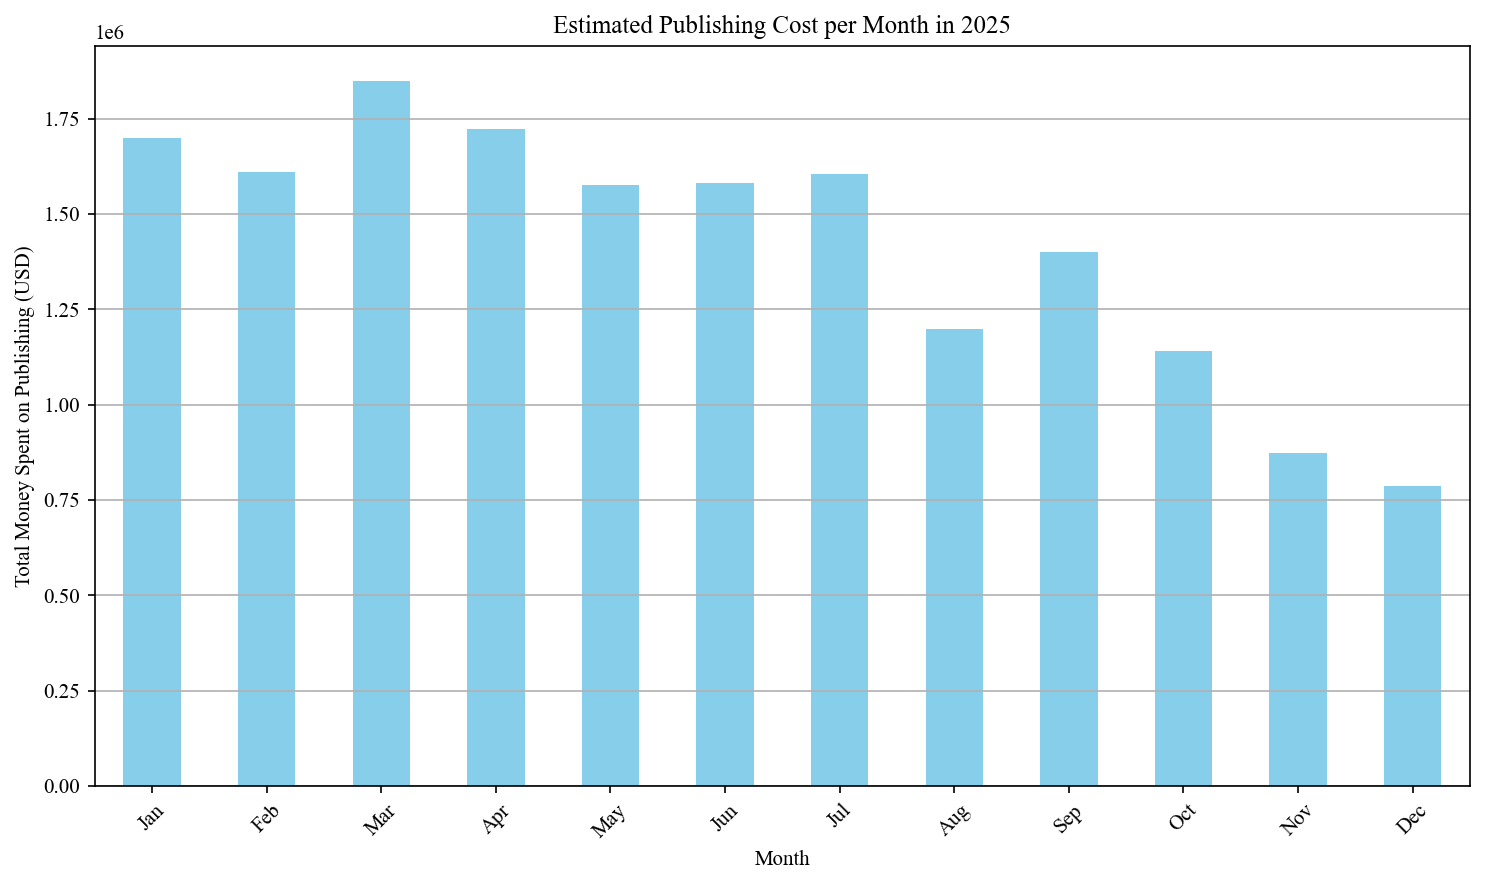

In [85]:
# Bar graph of total publishing cost per month in 2025
import matplotlib.pyplot as plt
data['month'] = pd.to_datetime(data['date'], errors='coerce').dt.month

monthly_costs = data.groupby('month')['publishing_cost_usd'].sum()
plt.figure(figsize=(10,6))
monthly_costs.plot(kind='bar', color='skyblue')
plt.title('Estimated Publishing Cost per Month in 2025')
plt.xlabel('Month')
plt.ylabel('Total Money Spent on Publishing (USD)')
plt.xticks(ticks=range(0,12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

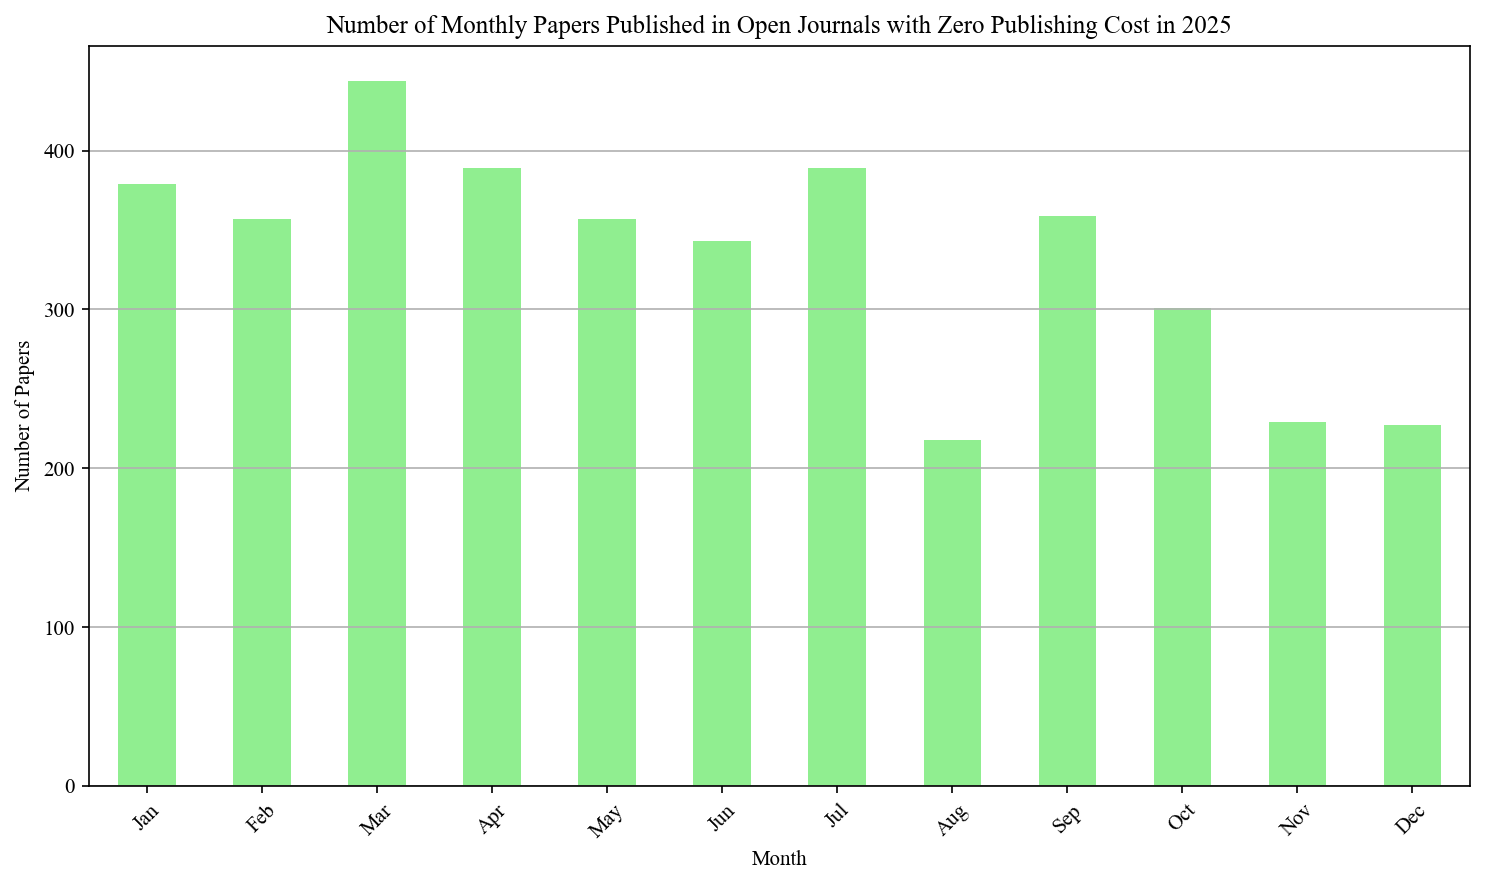

In [90]:
# Number of monthly papers published in open journals with zero publishing cost
masked_data = data[data['journal_flag'] == 1]
monthly_zero_cost_counts = masked_data[masked_data['publishing_cost_usd'] == 0].groupby('month').size()
plt.figure(figsize=(10,6))
monthly_zero_cost_counts.plot(kind='bar', color='lightgreen')
plt.title('Number of Monthly Papers Published in Open Journals with Zero Publishing Cost in 2025')
plt.xlabel('Month')
plt.ylabel('Number of Papers')
plt.xticks(ticks=range(0,12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [92]:
# Check number of papers in Open Journal of Astrophysics (OJAp)
ojap_papers = data[data['published_journal'] == 'OJAp']
print(f"Number of papers published in Open Journal of Astrophysics (OJAp): {len(ojap_papers)}")

Number of papers published in Open Journal of Astrophysics (OJAp): 115
